## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (512, 614)
Hypercube shape: (512, 614, 176)


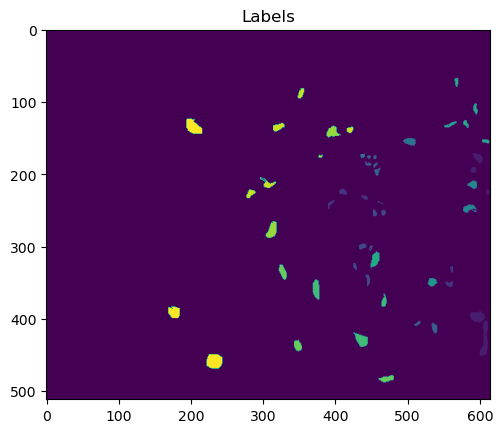

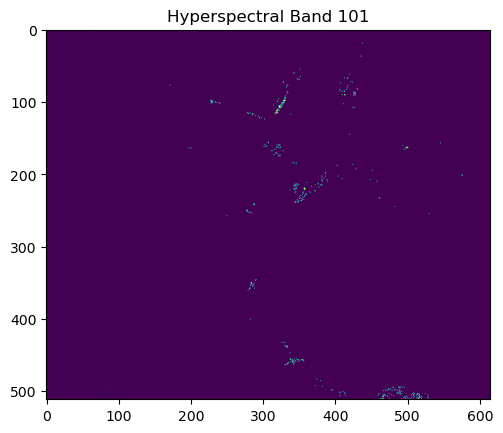

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'KSC_gt.mat'
data_files = 'KSC.mat'
label_files = 'KSC_gt'
hypercube_files = 'KSC'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 5211
Extracted windows shape: (5211, 5, 5, 176)
Corresponding labels shape: (5211,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 10)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 761 samples
Shuffled class indices for class '1'
Selected 10 training samples and 5 validation samples for class '1'

Class: 2: Found 243 samples
Shuffled class indices for class '2'
Selected 10 training samples and 5 validation samples for class '2'

Class: 3: Found 256 samples
Shuffled class indices for class '3'
Selected 10 training samples and 5 validation samples for class '3'

Class: 4: Found 252 samples
Shuffled class indices for class '4'
Selected 10 training samples and 5 validation samples for class '4'

Class: 5: Found 161 samples
Shuffled class indices for class '5'
Selected 10 training samples and 5 validation samples for class '5'

Class: 6: Found 229 samples
Shuffled class indices for class '6'
Selected 10 training samples and 5 validation samples for class '6'

Class: 7: Found 105 samples
Shuffled class indices for class '7'
Sele


All datasets saved to the 'indices' folder.
(130, 5, 5, 176)
(65, 5, 5, 176)
(5016, 5, 5, 176)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 130
Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (4168, 5, 5, 176)
Validation data shape: (1043, 5, 5, 176)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

176


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/66], Loss: 0.2504, PSNR: 6.0133


Epoch [1/50] Training Loss: 0.2392, PSNR: 6.2145
	[Val]   Batch [1/17] Loss: 0.2259, PSNR: 6.4602
	[Val]   Batch [10/17] Loss: 0.2263, PSNR: 6.4541
Epoch [1/50] Validation Loss: 0.2261, PSNR: 6.4566

LOG: Epoch [2/50]
	 Training Batch [1/66], Loss: 0.2179, PSNR: 6.6178


Epoch [2/50] Training Loss: 0.2019, PSNR: 6.2774
	[Val]   Batch [1/17] Loss: 0.1775, PSNR: 7.5090
	[Val]   Batch [10/17] Loss: 0.1794, PSNR: 7.4616
Epoch [2/50] Validation Loss: 0.1790, PSNR: 7.4714

LOG: Epoch [3/50]
	 Training Batch [1/66], Loss: 0.1787, PSNR: 7.4798


Epoch [3/50] Training Loss: 0.1656, PSNR: 7.1286
	[Val]   Batch [1/17] Loss: 0.1437, PSNR: 8.4259
	[Val]   Batch [10/17] Loss: 0.1461, PSNR: 8.3540
Epoch [3/50] Validation Loss: 0.1454, PSNR: 8.3742

LOG: Epoch [4/50]
	 Training Batch [1/66], Loss: 0.1467, PSNR: 8.3357


Epoch [4/50] Training Loss: 0.1334, PSNR: 8.7550
	[Val]   Batch [1/17] Loss: 0.1165, PSNR: 9.3375
	[Val]   Batch [10/17] Loss: 0.1177, PSNR: 9.2907
Epoch [4/50] Validation Loss: 0.1174, PSNR: 9.3050

LOG: Epoch [5/50]
	 Training Batch [1/66], Loss: 0.1165, PSNR: 9.3369


Epoch [5/50] Training Loss: 0.1063, PSNR: 9.7410
	[Val]   Batch [1/17] Loss: 0.0935, PSNR: 10.2916
	[Val]   Batch [10/17] Loss: 0.0948, PSNR: 10.2315
Epoch [5/50] Validation Loss: 0.0945, PSNR: 10.2474

LOG: Epoch [6/50]
	 Training Batch [1/66], Loss: 0.0920, PSNR: 10.3620


Epoch [6/50] Training Loss: 0.0849, PSNR: 10.7192
	[Val]   Batch [1/17] Loss: 0.0751, PSNR: 11.2427
	[Val]   Batch [10/17] Loss: 0.0759, PSNR: 11.1959
Epoch [6/50] Validation Loss: 0.0758, PSNR: 11.2041

LOG: Epoch [7/50]
	 Training Batch [1/66], Loss: 0.0745, PSNR: 11.2804


Epoch [7/50] Training Loss: 0.0683, PSNR: 11.6599
	[Val]   Batch [1/17] Loss: 0.0611, PSNR: 12.1362
	[Val]   Batch [10/17] Loss: 0.0618, PSNR: 12.0933
Epoch [7/50] Validation Loss: 0.0617, PSNR: 12.0999

LOG: Epoch [8/50]
	 Training Batch [1/66], Loss: 0.0603, PSNR: 12.1959


Epoch [8/50] Training Loss: 0.0558, PSNR: 12.5389
	[Val]   Batch [1/17] Loss: 0.0507, PSNR: 12.9472
	[Val]   Batch [10/17] Loss: 0.0513, PSNR: 12.9018
Epoch [8/50] Validation Loss: 0.0511, PSNR: 12.9187

LOG: Epoch [9/50]
	 Training Batch [1/66], Loss: 0.0499, PSNR: 13.0174


Epoch [9/50] Training Loss: 0.0464, PSNR: 13.3380
	[Val]   Batch [1/17] Loss: 0.0428, PSNR: 13.6863
	[Val]   Batch [10/17] Loss: 0.0432, PSNR: 13.6470
Epoch [9/50] Validation Loss: 0.0430, PSNR: 13.6620

LOG: Epoch [10/50]
	 Training Batch [1/66], Loss: 0.0420, PSNR: 13.7718


Epoch [10/50] Training Loss: 0.0392, PSNR: 14.0673
	[Val]   Batch [1/17] Loss: 0.0364, PSNR: 14.3920
	[Val]   Batch [10/17] Loss: 0.0367, PSNR: 14.3592
Epoch [10/50] Validation Loss: 0.0365, PSNR: 14.3741

LOG: Epoch [11/50]
	 Training Batch [1/66], Loss: 0.0355, PSNR: 14.5023


Epoch [11/50] Training Loss: 0.0336, PSNR: 14.7393
	[Val]   Batch [1/17] Loss: 0.0315, PSNR: 15.0137
	[Val]   Batch [10/17] Loss: 0.0318, PSNR: 14.9700
Epoch [11/50] Validation Loss: 0.0317, PSNR: 14.9914

LOG: Epoch [12/50]
	 Training Batch [1/66], Loss: 0.0308, PSNR: 15.1143


Epoch [12/50] Training Loss: 0.0292, PSNR: 14.6683
	[Val]   Batch [1/17] Loss: 0.0277, PSNR: 15.5813
	[Val]   Batch [10/17] Loss: 0.0280, PSNR: 15.5303
Epoch [12/50] Validation Loss: 0.0278, PSNR: 15.5568

LOG: Epoch [13/50]
	 Training Batch [1/66], Loss: 0.0268, PSNR: 15.7194


Epoch [13/50] Training Loss: 0.0256, PSNR: 15.9183
	[Val]   Batch [1/17] Loss: 0.0246, PSNR: 16.0963
	[Val]   Batch [10/17] Loss: 0.0249, PSNR: 16.0429
Epoch [13/50] Validation Loss: 0.0247, PSNR: 16.0691

LOG: Epoch [14/50]
	 Training Batch [1/66], Loss: 0.0238, PSNR: 16.2334


Epoch [14/50] Training Loss: 0.0227, PSNR: 15.7607
	[Val]   Batch [1/17] Loss: 0.0219, PSNR: 16.5980
	[Val]   Batch [10/17] Loss: 0.0222, PSNR: 16.5439
Epoch [14/50] Validation Loss: 0.0220, PSNR: 16.5681

LOG: Epoch [15/50]
	 Training Batch [1/66], Loss: 0.0212, PSNR: 16.7317


Epoch [15/50] Training Loss: 0.0203, PSNR: 16.2529
	[Val]   Batch [1/17] Loss: 0.0199, PSNR: 17.0097
	[Val]   Batch [10/17] Loss: 0.0202, PSNR: 16.9403
Epoch [15/50] Validation Loss: 0.0201, PSNR: 16.9712

LOG: Epoch [16/50]
	 Training Batch [1/66], Loss: 0.0191, PSNR: 17.1855


Epoch [16/50] Training Loss: 0.0183, PSNR: 17.3843
	[Val]   Batch [1/17] Loss: 0.0177, PSNR: 17.5254
	[Val]   Batch [10/17] Loss: 0.0179, PSNR: 17.4796
Epoch [16/50] Validation Loss: 0.0178, PSNR: 17.5022

LOG: Epoch [17/50]
	 Training Batch [1/66], Loss: 0.0173, PSNR: 17.6233


Epoch [17/50] Training Loss: 0.0166, PSNR: 17.8095
	[Val]   Batch [1/17] Loss: 0.0161, PSNR: 17.9384
	[Val]   Batch [10/17] Loss: 0.0163, PSNR: 17.8761
Epoch [17/50] Validation Loss: 0.0162, PSNR: 17.9051

LOG: Epoch [18/50]
	 Training Batch [1/66], Loss: 0.0155, PSNR: 18.0965


Epoch [18/50] Training Loss: 0.0151, PSNR: 17.5413
	[Val]   Batch [1/17] Loss: 0.0146, PSNR: 18.3490
	[Val]   Batch [10/17] Loss: 0.0149, PSNR: 18.2822
Epoch [18/50] Validation Loss: 0.0147, PSNR: 18.3136

LOG: Epoch [19/50]
	 Training Batch [1/66], Loss: 0.0144, PSNR: 18.4223


Epoch [19/50] Training Loss: 0.0138, PSNR: 18.6008
	[Val]   Batch [1/17] Loss: 0.0136, PSNR: 18.6726
	[Val]   Batch [10/17] Loss: 0.0138, PSNR: 18.6007
Epoch [19/50] Validation Loss: 0.0137, PSNR: 18.6337

LOG: Epoch [20/50]
	 Training Batch [1/66], Loss: 0.0131, PSNR: 18.8396


Epoch [20/50] Training Loss: 0.0127, PSNR: 18.9644
	[Val]   Batch [1/17] Loss: 0.0124, PSNR: 19.0790
	[Val]   Batch [10/17] Loss: 0.0126, PSNR: 18.9951
Epoch [20/50] Validation Loss: 0.0125, PSNR: 19.0326

LOG: Epoch [21/50]
	 Training Batch [1/66], Loss: 0.0121, PSNR: 19.1827


Epoch [21/50] Training Loss: 0.0117, PSNR: 19.3071
	[Val]   Batch [1/17] Loss: 0.0114, PSNR: 19.4352
	[Val]   Batch [10/17] Loss: 0.0116, PSNR: 19.3731
Epoch [21/50] Validation Loss: 0.0115, PSNR: 19.4032

LOG: Epoch [22/50]
	 Training Batch [1/66], Loss: 0.0113, PSNR: 19.4727


Epoch [22/50] Training Loss: 0.0109, PSNR: 19.6444
	[Val]   Batch [1/17] Loss: 0.0107, PSNR: 19.7199
	[Val]   Batch [10/17] Loss: 0.0109, PSNR: 19.6446
Epoch [22/50] Validation Loss: 0.0108, PSNR: 19.6826

LOG: Epoch [23/50]
	 Training Batch [1/66], Loss: 0.0107, PSNR: 19.7117


Epoch [23/50] Training Loss: 0.0101, PSNR: 19.2785
	[Val]   Batch [1/17] Loss: 0.0100, PSNR: 19.9997
	[Val]   Batch [10/17] Loss: 0.0102, PSNR: 19.9188
Epoch [23/50] Validation Loss: 0.0101, PSNR: 19.9582

LOG: Epoch [24/50]
	 Training Batch [1/66], Loss: 0.0096, PSNR: 20.1778


Epoch [24/50] Training Loss: 0.0094, PSNR: 19.5722
	[Val]   Batch [1/17] Loss: 0.0094, PSNR: 20.2651
	[Val]   Batch [10/17] Loss: 0.0096, PSNR: 20.1740
Epoch [24/50] Validation Loss: 0.0095, PSNR: 20.2162

LOG: Epoch [25/50]
	 Training Batch [1/66], Loss: 0.0091, PSNR: 20.4128


Epoch [25/50] Training Loss: 0.0088, PSNR: 19.8465
	[Val]   Batch [1/17] Loss: 0.0088, PSNR: 20.5683
	[Val]   Batch [10/17] Loss: 0.0089, PSNR: 20.4839
Epoch [25/50] Validation Loss: 0.0089, PSNR: 20.5233

LOG: Epoch [26/50]
	 Training Batch [1/66], Loss: 0.0085, PSNR: 20.7220


Epoch [26/50] Training Loss: 0.0083, PSNR: 20.8210
	[Val]   Batch [1/17] Loss: 0.0082, PSNR: 20.8637
	[Val]   Batch [10/17] Loss: 0.0084, PSNR: 20.7703
Epoch [26/50] Validation Loss: 0.0083, PSNR: 20.8121

LOG: Epoch [27/50]
	 Training Batch [1/66], Loss: 0.0080, PSNR: 20.9781


Epoch [27/50] Training Loss: 0.0078, PSNR: 21.0938
	[Val]   Batch [1/17] Loss: 0.0077, PSNR: 21.1520
	[Val]   Batch [10/17] Loss: 0.0078, PSNR: 21.0555
Epoch [27/50] Validation Loss: 0.0078, PSNR: 21.0979

LOG: Epoch [28/50]
	 Training Batch [1/66], Loss: 0.0073, PSNR: 21.3408


Epoch [28/50] Training Loss: 0.0073, PSNR: 21.3489
	[Val]   Batch [1/17] Loss: 0.0073, PSNR: 21.3830
	[Val]   Batch [10/17] Loss: 0.0074, PSNR: 21.2871
Epoch [28/50] Validation Loss: 0.0074, PSNR: 21.3313

LOG: Epoch [29/50]
	 Training Batch [1/66], Loss: 0.0070, PSNR: 21.5241


Epoch [29/50] Training Loss: 0.0069, PSNR: 21.5963
	[Val]   Batch [1/17] Loss: 0.0069, PSNR: 21.6373
	[Val]   Batch [10/17] Loss: 0.0070, PSNR: 21.5441
Epoch [29/50] Validation Loss: 0.0069, PSNR: 21.5882

LOG: Epoch [30/50]
	 Training Batch [1/66], Loss: 0.0067, PSNR: 21.7354


Epoch [30/50] Training Loss: 0.0066, PSNR: 21.8328
	[Val]   Batch [1/17] Loss: 0.0065, PSNR: 21.8915
	[Val]   Batch [10/17] Loss: 0.0066, PSNR: 21.7811
Epoch [30/50] Validation Loss: 0.0066, PSNR: 21.8306

LOG: Epoch [31/50]
	 Training Batch [1/66], Loss: 0.0063, PSNR: 22.0331


Epoch [31/50] Training Loss: 0.0062, PSNR: 22.0700
	[Val]   Batch [1/17] Loss: 0.0061, PSNR: 22.1201
	[Val]   Batch [10/17] Loss: 0.0063, PSNR: 21.9995
Epoch [31/50] Validation Loss: 0.0062, PSNR: 22.0518

LOG: Epoch [32/50]
	 Training Batch [1/66], Loss: 0.0063, PSNR: 22.0263


Epoch [32/50] Training Loss: 0.0059, PSNR: 21.6111
	[Val]   Batch [1/17] Loss: 0.0059, PSNR: 22.2816
	[Val]   Batch [10/17] Loss: 0.0061, PSNR: 22.1535
Epoch [32/50] Validation Loss: 0.0060, PSNR: 22.2101

LOG: Epoch [33/50]
	 Training Batch [1/66], Loss: 0.0056, PSNR: 22.4823


Epoch [33/50] Training Loss: 0.0056, PSNR: 22.5181
	[Val]   Batch [1/17] Loss: 0.0056, PSNR: 22.5493
	[Val]   Batch [10/17] Loss: 0.0057, PSNR: 22.4194
Epoch [33/50] Validation Loss: 0.0057, PSNR: 22.4767

LOG: Epoch [34/50]
	 Training Batch [1/66], Loss: 0.0056, PSNR: 22.5347


Epoch [34/50] Training Loss: 0.0053, PSNR: 22.7284
	[Val]   Batch [1/17] Loss: 0.0053, PSNR: 22.7695
	[Val]   Batch [10/17] Loss: 0.0055, PSNR: 22.6323
Epoch [34/50] Validation Loss: 0.0054, PSNR: 22.6913

LOG: Epoch [35/50]
	 Training Batch [1/66], Loss: 0.0051, PSNR: 22.9009


Epoch [35/50] Training Loss: 0.0051, PSNR: 22.2463
	[Val]   Batch [1/17] Loss: 0.0051, PSNR: 22.9440
	[Val]   Batch [10/17] Loss: 0.0052, PSNR: 22.7997
Epoch [35/50] Validation Loss: 0.0052, PSNR: 22.8624

LOG: Epoch [36/50]
	 Training Batch [1/66], Loss: 0.0048, PSNR: 23.1662


Epoch [36/50] Training Loss: 0.0049, PSNR: 23.1407
	[Val]   Batch [1/17] Loss: 0.0048, PSNR: 23.1897
	[Val]   Batch [10/17] Loss: 0.0050, PSNR: 23.0465
Epoch [36/50] Validation Loss: 0.0049, PSNR: 23.1097

LOG: Epoch [37/50]
	 Training Batch [1/66], Loss: 0.0047, PSNR: 23.2702


Epoch [37/50] Training Loss: 0.0046, PSNR: 23.3434
	[Val]   Batch [1/17] Loss: 0.0046, PSNR: 23.3791
	[Val]   Batch [10/17] Loss: 0.0047, PSNR: 23.2333
Epoch [37/50] Validation Loss: 0.0047, PSNR: 23.2962

LOG: Epoch [38/50]
	 Training Batch [1/66], Loss: 0.0044, PSNR: 23.5514


Epoch [38/50] Training Loss: 0.0044, PSNR: 23.5342
	[Val]   Batch [1/17] Loss: 0.0044, PSNR: 23.5743
	[Val]   Batch [10/17] Loss: 0.0045, PSNR: 23.4207
Epoch [38/50] Validation Loss: 0.0045, PSNR: 23.4865

LOG: Epoch [39/50]
	 Training Batch [1/66], Loss: 0.0044, PSNR: 23.5264


Epoch [39/50] Training Loss: 0.0042, PSNR: 23.7312
	[Val]   Batch [1/17] Loss: 0.0042, PSNR: 23.7735
	[Val]   Batch [10/17] Loss: 0.0044, PSNR: 23.6125
Epoch [39/50] Validation Loss: 0.0043, PSNR: 23.6816

LOG: Epoch [40/50]
	 Training Batch [1/66], Loss: 0.0046, PSNR: 23.3765


Epoch [40/50] Training Loss: 0.0041, PSNR: 23.9125
	[Val]   Batch [1/17] Loss: 0.0040, PSNR: 23.9591
	[Val]   Batch [10/17] Loss: 0.0042, PSNR: 23.7976
Epoch [40/50] Validation Loss: 0.0041, PSNR: 23.8666

LOG: Epoch [41/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.1032


Epoch [41/50] Training Loss: 0.0039, PSNR: 24.0875
	[Val]   Batch [1/17] Loss: 0.0039, PSNR: 24.1357
	[Val]   Batch [10/17] Loss: 0.0040, PSNR: 23.9763
Epoch [41/50] Validation Loss: 0.0039, PSNR: 24.0460

LOG: Epoch [42/50]
	 Training Batch [1/66], Loss: 0.0039, PSNR: 24.1149


Epoch [42/50] Training Loss: 0.0037, PSNR: 24.2774
	[Val]   Batch [1/17] Loss: 0.0037, PSNR: 24.3100
	[Val]   Batch [10/17] Loss: 0.0039, PSNR: 24.1293
Epoch [42/50] Validation Loss: 0.0038, PSNR: 24.2080

LOG: Epoch [43/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.4455


Epoch [43/50] Training Loss: 0.0036, PSNR: 23.7613
	[Val]   Batch [1/17] Loss: 0.0036, PSNR: 24.4848
	[Val]   Batch [10/17] Loss: 0.0037, PSNR: 24.2933
Epoch [43/50] Validation Loss: 0.0037, PSNR: 24.3753

LOG: Epoch [44/50]
	 Training Batch [1/66], Loss: 0.0036, PSNR: 24.3973


Epoch [44/50] Training Loss: 0.0035, PSNR: 24.6080
	[Val]   Batch [1/17] Loss: 0.0034, PSNR: 24.6348
	[Val]   Batch [10/17] Loss: 0.0036, PSNR: 24.4472
Epoch [44/50] Validation Loss: 0.0035, PSNR: 24.5271

LOG: Epoch [45/50]
	 Training Batch [1/66], Loss: 0.0034, PSNR: 24.7463


Epoch [45/50] Training Loss: 0.0033, PSNR: 24.7636
	[Val]   Batch [1/17] Loss: 0.0033, PSNR: 24.8260
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.6265
Epoch [45/50] Validation Loss: 0.0034, PSNR: 24.7088

LOG: Epoch [46/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 24.8900


Epoch [46/50] Training Loss: 0.0032, PSNR: 24.2494
	[Val]   Batch [1/17] Loss: 0.0032, PSNR: 24.9549
	[Val]   Batch [10/17] Loss: 0.0034, PSNR: 24.7441
Epoch [46/50] Validation Loss: 0.0033, PSNR: 24.8328

LOG: Epoch [47/50]
	 Training Batch [1/66], Loss: 0.0031, PSNR: 25.1552


Epoch [47/50] Training Loss: 0.0031, PSNR: 24.4097
	[Val]   Batch [1/17] Loss: 0.0031, PSNR: 25.1095
	[Val]   Batch [10/17] Loss: 0.0032, PSNR: 24.8979
Epoch [47/50] Validation Loss: 0.0032, PSNR: 24.9869

LOG: Epoch [48/50]
	 Training Batch [1/66], Loss: 0.0032, PSNR: 25.0143


Epoch [48/50] Training Loss: 0.0030, PSNR: 24.5515
	[Val]   Batch [1/17] Loss: 0.0030, PSNR: 25.2716
	[Val]   Batch [10/17] Loss: 0.0031, PSNR: 25.0497
Epoch [48/50] Validation Loss: 0.0031, PSNR: 25.1424

LOG: Epoch [49/50]
	 Training Batch [1/66], Loss: 0.0028, PSNR: 25.5250


Epoch [49/50] Training Loss: 0.0029, PSNR: 25.3890
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.4589
	[Val]   Batch [10/17] Loss: 0.0030, PSNR: 25.2224
Epoch [49/50] Validation Loss: 0.0029, PSNR: 25.3188

LOG: Epoch [50/50]
	 Training Batch [1/66], Loss: 0.0030, PSNR: 25.2175


Epoch [50/50] Training Loss: 0.0028, PSNR: 25.5307
	[Val]   Batch [1/17] Loss: 0.0028, PSNR: 25.6011
	[Val]   Batch [10/17] Loss: 0.0029, PSNR: 25.3700
Epoch [50/50] Validation Loss: 0.0028, PSNR: 25.4658


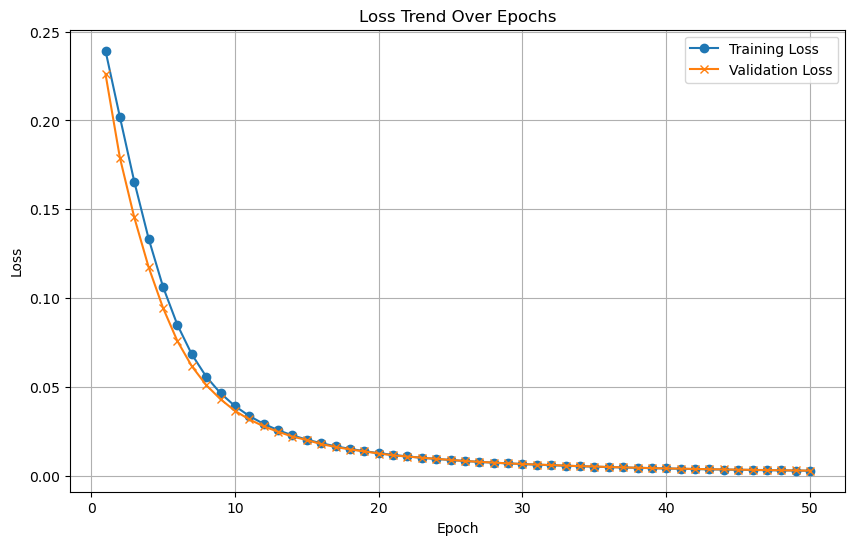

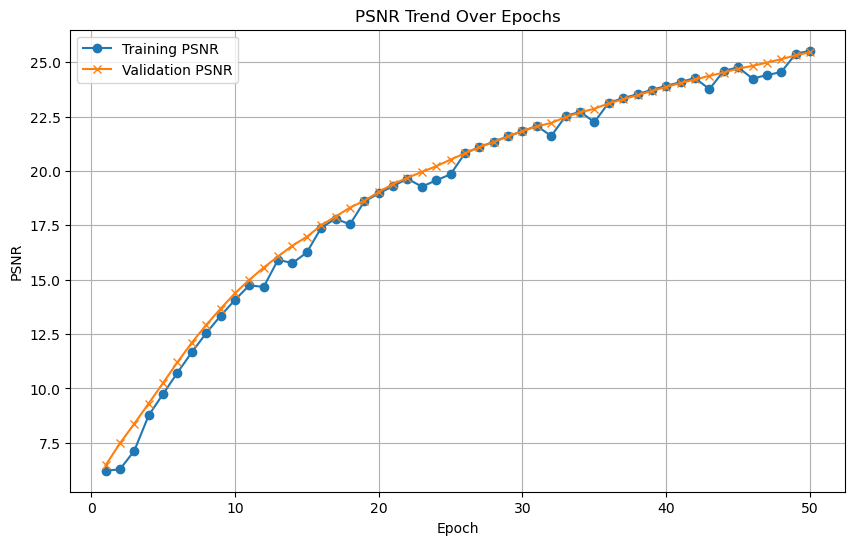

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/20 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.5669
    Validation Batch [1/1], Loss: 2.5682
Validation Loss: 2.5682, Validation Accuracy: 7.69%
Validation loss improved from inf to 2.5682. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.5552
    Validation Batch [1/1], Loss: 2.5682
Validation Loss: 2.5682, Validation Accuracy: 7.69%
Validation loss improved from 2.5682 to 2.5682. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5488
    Validation Batch [1/1], Loss: 2.5682
Validation Loss: 2.5682, Validation Accuracy: 7.69%
Validation loss improved from 2.5682 to 2.5682. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5378
    Validation Batch [1/1], Loss: 2.5682
Validation Loss: 2.5682, Validation Accuracy: 7.69%
Validation loss improved from 2.5682 to 2.5682. Saving model...

LOG: Epoch [5/1000] - 

    Validation Batch [1/1], Loss: 2.5682
Validation Loss: 2.5682, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [21/1000] - Training
Epoch [21/1000] completed, Average Training Loss: 2.4617
    Validation Batch [1/1], Loss: 2.5683
Validation Loss: 2.5683, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [22/1000] - Training
Epoch [22/1000] completed, Average Training Loss: 2.4411
    Validation Batch [1/1], Loss: 2.5683
Validation Loss: 2.5683, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.4468
    Validation Batch [1/1], Loss: 2.5684
Validation Loss: 2.5684, Validation Accuracy: 7.69%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.4341
    Validation Batch [1/1], Loss: 2.5684
Validation Loss: 2.5684, Valid

Epoch [51/1000] completed, Average Training Loss: 2.2198
    Validation Batch [1/1], Loss: 2.5615
Validation Loss: 2.5615, Validation Accuracy: 7.69%
Validation loss improved from 2.5619 to 2.5615. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] completed, Average Training Loss: 2.2078
    Validation Batch [1/1], Loss: 2.5611
Validation Loss: 2.5611, Validation Accuracy: 7.69%
Validation loss improved from 2.5615 to 2.5611. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.1857
    Validation Batch [1/1], Loss: 2.5606
Validation Loss: 2.5606, Validation Accuracy: 7.69%
Validation loss improved from 2.5611 to 2.5606. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.2005
    Validation Batch [1/1], Loss: 2.5599
Validation Loss: 2.5599, Validation Accuracy: 7.69%
Validation loss improved from 2.5606 to 2.5599. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/10

    Validation Batch [1/1], Loss: 2.4069
Validation Loss: 2.4069, Validation Accuracy: 15.38%
Validation loss improved from 2.4225 to 2.4069. Saving model...

LOG: Epoch [80/1000] - Training
Epoch [80/1000] completed, Average Training Loss: 1.9710
    Validation Batch [1/1], Loss: 2.3900
Validation Loss: 2.3900, Validation Accuracy: 15.38%
Validation loss improved from 2.4069 to 2.3900. Saving model...

LOG: Epoch [81/1000] - Training
Epoch [81/1000] completed, Average Training Loss: 1.9719
    Validation Batch [1/1], Loss: 2.3712
Validation Loss: 2.3712, Validation Accuracy: 18.46%
Validation loss improved from 2.3900 to 2.3712. Saving model...

LOG: Epoch [82/1000] - Training
Epoch [82/1000] completed, Average Training Loss: 1.9775
    Validation Batch [1/1], Loss: 2.3514
Validation Loss: 2.3514, Validation Accuracy: 18.46%
Validation loss improved from 2.3712 to 2.3514. Saving model...

LOG: Epoch [83/1000] - Training
Epoch [83/1000] completed, Average Training Loss: 1.9154
    Vali

    Validation Batch [1/1], Loss: 1.9132
Validation Loss: 1.9132, Validation Accuracy: 50.77%
Validation loss improved from 1.9236 to 1.9132. Saving model...

LOG: Epoch [110/1000] - Training
Epoch [110/1000] completed, Average Training Loss: 1.7624
    Validation Batch [1/1], Loss: 1.9071
Validation Loss: 1.9071, Validation Accuracy: 50.77%
Validation loss improved from 1.9132 to 1.9071. Saving model...

LOG: Epoch [111/1000] - Training
Epoch [111/1000] completed, Average Training Loss: 1.7202
    Validation Batch [1/1], Loss: 1.9029
Validation Loss: 1.9029, Validation Accuracy: 49.23%
Validation loss improved from 1.9071 to 1.9029. Saving model...

LOG: Epoch [112/1000] - Training
Epoch [112/1000] completed, Average Training Loss: 1.7228
    Validation Batch [1/1], Loss: 1.8917
Validation Loss: 1.8917, Validation Accuracy: 49.23%
Validation loss improved from 1.9029 to 1.8917. Saving model...

LOG: Epoch [113/1000] - Training
Epoch [113/1000] completed, Average Training Loss: 1.7098


    Validation Batch [1/1], Loss: 1.7337
Validation Loss: 1.7337, Validation Accuracy: 50.77%
Validation loss improved from 1.7366 to 1.7337. Saving model...

LOG: Epoch [140/1000] - Training
Epoch [140/1000] completed, Average Training Loss: 1.5078
    Validation Batch [1/1], Loss: 1.7339
Validation Loss: 1.7339, Validation Accuracy: 52.31%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [141/1000] - Training
Epoch [141/1000] completed, Average Training Loss: 1.4673
    Validation Batch [1/1], Loss: 1.7364
Validation Loss: 1.7364, Validation Accuracy: 50.77%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [142/1000] - Training
Epoch [142/1000] completed, Average Training Loss: 1.4497
    Validation Batch [1/1], Loss: 1.7403
Validation Loss: 1.7403, Validation Accuracy: 50.77%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [143/1000] - Training
Epoch [143/1000] completed, Average Training Loss: 1.4624
    Validation Batch [1/1], Loss: 1.7362
Vali

    Validation Batch [1/1], Loss: 1.5985
Validation Loss: 1.5985, Validation Accuracy: 53.85%
Validation loss improved from 1.6004 to 1.5985. Saving model...

LOG: Epoch [170/1000] - Training
Epoch [170/1000] completed, Average Training Loss: 1.1932
    Validation Batch [1/1], Loss: 1.5960
Validation Loss: 1.5960, Validation Accuracy: 55.38%
Validation loss improved from 1.5985 to 1.5960. Saving model...

LOG: Epoch [171/1000] - Training
Epoch [171/1000] completed, Average Training Loss: 1.2010
    Validation Batch [1/1], Loss: 1.5977
Validation Loss: 1.5977, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [172/1000] - Training
Epoch [172/1000] completed, Average Training Loss: 1.1929
    Validation Batch [1/1], Loss: 1.6020
Validation Loss: 1.6020, Validation Accuracy: 53.85%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [173/1000] - Training
Epoch [173/1000] completed, Average Training Loss: 1.1912
    Validation Batch [1/1], Lo

Epoch [198/1000] completed, Average Training Loss: 1.0064
    Validation Batch [1/1], Loss: 1.5021
Validation Loss: 1.5021, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [199/1000] - Training
Epoch [199/1000] completed, Average Training Loss: 0.9900
    Validation Batch [1/1], Loss: 1.4958
Validation Loss: 1.4958, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [200/1000] - Training
Epoch [200/1000] completed, Average Training Loss: 0.9518
    Validation Batch [1/1], Loss: 1.4800
Validation Loss: 1.4800, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.9492
    Validation Batch [1/1], Loss: 1.4691
Validation Loss: 1.4691, Validation Accuracy: 60.00%
Validation loss improved from 1.4785 to 1.4691. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training 

Epoch [229/1000] completed, Average Training Loss: 0.7465
    Validation Batch [1/1], Loss: 1.4431
Validation Loss: 1.4431, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [230/1000] - Training
Epoch [230/1000] completed, Average Training Loss: 0.7738
    Validation Batch [1/1], Loss: 1.4319
Validation Loss: 1.4319, Validation Accuracy: 61.54%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [231/1000] - Training
Epoch [231/1000] completed, Average Training Loss: 0.7665
    Validation Batch [1/1], Loss: 1.4222
Validation Loss: 1.4222, Validation Accuracy: 58.46%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [232/1000] - Training
Epoch [232/1000] completed, Average Training Loss: 0.7123
    Validation Batch [1/1], Loss: 1.4164
Validation Loss: 1.4164, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [233/1000] - Training
Epoch [233/1000] completed, Average Training Loss: 0.7523
  

Epoch [259/1000] completed, Average Training Loss: 0.6077
    Validation Batch [1/1], Loss: 1.3727
Validation Loss: 1.3727, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [260/1000] - Training
Epoch [260/1000] completed, Average Training Loss: 0.6045
    Validation Batch [1/1], Loss: 1.3825
Validation Loss: 1.3825, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [261/1000] - Training
Epoch [261/1000] completed, Average Training Loss: 0.5478
    Validation Batch [1/1], Loss: 1.3986
Validation Loss: 1.3986, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [262/1000] - Training
Epoch [262/1000] completed, Average Training Loss: 0.5156
    Validation Batch [1/1], Loss: 1.4073
Validation Loss: 1.4073, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [263/1000] - Training
Epoch [263/1000] completed, Average Training Loss: 0.5403
  

    Validation Batch [1/1], Loss: 1.3563
Validation Loss: 1.3563, Validation Accuracy: 72.31%
Validation loss improved from 1.3572 to 1.3563. Saving model...

LOG: Epoch [289/1000] - Training
Epoch [289/1000] completed, Average Training Loss: 0.4588
    Validation Batch [1/1], Loss: 1.3729
Validation Loss: 1.3729, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [290/1000] - Training
Epoch [290/1000] completed, Average Training Loss: 0.4127
    Validation Batch [1/1], Loss: 1.4013
Validation Loss: 1.4013, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [291/1000] - Training
Epoch [291/1000] completed, Average Training Loss: 0.4109
    Validation Batch [1/1], Loss: 1.3936
Validation Loss: 1.3936, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [292/1000] - Training
Epoch [292/1000] completed, Average Training Loss: 0.4055
    Validation Batch [1/1], Loss: 1.3684
Vali

Epoch [319/1000] completed, Average Training Loss: 0.2912
    Validation Batch [1/1], Loss: 1.3913
Validation Loss: 1.3913, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.2727
    Validation Batch [1/1], Loss: 1.3955
Validation Loss: 1.3955, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.2704
    Validation Batch [1/1], Loss: 1.3979
Validation Loss: 1.3979, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.2881
    Validation Batch [1/1], Loss: 1.3955
Validation Loss: 1.3955, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [323/1000] - Training
Epoch [323/1000] completed, Average Training Loss: 0.277

Epoch [347/1000] completed, Average Training Loss: 0.2117
    Validation Batch [1/1], Loss: 1.4337
Validation Loss: 1.4337, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [348/1000] - Training
Epoch [348/1000] completed, Average Training Loss: 0.2322
    Validation Batch [1/1], Loss: 1.4307
Validation Loss: 1.4307, Validation Accuracy: 67.69%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [349/1000] - Training
Epoch [349/1000] completed, Average Training Loss: 0.2370
    Validation Batch [1/1], Loss: 1.4409
Validation Loss: 1.4409, Validation Accuracy: 64.62%
Validation loss did not improve. Patience: 61/100

LOG: Epoch [350/1000] - Training
Epoch [350/1000] completed, Average Training Loss: 0.2076
    Validation Batch [1/1], Loss: 1.4510
Validation Loss: 1.4510, Validation Accuracy: 66.15%
Validation loss did not improve. Patience: 62/100

LOG: Epoch [351/1000] - Training
Epoch [351/1000] completed, Average Training Loss: 0.190

Epoch [377/1000] completed, Average Training Loss: 0.1796
    Validation Batch [1/1], Loss: 1.4547
Validation Loss: 1.4547, Validation Accuracy: 69.23%
Validation loss did not improve. Patience: 89/100

LOG: Epoch [378/1000] - Training
Epoch [378/1000] completed, Average Training Loss: 0.1752
    Validation Batch [1/1], Loss: 1.4443
Validation Loss: 1.4443, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 90/100

LOG: Epoch [379/1000] - Training
Epoch [379/1000] completed, Average Training Loss: 0.1591
    Validation Batch [1/1], Loss: 1.4231
Validation Loss: 1.4231, Validation Accuracy: 70.77%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [380/1000] - Training
Epoch [380/1000] completed, Average Training Loss: 0.1572
    Validation Batch [1/1], Loss: 1.4165
Validation Loss: 1.4165, Validation Accuracy: 72.31%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [381/1000] - Training
Epoch [381/1000] completed, Average Training Loss: 0.200

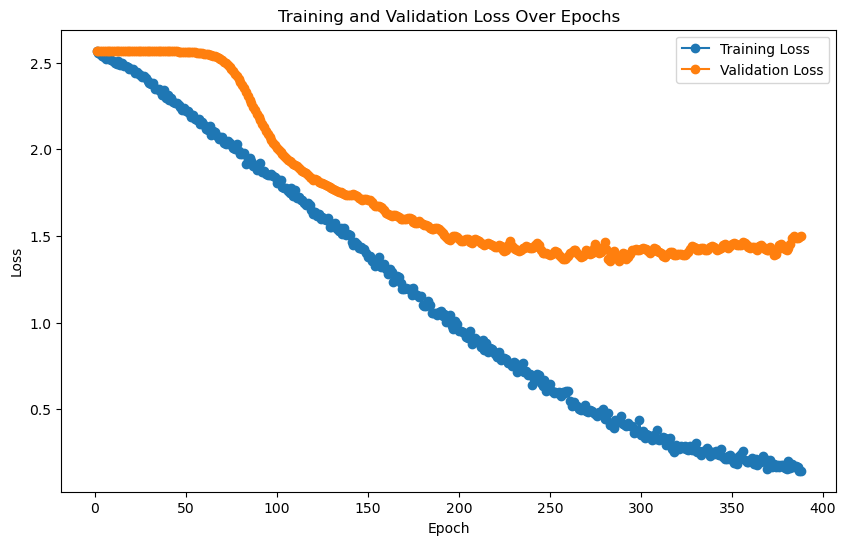

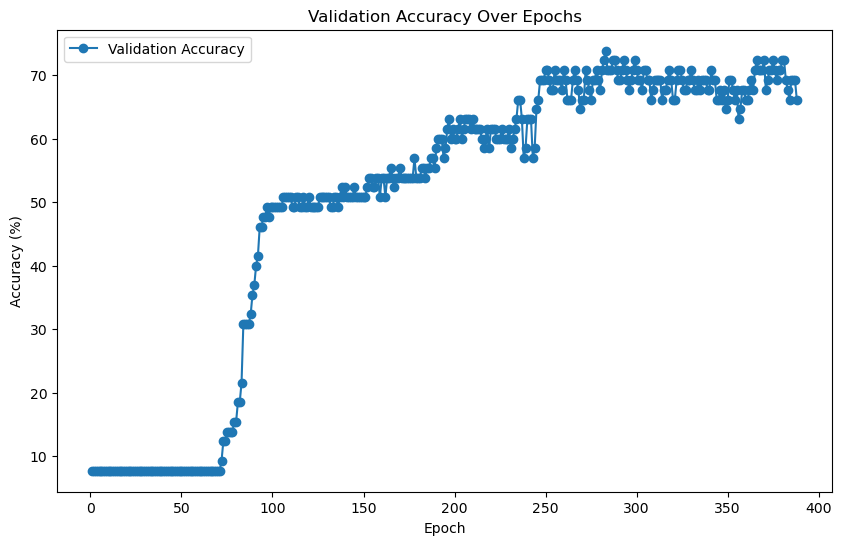


Evaluating on the test set...
    Test Batch [1/20], Loss: 0.7645

Final Test Loss: 1.0395, Test Accuracy: 75.36%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)

LOG: Training features shape: (130, 64), Training labels shape: (130,)
LOG: Validation features shape: (65, 64), Validation labels shape: (65,)
LOG: Test features shape: (5016, 64), Test labels shape: (5016,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 32.31%

Validation Classification Report:
               precision    recall  f1

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)
Train reps shape: (130, 64)
Train labels shape: (130,)
Val reps shape: (65, 64)
Val labels shape: (65,)
Test reps shape: (5016, 64)
Test labels shape: (5016,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7206  |  Val Loss: 2.6286
Validation loss improved from inf to 2.6286.
[Epoch 2/1000] Train Loss: 2.5981  |  Val Loss: 2.6146
Validation loss improved from 2.6286 to 2.6146.
[Epoch 3/1000] Train Loss: 2.5741  |  Val Loss: 2.6227
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 4/1000] Train Loss: 2.5721  |  Val Loss: 2.6247
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 5/1000] Train Loss: 2.5493  |  Val Loss: 2.6001
Validation loss improved from 2.6146 to 2.6001.
[Epoch 6/1000] Train Loss: 2.5157  |  Val Loss: 2.5785
Validation loss improved from 2.6001 to 2.5785.
[Epoch 7/1000] Train Loss: 2.4908  |  Val Loss: 2.5624
Validation loss improved from 2.5785 to 2.5624.
[Epoch 8/1000] Train Loss: 2.4822  |  Val Loss: 2.5543
Validation loss improved from 2.5624 to 2.5543.
[Epoch 9/1000] Train Loss: 2.4827  |  Val Loss: 2.5487
Validation loss improved from 2.5543 to 2.5487.
[Epoch 10/1000] Train Loss: 2.4775  |  Val Loss: 2.5506
!! Valid

[Epoch 22/1000] Train Loss: 2.4423  |  Val Loss: 2.5356
Validation loss improved from 2.5359 to 2.5356.
[Epoch 23/1000] Train Loss: 2.4398  |  Val Loss: 2.5328
Validation loss improved from 2.5356 to 2.5328.
[Epoch 24/1000] Train Loss: 2.4382  |  Val Loss: 2.5262
Validation loss improved from 2.5328 to 2.5262.
[Epoch 25/1000] Train Loss: 2.4367  |  Val Loss: 2.5232
Validation loss improved from 2.5262 to 2.5232.
[Epoch 26/1000] Train Loss: 2.4394  |  Val Loss: 2.5174
Validation loss improved from 2.5232 to 2.5174.
[Epoch 27/1000] Train Loss: 2.4328  |  Val Loss: 2.5032
Validation loss improved from 2.5174 to 2.5032.
[Epoch 28/1000] Train Loss: 2.4196  |  Val Loss: 2.4947
Validation loss improved from 2.5032 to 2.4947.
[Epoch 29/1000] Train Loss: 2.4138  |  Val Loss: 2.4911
Validation loss improved from 2.4947 to 2.4911.
[Epoch 30/1000] Train Loss: 2.4096  |  Val Loss: 2.4916
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 31/1000] Train Loss: 2.4119  |  Val Loss: 2.4848
Validation loss improved from 2.4911 to 2.4848.
[Epoch 32/1000] Train Loss: 2.4196  |  Val Loss: 2.4667
Validation loss improved from 2.4848 to 2.4667.
[Epoch 33/1000] Train Loss: 2.4299  |  Val Loss: 2.4614
Validation loss improved from 2.4667 to 2.4614.
[Epoch 34/1000] Train Loss: 2.4377  |  Val Loss: 2.4578
Validation loss improved from 2.4614 to 2.4578.
[Epoch 35/1000] Train Loss: 2.4286  |  Val Loss: 2.4588
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 36/1000] Train Loss: 2.4121  |  Val Loss: 2.4746
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 37/1000] Train Loss: 2.4041  |  Val Loss: 2.5007
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 38/1000] Train Loss: 2.4089  |  Val Loss: 2.5200
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 39/1000] Train Loss: 2.4104  |  Val Loss: 2.5241
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 40/1000] Train Loss: 2.4065

[Epoch 54/1000] Train Loss: 2.3954  |  Val Loss: 2.5332
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 55/1000] Train Loss: 2.3972  |  Val Loss: 2.5316
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 56/1000] Train Loss: 2.3925  |  Val Loss: 2.5200
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 57/1000] Train Loss: 2.3872  |  Val Loss: 2.5104
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 58/1000] Train Loss: 2.3783  |  Val Loss: 2.4934
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 59/1000] Train Loss: 2.3669  |  Val Loss: 2.4835
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 60/1000] Train Loss: 2.3612  |  Val Loss: 2.4812
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 61/1000] Train Loss: 2.3603  |  Val Loss: 2.4834
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 62/1000] Train Loss: 2.3641  |  Val Loss: 2.4949
!! Validation loss did NOT improve !! Patience: 19/100
[

[Epoch 64/1000] Train Loss: 2.3577  |  Val Loss: 2.5309
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 65/1000] Train Loss: 2.3593  |  Val Loss: 2.5400
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 66/1000] Train Loss: 2.3636  |  Val Loss: 2.5138
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 67/1000] Train Loss: 2.3461  |  Val Loss: 2.4736
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 68/1000] Train Loss: 2.3424  |  Val Loss: 2.4662
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 69/1000] Train Loss: 2.3564  |  Val Loss: 2.4685
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 70/1000] Train Loss: 2.3594  |  Val Loss: 2.4722
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 71/1000] Train Loss: 2.3541  |  Val Loss: 2.4943
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 72/1000] Train Loss: 2.3635  |  Val Loss: 2.5236
!! Validation loss did NOT improve !! Patience: 29/100
[

[Epoch 86/1000] Train Loss: 2.3331  |  Val Loss: 2.5875
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 87/1000] Train Loss: 2.3367  |  Val Loss: 2.5837
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 88/1000] Train Loss: 2.3320  |  Val Loss: 2.5125
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 89/1000] Train Loss: 2.3070  |  Val Loss: 2.4506
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 90/1000] Train Loss: 2.3373  |  Val Loss: 2.4795
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 91/1000] Train Loss: 2.4054  |  Val Loss: 2.5038
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 92/1000] Train Loss: 2.4297  |  Val Loss: 2.4687
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 93/1000] Train Loss: 2.3831  |  Val Loss: 2.4546
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 94/1000] Train Loss: 2.3422  |  Val Loss: 2.4415
Validation loss improved from 2.4500 to 2.4415.
[Epoch 9

[Epoch 97/1000] Train Loss: 2.2936  |  Val Loss: 2.4991
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 98/1000] Train Loss: 2.3057  |  Val Loss: 2.5187
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 99/1000] Train Loss: 2.3146  |  Val Loss: 2.5258
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 100/1000] Train Loss: 2.3197  |  Val Loss: 2.5297
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 101/1000] Train Loss: 2.3349  |  Val Loss: 2.5271
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 102/1000] Train Loss: 2.3353  |  Val Loss: 2.4975
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 103/1000] Train Loss: 2.3162  |  Val Loss: 2.4797
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 104/1000] Train Loss: 2.3042  |  Val Loss: 2.4785
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 105/1000] Train Loss: 2.3080  |  Val Loss: 2.4756
!! Validation loss did NOT improve !! Patience: 11/100
[E

[Epoch 114/1000] Train Loss: 2.2773  |  Val Loss: 2.5595
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 115/1000] Train Loss: 2.2796  |  Val Loss: 2.5653
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 116/1000] Train Loss: 2.2690  |  Val Loss: 2.5523
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 117/1000] Train Loss: 2.2655  |  Val Loss: 2.5488
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 118/1000] Train Loss: 2.2775  |  Val Loss: 2.5464
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 119/1000] Train Loss: 2.2958  |  Val Loss: 2.4955
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 120/1000] Train Loss: 2.2523  |  Val Loss: 2.4593
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 121/1000] Train Loss: 2.2306  |  Val Loss: 2.4495
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 122/1000] Train Loss: 2.2308  |  Val Loss: 2.4455
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 127/1000] Train Loss: 2.2223  |  Val Loss: 2.4249
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 128/1000] Train Loss: 2.2234  |  Val Loss: 2.4192
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 129/1000] Train Loss: 2.2183  |  Val Loss: 2.4260
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 130/1000] Train Loss: 2.2120  |  Val Loss: 2.4581
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 131/1000] Train Loss: 2.2051  |  Val Loss: 2.4923
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 132/1000] Train Loss: 2.2021  |  Val Loss: 2.5741
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 133/1000] Train Loss: 2.2660  |  Val Loss: 2.5948
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 134/1000] Train Loss: 2.2450  |  Val Loss: 2.5424
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 135/1000] Train Loss: 2.2040  |  Val Loss: 2.5409
!! Validation loss did NOT improve !! Patience:

[Epoch 144/1000] Train Loss: 2.1947  |  Val Loss: 2.4453
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 145/1000] Train Loss: 2.1950  |  Val Loss: 2.5097
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 146/1000] Train Loss: 2.2505  |  Val Loss: 2.4800
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 147/1000] Train Loss: 2.2012  |  Val Loss: 2.4312
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 148/1000] Train Loss: 2.1554  |  Val Loss: 2.4101
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 149/1000] Train Loss: 2.1448  |  Val Loss: 2.3933
Validation loss improved from 2.4057 to 2.3933.
[Epoch 150/1000] Train Loss: 2.1421  |  Val Loss: 2.4037
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 151/1000] Train Loss: 2.1506  |  Val Loss: 2.4131
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 152/1000] Train Loss: 2.1556  |  Val Loss: 2.4234
!! Validation loss did NOT improve !! Patience: 3/100
[E

[Epoch 155/1000] Train Loss: 2.1563  |  Val Loss: 2.4173
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 156/1000] Train Loss: 2.1495  |  Val Loss: 2.4208
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 157/1000] Train Loss: 2.1582  |  Val Loss: 2.4747
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 158/1000] Train Loss: 2.2080  |  Val Loss: 2.4781
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 159/1000] Train Loss: 2.1916  |  Val Loss: 2.4329
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 160/1000] Train Loss: 2.1337  |  Val Loss: 2.4216
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 161/1000] Train Loss: 2.1192  |  Val Loss: 2.4339
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 162/1000] Train Loss: 2.1132  |  Val Loss: 2.4536
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 163/1000] Train Loss: 2.1221  |  Val Loss: 2.4629
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 171/1000] Train Loss: 2.1481  |  Val Loss: 2.3785
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 172/1000] Train Loss: 2.1136  |  Val Loss: 2.3876
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 173/1000] Train Loss: 2.1202  |  Val Loss: 2.4043
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 174/1000] Train Loss: 2.1127  |  Val Loss: 2.4116
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 175/1000] Train Loss: 2.1155  |  Val Loss: 2.4773
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 176/1000] Train Loss: 2.1645  |  Val Loss: 2.4207
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 177/1000] Train Loss: 2.0825  |  Val Loss: 2.3999
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 178/1000] Train Loss: 2.0828  |  Val Loss: 2.3798
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 179/1000] Train Loss: 2.0582  |  Val Loss: 2.3633
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 189/1000] Train Loss: 2.0735  |  Val Loss: 2.3883
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 190/1000] Train Loss: 2.0752  |  Val Loss: 2.3850
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 191/1000] Train Loss: 2.0765  |  Val Loss: 2.3942
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 192/1000] Train Loss: 2.0870  |  Val Loss: 2.3841
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 193/1000] Train Loss: 2.0659  |  Val Loss: 2.3700
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 194/1000] Train Loss: 2.0460  |  Val Loss: 2.3937
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 195/1000] Train Loss: 2.0591  |  Val Loss: 2.3905
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 196/1000] Train Loss: 2.0722  |  Val Loss: 2.4580
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 197/1000] Train Loss: 2.1181  |  Val Loss: 2.3525
!! Validation loss did NOT improve !! Patience: 1

[Epoch 202/1000] Train Loss: 2.0403  |  Val Loss: 2.3329
Validation loss improved from 2.3449 to 2.3329.
[Epoch 203/1000] Train Loss: 2.0209  |  Val Loss: 2.3072
Validation loss improved from 2.3329 to 2.3072.
[Epoch 204/1000] Train Loss: 2.0180  |  Val Loss: 2.3737
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 205/1000] Train Loss: 2.0949  |  Val Loss: 2.3748
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 206/1000] Train Loss: 2.0634  |  Val Loss: 2.2909
Validation loss improved from 2.3072 to 2.2909.
[Epoch 207/1000] Train Loss: 1.9861  |  Val Loss: 2.3445
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 208/1000] Train Loss: 2.0336  |  Val Loss: 2.3218
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 209/1000] Train Loss: 2.0044  |  Val Loss: 2.3286
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 210/1000] Train Loss: 1.9976  |  Val Loss: 2.3488
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 211/1000] Tr

[Epoch 217/1000] Train Loss: 2.0175  |  Val Loss: 2.3693
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 218/1000] Train Loss: 1.9858  |  Val Loss: 2.3479
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 219/1000] Train Loss: 1.9851  |  Val Loss: 2.3258
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 220/1000] Train Loss: 1.9782  |  Val Loss: 2.2812
Validation loss improved from 2.2909 to 2.2812.
[Epoch 221/1000] Train Loss: 1.9480  |  Val Loss: 2.2875
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 222/1000] Train Loss: 1.9607  |  Val Loss: 2.3270
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 223/1000] Train Loss: 1.9871  |  Val Loss: 2.3006
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 224/1000] Train Loss: 1.9575  |  Val Loss: 2.3768
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 225/1000] Train Loss: 2.0329  |  Val Loss: 2.3413
!! Validation loss did NOT improve !! Patience: 5/100
[Epo

[Epoch 234/1000] Train Loss: 2.0159  |  Val Loss: 2.4601
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 235/1000] Train Loss: 2.0136  |  Val Loss: 2.3205
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 236/1000] Train Loss: 1.9223  |  Val Loss: 2.3794
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 237/1000] Train Loss: 1.9986  |  Val Loss: 2.3767
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 238/1000] Train Loss: 1.9864  |  Val Loss: 2.3114
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 239/1000] Train Loss: 1.9187  |  Val Loss: 2.3603
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 240/1000] Train Loss: 1.9637  |  Val Loss: 2.4355
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 241/1000] Train Loss: 1.9944  |  Val Loss: 2.3645
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 242/1000] Train Loss: 1.9150  |  Val Loss: 2.4555
!! Validation loss did NOT improve !! Patience:

[Epoch 248/1000] Train Loss: 1.9465  |  Val Loss: 2.3766
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 249/1000] Train Loss: 2.0057  |  Val Loss: 2.3705
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 250/1000] Train Loss: 2.0016  |  Val Loss: 2.2573
Validation loss improved from 2.2812 to 2.2573.
[Epoch 251/1000] Train Loss: 1.9064  |  Val Loss: 2.5477
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 252/1000] Train Loss: 2.2164  |  Val Loss: 2.3852
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 253/1000] Train Loss: 1.9564  |  Val Loss: 2.3405
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 254/1000] Train Loss: 1.9425  |  Val Loss: 2.3863
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 255/1000] Train Loss: 1.9812  |  Val Loss: 2.3767
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 256/1000] Train Loss: 1.9435  |  Val Loss: 2.3321
!! Validation loss did NOT improve !! Patience: 6/100
[Epoc

[Epoch 260/1000] Train Loss: 1.9147  |  Val Loss: 2.3197
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 261/1000] Train Loss: 1.8956  |  Val Loss: 2.2989
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 262/1000] Train Loss: 1.8925  |  Val Loss: 2.3314
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 263/1000] Train Loss: 1.9329  |  Val Loss: 2.3276
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 264/1000] Train Loss: 1.9392  |  Val Loss: 2.3358
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 265/1000] Train Loss: 1.9548  |  Val Loss: 2.3347
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 266/1000] Train Loss: 1.9385  |  Val Loss: 2.2850
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 267/1000] Train Loss: 1.8881  |  Val Loss: 2.2651
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 268/1000] Train Loss: 1.8607  |  Val Loss: 2.2829
!! Validation loss did NOT improve !! Patience:

[Epoch 279/1000] Train Loss: 1.8889  |  Val Loss: 2.3413
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 280/1000] Train Loss: 1.9559  |  Val Loss: 2.2650
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 281/1000] Train Loss: 1.8722  |  Val Loss: 2.2528
Validation loss improved from 2.2537 to 2.2528.
[Epoch 282/1000] Train Loss: 1.8441  |  Val Loss: 2.2628
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 283/1000] Train Loss: 1.8427  |  Val Loss: 2.2686
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 284/1000] Train Loss: 1.8376  |  Val Loss: 2.2913
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 285/1000] Train Loss: 1.8444  |  Val Loss: 2.3222
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 286/1000] Train Loss: 1.8634  |  Val Loss: 2.3104
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 287/1000] Train Loss: 1.8498  |  Val Loss: 2.3317
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 

[Epoch 293/1000] Train Loss: 1.9310  |  Val Loss: 2.3579
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 294/1000] Train Loss: 1.8930  |  Val Loss: 2.2894
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 295/1000] Train Loss: 1.8687  |  Val Loss: 2.3514
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 296/1000] Train Loss: 1.8541  |  Val Loss: 2.2937
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 297/1000] Train Loss: 1.8547  |  Val Loss: 2.3886
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 298/1000] Train Loss: 1.9619  |  Val Loss: 2.3838
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 299/1000] Train Loss: 1.9391  |  Val Loss: 2.3648
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 300/1000] Train Loss: 2.0049  |  Val Loss: 2.5913
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 301/1000] Train Loss: 2.0663  |  Val Loss: 2.2779
!! Validation loss did NOT improve !! Patience:

[Epoch 310/1000] Train Loss: 1.8420  |  Val Loss: 2.3148
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 311/1000] Train Loss: 1.9482  |  Val Loss: 2.3042
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 312/1000] Train Loss: 1.9249  |  Val Loss: 2.2425
Validation loss improved from 2.2528 to 2.2425.
[Epoch 313/1000] Train Loss: 1.8292  |  Val Loss: 2.2384
Validation loss improved from 2.2425 to 2.2384.
[Epoch 314/1000] Train Loss: 1.7974  |  Val Loss: 2.3095
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 315/1000] Train Loss: 1.8061  |  Val Loss: 2.3458
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 316/1000] Train Loss: 1.8141  |  Val Loss: 2.3729
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 317/1000] Train Loss: 1.8393  |  Val Loss: 2.3863
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 318/1000] Train Loss: 1.8475  |  Val Loss: 2.3797
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 319/

[Epoch 321/1000] Train Loss: 1.8027  |  Val Loss: 2.2826
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 322/1000] Train Loss: 1.7787  |  Val Loss: 2.2598
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 323/1000] Train Loss: 1.7836  |  Val Loss: 2.2625
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 324/1000] Train Loss: 1.8017  |  Val Loss: 2.2766
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 325/1000] Train Loss: 1.8128  |  Val Loss: 2.2656
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 326/1000] Train Loss: 1.7884  |  Val Loss: 2.2965
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 327/1000] Train Loss: 1.8030  |  Val Loss: 2.3447
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 328/1000] Train Loss: 1.8149  |  Val Loss: 2.3750
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 329/1000] Train Loss: 1.8469  |  Val Loss: 2.3080
!! Validation loss did NOT improve !! Patience: 1

[Epoch 341/1000] Train Loss: 1.7525  |  Val Loss: 2.2879
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 342/1000] Train Loss: 1.7555  |  Val Loss: 2.2928
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 343/1000] Train Loss: 1.7953  |  Val Loss: 2.3102
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 344/1000] Train Loss: 1.7703  |  Val Loss: 2.2858
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 345/1000] Train Loss: 1.7733  |  Val Loss: 2.3712
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 346/1000] Train Loss: 1.8492  |  Val Loss: 2.4013
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 347/1000] Train Loss: 1.8387  |  Val Loss: 2.4084
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 348/1000] Train Loss: 1.8378  |  Val Loss: 2.3513
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 349/1000] Train Loss: 1.7893  |  Val Loss: 2.2959
!! Validation loss did NOT improve !! Patience: 

[Epoch 350/1000] Train Loss: 1.7604  |  Val Loss: 2.2622
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 351/1000] Train Loss: 1.7499  |  Val Loss: 2.2751
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 352/1000] Train Loss: 1.7678  |  Val Loss: 2.2843
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 353/1000] Train Loss: 1.7694  |  Val Loss: 2.2733
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 354/1000] Train Loss: 1.7459  |  Val Loss: 2.2862
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 355/1000] Train Loss: 1.7424  |  Val Loss: 2.3302
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 356/1000] Train Loss: 1.7571  |  Val Loss: 2.3041
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 357/1000] Train Loss: 1.7309  |  Val Loss: 2.3003
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 358/1000] Train Loss: 1.7245  |  Val Loss: 2.2947
!! Validation loss did NOT improve !! Patience:

[Epoch 370/1000] Train Loss: 1.7363  |  Val Loss: 2.2889
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 371/1000] Train Loss: 1.7662  |  Val Loss: 2.4003
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 372/1000] Train Loss: 1.8289  |  Val Loss: 2.4371
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 373/1000] Train Loss: 1.8005  |  Val Loss: 2.4365
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 374/1000] Train Loss: 1.7374  |  Val Loss: 2.4917
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 375/1000] Train Loss: 1.7468  |  Val Loss: 2.4444
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 376/1000] Train Loss: 1.7233  |  Val Loss: 2.4058
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 377/1000] Train Loss: 1.7430  |  Val Loss: 2.4602
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 378/1000] Train Loss: 1.8160  |  Val Loss: 2.3481
!! Validation loss did NOT improve !! Patience:

[Epoch 382/1000] Train Loss: 1.7628  |  Val Loss: 2.2219
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 383/1000] Train Loss: 1.7078  |  Val Loss: 2.2257
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 384/1000] Train Loss: 1.7050  |  Val Loss: 2.2546
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 385/1000] Train Loss: 1.7373  |  Val Loss: 2.2696
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 386/1000] Train Loss: 1.7296  |  Val Loss: 2.2674
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 387/1000] Train Loss: 1.7173  |  Val Loss: 2.3031
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 388/1000] Train Loss: 1.7698  |  Val Loss: 2.2752
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 389/1000] Train Loss: 1.7218  |  Val Loss: 2.3085
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 390/1000] Train Loss: 1.7890  |  Val Loss: 2.2612
!! Validation loss did NOT improve !! Patience:

[Epoch 401/1000] Train Loss: 1.6903  |  Val Loss: 2.2342
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 402/1000] Train Loss: 1.7149  |  Val Loss: 2.3116
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 403/1000] Train Loss: 1.8010  |  Val Loss: 2.2299
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 404/1000] Train Loss: 1.6896  |  Val Loss: 2.3941
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 405/1000] Train Loss: 1.8629  |  Val Loss: 2.2610
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 406/1000] Train Loss: 1.6916  |  Val Loss: 2.2763
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 407/1000] Train Loss: 1.7820  |  Val Loss: 2.2763
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 408/1000] Train Loss: 1.7293  |  Val Loss: 2.2749
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 409/1000] Train Loss: 1.7599  |  Val Loss: 2.3866
!! Validation loss did NOT improve !! Patience:

[Epoch 412/1000] Train Loss: 1.9126  |  Val Loss: 2.3569
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 413/1000] Train Loss: 1.7446  |  Val Loss: 2.3585
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 414/1000] Train Loss: 1.7844  |  Val Loss: 2.3544
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 415/1000] Train Loss: 1.7327  |  Val Loss: 2.2511
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 416/1000] Train Loss: 1.7097  |  Val Loss: 2.3579
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 417/1000] Train Loss: 1.8063  |  Val Loss: 2.2506
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 418/1000] Train Loss: 1.6958  |  Val Loss: 2.1832
Validation loss improved from 2.2160 to 2.1832.
[Epoch 419/1000] Train Loss: 1.6600  |  Val Loss: 2.3089
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 420/1000] Train Loss: 1.8586  |  Val Loss: 2.2264
!! Validation loss did NOT improve !! Patience: 2/100
[

[Epoch 433/1000] Train Loss: 1.7297  |  Val Loss: 2.2465
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 434/1000] Train Loss: 1.6981  |  Val Loss: 2.3069
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 435/1000] Train Loss: 1.7215  |  Val Loss: 2.2388
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 436/1000] Train Loss: 1.6579  |  Val Loss: 2.2714
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 437/1000] Train Loss: 1.7750  |  Val Loss: 2.2994
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 438/1000] Train Loss: 1.7285  |  Val Loss: 2.3002
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 439/1000] Train Loss: 1.7538  |  Val Loss: 2.3146
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 440/1000] Train Loss: 1.7728  |  Val Loss: 2.2833
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 441/1000] Train Loss: 1.7673  |  Val Loss: 2.3367
!! Validation loss did NOT improve !! Patience:

[Epoch 444/1000] Train Loss: 1.6984  |  Val Loss: 2.2905
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 445/1000] Train Loss: 1.6974  |  Val Loss: 2.2196
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 446/1000] Train Loss: 1.6495  |  Val Loss: 2.2783
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 447/1000] Train Loss: 1.7078  |  Val Loss: 2.2919
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 448/1000] Train Loss: 1.6711  |  Val Loss: 2.3519
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 449/1000] Train Loss: 1.6911  |  Val Loss: 2.3835
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 450/1000] Train Loss: 1.6997  |  Val Loss: 2.3492
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 451/1000] Train Loss: 1.6880  |  Val Loss: 2.3229
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 452/1000] Train Loss: 1.6815  |  Val Loss: 2.2800
!! Validation loss did NOT improve !! Patience:

[Epoch 462/1000] Train Loss: 1.6744  |  Val Loss: 2.2914
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 463/1000] Train Loss: 1.6434  |  Val Loss: 2.4351
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 464/1000] Train Loss: 1.8018  |  Val Loss: 2.3945
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 465/1000] Train Loss: 1.7290  |  Val Loss: 2.3246
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 466/1000] Train Loss: 1.7570  |  Val Loss: 2.4173
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 467/1000] Train Loss: 1.7453  |  Val Loss: 2.2293
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 468/1000] Train Loss: 1.6866  |  Val Loss: 2.2529
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 469/1000] Train Loss: 1.6847  |  Val Loss: 2.2141
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 470/1000] Train Loss: 1.6872  |  Val Loss: 2.2564
!! Validation loss did NOT improve !! Patience:

[Epoch 473/1000] Train Loss: 1.6582  |  Val Loss: 2.2937
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 474/1000] Train Loss: 1.7509  |  Val Loss: 2.4349
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 475/1000] Train Loss: 1.7808  |  Val Loss: 2.2312
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 476/1000] Train Loss: 1.6197  |  Val Loss: 2.2775
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 477/1000] Train Loss: 1.6786  |  Val Loss: 2.3211
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 478/1000] Train Loss: 1.6875  |  Val Loss: 2.3126
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 479/1000] Train Loss: 1.6624  |  Val Loss: 2.3536
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 480/1000] Train Loss: 1.6742  |  Val Loss: 2.3301
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 481/1000] Train Loss: 1.6434  |  Val Loss: 2.3768
!! Validation loss did NOT improve !! Patience:

[Epoch 491/1000] Train Loss: 1.6194  |  Val Loss: 2.2860
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 492/1000] Train Loss: 1.6337  |  Val Loss: 2.3360
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 493/1000] Train Loss: 1.6692  |  Val Loss: 2.2792
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 494/1000] Train Loss: 1.6428  |  Val Loss: 2.3098
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 495/1000] Train Loss: 1.6644  |  Val Loss: 2.3279
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 496/1000] Train Loss: 1.6590  |  Val Loss: 2.2555
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 497/1000] Train Loss: 1.6065  |  Val Loss: 2.2637
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 498/1000] Train Loss: 1.6074  |  Val Loss: 2.2600
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 499/1000] Train Loss: 1.5926  |  Val Loss: 2.2540
!! Validation loss did NOT improve !! Patience:

[Epoch 504/1000] Train Loss: 1.5964  |  Val Loss: 2.3303
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 505/1000] Train Loss: 1.6901  |  Val Loss: 2.2317
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 506/1000] Train Loss: 1.5728  |  Val Loss: 2.2375
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 507/1000] Train Loss: 1.6342  |  Val Loss: 2.2240
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 508/1000] Train Loss: 1.6078  |  Val Loss: 2.2295
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 509/1000] Train Loss: 1.6256  |  Val Loss: 2.2419
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 510/1000] Train Loss: 1.6041  |  Val Loss: 2.2915
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 511/1000] Train Loss: 1.7559  |  Val Loss: 2.3188
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 512/1000] Train Loss: 1.6987  |  Val Loss: 2.2266
!! Validation loss did NOT improve !! Patience:

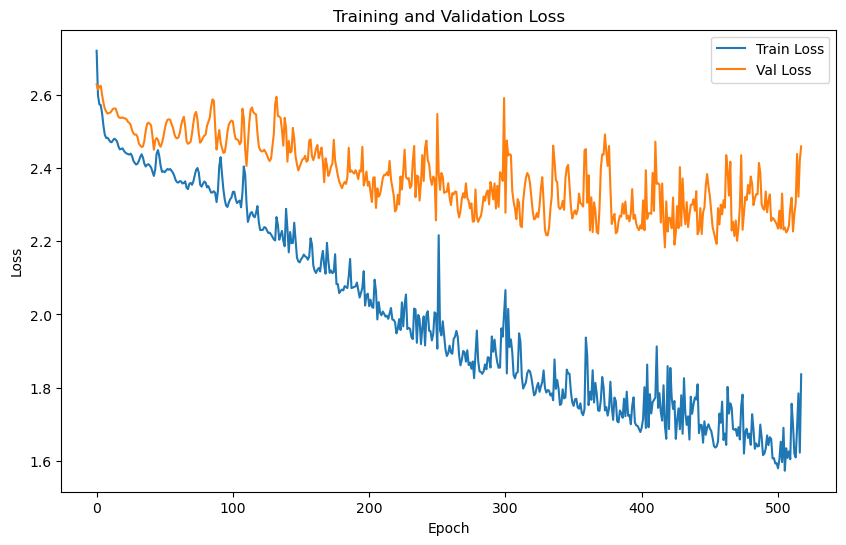

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 2.2228 | Test Accuracy: 29.88%


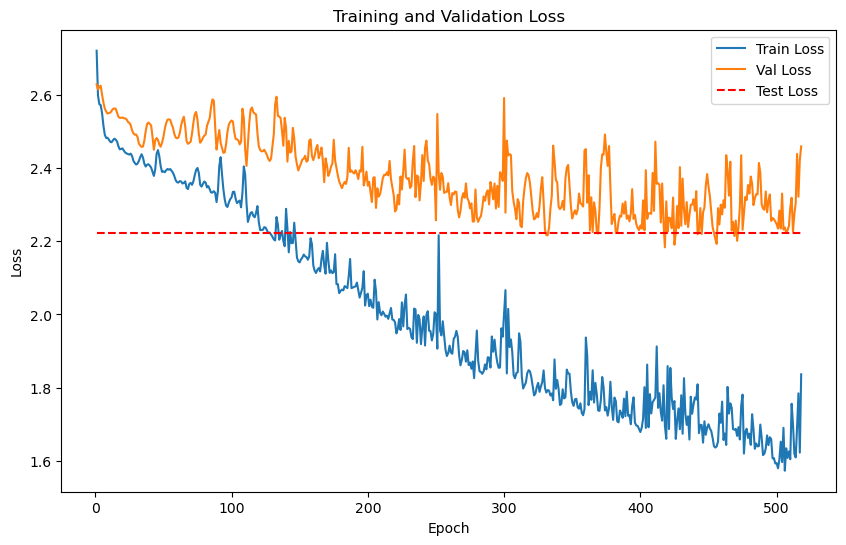

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)


Train embeddings shape: (130, 64), 
Train labels shape: (130,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5016, 64), 
Test labels shape: (5016,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
Training batch size: 130


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training
    Batch [1/1], Train Loss: 8.3057
Epoch [1/2000], Avg Train Loss: 8.3057


Epoch [1/2000], Avg Val Loss: 5.5972
Validation loss improved from inf to 5.5972. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.2568
Epoch [2/2000], Avg Train Loss: 8.2568
Epoch [2/2000], Avg Val Loss: 5.5661
Validation loss improved from 5.5972 to 5.5661. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 8.2671
Epoch [3/2000], Avg Train Loss: 8.2671
Epoch [3/2000], Avg Val Loss: 5.5356
Validation loss improved from 5.5661 to 5.5356. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 8.0906
Epoch [4/2000], Avg Train Loss: 8.0906
Epoch [4/2000], Avg Val Loss: 5.5053
Validation loss improved from 5.5356 to 5.5053. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 8.2659
Epoch [5/2000], Avg Train Loss: 8.2659
Epoch [5/2000], Avg Val Loss: 5.4752
Validation loss improved from 5.5053 to 5.4752. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 7.9851
Ep

    Batch [1/1], Train Loss: 7.1281
Epoch [21/2000], Avg Train Loss: 7.1281
Epoch [21/2000], Avg Val Loss: 5.0085
Validation loss improved from 5.0361 to 5.0085. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 7.0074
Epoch [22/2000], Avg Train Loss: 7.0074
Epoch [22/2000], Avg Val Loss: 4.9809
Validation loss improved from 5.0085 to 4.9809. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 7.0355
Epoch [23/2000], Avg Train Loss: 7.0355
Epoch [23/2000], Avg Val Loss: 4.9539
Validation loss improved from 4.9809 to 4.9539. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.9334
Epoch [24/2000], Avg Train Loss: 6.9334
Epoch [24/2000], Avg Val Loss: 4.9271
Validation loss improved from 4.9539 to 4.9271. Saving model...

LOG: Epoch [25/2000] - Training
    Batch [1/1], Train Loss: 6.7798
Epoch [25/2000], Avg Train Loss: 6.7798
Epoch [25/2000], Avg Val Loss: 4.9007
Validation loss improved from 4.9271 to 4.

    Batch [1/1], Train Loss: 6.7851
Epoch [31/2000], Avg Train Loss: 6.7851
Epoch [31/2000], Avg Val Loss: 4.7476
Validation loss improved from 4.7724 to 4.7476. Saving model...

LOG: Epoch [32/2000] - Training
    Batch [1/1], Train Loss: 6.5883
Epoch [32/2000], Avg Train Loss: 6.5883
Epoch [32/2000], Avg Val Loss: 4.7232
Validation loss improved from 4.7476 to 4.7232. Saving model...

LOG: Epoch [33/2000] - Training
    Batch [1/1], Train Loss: 6.4632
Epoch [33/2000], Avg Train Loss: 6.4632
Epoch [33/2000], Avg Val Loss: 4.6991
Validation loss improved from 4.7232 to 4.6991. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/1], Train Loss: 6.6767
Epoch [34/2000], Avg Train Loss: 6.6767
Epoch [34/2000], Avg Val Loss: 4.6754
Validation loss improved from 4.6991 to 4.6754. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/1], Train Loss: 6.5556
Epoch [35/2000], Avg Train Loss: 6.5556
Epoch [35/2000], Avg Val Loss: 4.6522
Validation loss improved from 4.6754 to 4.

Epoch [44/2000], Avg Val Loss: 4.4591
Validation loss improved from 4.4789 to 4.4591. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 6.2097
Epoch [45/2000], Avg Train Loss: 6.2097
Epoch [45/2000], Avg Val Loss: 4.4398
Validation loss improved from 4.4591 to 4.4398. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 6.1424
Epoch [46/2000], Avg Train Loss: 6.1424
Epoch [46/2000], Avg Val Loss: 4.4208
Validation loss improved from 4.4398 to 4.4208. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 6.1998
Epoch [47/2000], Avg Train Loss: 6.1998
Epoch [47/2000], Avg Val Loss: 4.4023
Validation loss improved from 4.4208 to 4.4023. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/1], Train Loss: 6.0214
Epoch [48/2000], Avg Train Loss: 6.0214
Epoch [48/2000], Avg Val Loss: 4.3841
Validation loss improved from 4.4023 to 4.3841. Saving model...

LOG: Epoch [49/2000] - Training
    Batch [1/1], Trai

    Batch [1/1], Train Loss: 5.4665
Epoch [68/2000], Avg Train Loss: 5.4665
Epoch [68/2000], Avg Val Loss: 4.1014
Validation loss improved from 4.1123 to 4.1014. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/1], Train Loss: 5.6322
Epoch [69/2000], Avg Train Loss: 5.6322
Epoch [69/2000], Avg Val Loss: 4.0910
Validation loss improved from 4.1014 to 4.0910. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/1], Train Loss: 5.5188
Epoch [70/2000], Avg Train Loss: 5.5188
Epoch [70/2000], Avg Val Loss: 4.0808
Validation loss improved from 4.0910 to 4.0808. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 5.5318
Epoch [71/2000], Avg Train Loss: 5.5318
Epoch [71/2000], Avg Val Loss: 4.0709
Validation loss improved from 4.0808 to 4.0709. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 5.4407
Epoch [72/2000], Avg Train Loss: 5.4407
Epoch [72/2000], Avg Val Loss: 4.0613
Validation loss improved from 4.0709 to 4.

    Batch [1/1], Train Loss: 5.4019
Epoch [77/2000], Avg Train Loss: 5.4019
Epoch [77/2000], Avg Val Loss: 4.0179
Validation loss improved from 4.0261 to 4.0179. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 5.3725
Epoch [78/2000], Avg Train Loss: 5.3725
Epoch [78/2000], Avg Val Loss: 4.0099
Validation loss improved from 4.0179 to 4.0099. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 5.3550
Epoch [79/2000], Avg Train Loss: 5.3550
Epoch [79/2000], Avg Val Loss: 4.0021
Validation loss improved from 4.0099 to 4.0021. Saving model...

LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 5.3582
Epoch [80/2000], Avg Train Loss: 5.3582
Epoch [80/2000], Avg Val Loss: 3.9945
Validation loss improved from 4.0021 to 3.9945. Saving model...

LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 5.3442
Epoch [81/2000], Avg Train Loss: 5.3442
Epoch [81/2000], Avg Val Loss: 3.9873
Validation loss improved from 3.9945 to 3.

    Batch [1/1], Train Loss: 5.2896
Epoch [86/2000], Avg Train Loss: 5.2896
Epoch [86/2000], Avg Val Loss: 3.9540
Validation loss improved from 3.9603 to 3.9540. Saving model...

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 5.2127
Epoch [87/2000], Avg Train Loss: 5.2127
Epoch [87/2000], Avg Val Loss: 3.9479
Validation loss improved from 3.9540 to 3.9479. Saving model...

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 5.2121
Epoch [88/2000], Avg Train Loss: 5.2121
Epoch [88/2000], Avg Val Loss: 3.9421
Validation loss improved from 3.9479 to 3.9421. Saving model...

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 5.2443
Epoch [89/2000], Avg Train Loss: 5.2443
Epoch [89/2000], Avg Val Loss: 3.9365
Validation loss improved from 3.9421 to 3.9365. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 5.1408
Epoch [90/2000], Avg Train Loss: 5.1408
Epoch [90/2000], Avg Val Loss: 3.9311
Validation loss improved from 3.9365 to 3.

    Batch [1/1], Train Loss: 4.9390
Epoch [113/2000], Avg Train Loss: 4.9390
Epoch [113/2000], Avg Val Loss: 3.8341
Validation loss improved from 3.8375 to 3.8341. Saving model...

LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 5.0888
Epoch [114/2000], Avg Train Loss: 5.0888
Epoch [114/2000], Avg Val Loss: 3.8308
Validation loss improved from 3.8341 to 3.8308. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 4.9837
Epoch [115/2000], Avg Train Loss: 4.9837
Epoch [115/2000], Avg Val Loss: 3.8276
Validation loss improved from 3.8308 to 3.8276. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 4.9963
Epoch [116/2000], Avg Train Loss: 4.9963
Epoch [116/2000], Avg Val Loss: 3.8244
Validation loss improved from 3.8276 to 3.8244. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.9524
Epoch [117/2000], Avg Train Loss: 4.9524
Epoch [117/2000], Avg Val Loss: 3.8213
Validation loss improved fro

    Batch [1/1], Train Loss: 4.9913
Epoch [124/2000], Avg Train Loss: 4.9913
Epoch [124/2000], Avg Val Loss: 3.8012
Validation loss improved from 3.8040 to 3.8012. Saving model...

LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 4.9442
Epoch [125/2000], Avg Train Loss: 4.9442
Epoch [125/2000], Avg Val Loss: 3.7984
Validation loss improved from 3.8012 to 3.7984. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/1], Train Loss: 4.9253
Epoch [126/2000], Avg Train Loss: 4.9253
Epoch [126/2000], Avg Val Loss: 3.7957
Validation loss improved from 3.7984 to 3.7957. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 4.9168
Epoch [127/2000], Avg Train Loss: 4.9168
Epoch [127/2000], Avg Val Loss: 3.7930
Validation loss improved from 3.7957 to 3.7930. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 4.9009
Epoch [128/2000], Avg Train Loss: 4.9009
Epoch [128/2000], Avg Val Loss: 3.7903
Validation loss improved fro

Epoch [133/2000], Avg Val Loss: 3.7776
Validation loss improved from 3.7800 to 3.7776. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 4.8764
Epoch [134/2000], Avg Train Loss: 4.8764
Epoch [134/2000], Avg Val Loss: 3.7752
Validation loss improved from 3.7776 to 3.7752. Saving model...

LOG: Epoch [135/2000] - Training
    Batch [1/1], Train Loss: 4.9252
Epoch [135/2000], Avg Train Loss: 4.9252
Epoch [135/2000], Avg Val Loss: 3.7729
Validation loss improved from 3.7752 to 3.7729. Saving model...

LOG: Epoch [136/2000] - Training
    Batch [1/1], Train Loss: 4.8918
Epoch [136/2000], Avg Train Loss: 4.8918
Epoch [136/2000], Avg Val Loss: 3.7706
Validation loss improved from 3.7729 to 3.7706. Saving model...

LOG: Epoch [137/2000] - Training
    Batch [1/1], Train Loss: 4.8184
Epoch [137/2000], Avg Train Loss: 4.8184
Epoch [137/2000], Avg Val Loss: 3.7684
Validation loss improved from 3.7706 to 3.7684. Saving model...

LOG: Epoch [138/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.7711
Epoch [161/2000], Avg Train Loss: 4.7711
Epoch [161/2000], Avg Val Loss: 3.7199
Validation loss improved from 3.7218 to 3.7199. Saving model...

LOG: Epoch [162/2000] - Training
    Batch [1/1], Train Loss: 4.7424
Epoch [162/2000], Avg Train Loss: 4.7424
Epoch [162/2000], Avg Val Loss: 3.7180
Validation loss improved from 3.7199 to 3.7180. Saving model...

LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 4.7874
Epoch [163/2000], Avg Train Loss: 4.7874
Epoch [163/2000], Avg Val Loss: 3.7161
Validation loss improved from 3.7180 to 3.7161. Saving model...

LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 4.7991
Epoch [164/2000], Avg Train Loss: 4.7991
Epoch [164/2000], Avg Val Loss: 3.7143
Validation loss improved from 3.7161 to 3.7143. Saving model...

LOG: Epoch [165/2000] - Training
    Batch [1/1], Train Loss: 4.7296
Epoch [165/2000], Avg Train Loss: 4.7296
Epoch [165/2000], Avg Val Loss: 3.7124
Validation loss improved fro

Epoch [171/2000], Avg Val Loss: 3.7023
Validation loss improved from 3.7039 to 3.7023. Saving model...

LOG: Epoch [172/2000] - Training
    Batch [1/1], Train Loss: 4.7195
Epoch [172/2000], Avg Train Loss: 4.7195
Epoch [172/2000], Avg Val Loss: 3.7007
Validation loss improved from 3.7023 to 3.7007. Saving model...

LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 4.7191
Epoch [173/2000], Avg Train Loss: 4.7191
Epoch [173/2000], Avg Val Loss: 3.6991
Validation loss improved from 3.7007 to 3.6991. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 4.7182
Epoch [174/2000], Avg Train Loss: 4.7182
Epoch [174/2000], Avg Val Loss: 3.6976
Validation loss improved from 3.6991 to 3.6976. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/1], Train Loss: 4.7149
Epoch [175/2000], Avg Train Loss: 4.7149
Epoch [175/2000], Avg Val Loss: 3.6960
Validation loss improved from 3.6976 to 3.6960. Saving model...

LOG: Epoch [176/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.6960
Epoch [179/2000], Avg Train Loss: 4.6960
Epoch [179/2000], Avg Val Loss: 3.6898
Validation loss improved from 3.6913 to 3.6898. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 4.7146
Epoch [180/2000], Avg Train Loss: 4.7146
Epoch [180/2000], Avg Val Loss: 3.6883
Validation loss improved from 3.6898 to 3.6883. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 4.7148
Epoch [181/2000], Avg Train Loss: 4.7148
Epoch [181/2000], Avg Val Loss: 3.6868
Validation loss improved from 3.6883 to 3.6868. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 4.6705
Epoch [182/2000], Avg Train Loss: 4.6705
Epoch [182/2000], Avg Val Loss: 3.6853
Validation loss improved from 3.6868 to 3.6853. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 4.6841
Epoch [183/2000], Avg Train Loss: 4.6841
Epoch [183/2000], Avg Val Loss: 3.6838
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6214
Epoch [204/2000], Avg Train Loss: 4.6214
Epoch [204/2000], Avg Val Loss: 3.6575
Validation loss improved from 3.6587 to 3.6575. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 4.5816
Epoch [205/2000], Avg Train Loss: 4.5816
Epoch [205/2000], Avg Val Loss: 3.6564
Validation loss improved from 3.6575 to 3.6564. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 4.6113
Epoch [206/2000], Avg Train Loss: 4.6113
Epoch [206/2000], Avg Val Loss: 3.6553
Validation loss improved from 3.6564 to 3.6553. Saving model...

LOG: Epoch [207/2000] - Training
    Batch [1/1], Train Loss: 4.6127
Epoch [207/2000], Avg Train Loss: 4.6127
Epoch [207/2000], Avg Val Loss: 3.6543
Validation loss improved from 3.6553 to 3.6543. Saving model...

LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 4.5865
Epoch [208/2000], Avg Train Loss: 4.5865
Epoch [208/2000], Avg Val Loss: 3.6532
Validation loss improved fro

    Batch [1/1], Train Loss: 4.6008
Epoch [217/2000], Avg Train Loss: 4.6008
Epoch [217/2000], Avg Val Loss: 3.6439
Validation loss improved from 3.6449 to 3.6439. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/1], Train Loss: 4.5690
Epoch [218/2000], Avg Train Loss: 4.5690
Epoch [218/2000], Avg Val Loss: 3.6429
Validation loss improved from 3.6439 to 3.6429. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 4.6263
Epoch [219/2000], Avg Train Loss: 4.6263
Epoch [219/2000], Avg Val Loss: 3.6418
Validation loss improved from 3.6429 to 3.6418. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 4.5817
Epoch [220/2000], Avg Train Loss: 4.5817
Epoch [220/2000], Avg Val Loss: 3.6407
Validation loss improved from 3.6418 to 3.6407. Saving model...

LOG: Epoch [221/2000] - Training
    Batch [1/1], Train Loss: 4.5896
Epoch [221/2000], Avg Train Loss: 4.5896
Epoch [221/2000], Avg Val Loss: 3.6397
Validation loss improved fro

Epoch [225/2000], Avg Val Loss: 3.6357
Validation loss improved from 3.6366 to 3.6357. Saving model...

LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 4.5960
Epoch [226/2000], Avg Train Loss: 4.5960
Epoch [226/2000], Avg Val Loss: 3.6348
Validation loss improved from 3.6357 to 3.6348. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 4.5810
Epoch [227/2000], Avg Train Loss: 4.5810
Epoch [227/2000], Avg Val Loss: 3.6338
Validation loss improved from 3.6348 to 3.6338. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 4.5935
Epoch [228/2000], Avg Train Loss: 4.5935
Epoch [228/2000], Avg Val Loss: 3.6329
Validation loss improved from 3.6338 to 3.6329. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 4.5763
Epoch [229/2000], Avg Train Loss: 4.5763
Epoch [229/2000], Avg Val Loss: 3.6320
Validation loss improved from 3.6329 to 3.6320. Saving model...

LOG: Epoch [230/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.5723
Epoch [252/2000], Avg Train Loss: 4.5723
Epoch [252/2000], Avg Val Loss: 3.6134
Validation loss improved from 3.6141 to 3.6134. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 4.5624
Epoch [253/2000], Avg Train Loss: 4.5624
Epoch [253/2000], Avg Val Loss: 3.6126
Validation loss improved from 3.6134 to 3.6126. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 4.5983
Epoch [254/2000], Avg Train Loss: 4.5983
Epoch [254/2000], Avg Val Loss: 3.6119
Validation loss improved from 3.6126 to 3.6119. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 4.5281
Epoch [255/2000], Avg Train Loss: 4.5281
Epoch [255/2000], Avg Val Loss: 3.6112
Validation loss improved from 3.6119 to 3.6112. Saving model...

LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 4.5756
Epoch [256/2000], Avg Train Loss: 4.5756
Epoch [256/2000], Avg Val Loss: 3.6105
Validation loss improved fro

    Batch [1/1], Train Loss: 4.5156
Epoch [263/2000], Avg Train Loss: 4.5156
Epoch [263/2000], Avg Val Loss: 3.6059
Validation loss improved from 3.6065 to 3.6059. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/1], Train Loss: 4.5643
Epoch [264/2000], Avg Train Loss: 4.5643
Epoch [264/2000], Avg Val Loss: 3.6052
Validation loss improved from 3.6059 to 3.6052. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 4.5265
Epoch [265/2000], Avg Train Loss: 4.5265
Epoch [265/2000], Avg Val Loss: 3.6045
Validation loss improved from 3.6052 to 3.6045. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 4.5073
Epoch [266/2000], Avg Train Loss: 4.5073
Epoch [266/2000], Avg Val Loss: 3.6039
Validation loss improved from 3.6045 to 3.6039. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 4.5348
Epoch [267/2000], Avg Train Loss: 4.5348
Epoch [267/2000], Avg Val Loss: 3.6033
Validation loss improved fro

    Batch [1/1], Train Loss: 4.4912
Epoch [290/2000], Avg Train Loss: 4.4912
Epoch [290/2000], Avg Val Loss: 3.5878
Validation loss improved from 3.5885 to 3.5878. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 4.4129
Epoch [291/2000], Avg Train Loss: 4.4129
Epoch [291/2000], Avg Val Loss: 3.5871
Validation loss improved from 3.5878 to 3.5871. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 4.4554
Epoch [292/2000], Avg Train Loss: 4.4554
Epoch [292/2000], Avg Val Loss: 3.5863
Validation loss improved from 3.5871 to 3.5863. Saving model...

LOG: Epoch [293/2000] - Training
    Batch [1/1], Train Loss: 4.4835
Epoch [293/2000], Avg Train Loss: 4.4835
Epoch [293/2000], Avg Val Loss: 3.5856
Validation loss improved from 3.5863 to 3.5856. Saving model...

LOG: Epoch [294/2000] - Training
    Batch [1/1], Train Loss: 4.5037
Epoch [294/2000], Avg Train Loss: 4.5037
Epoch [294/2000], Avg Val Loss: 3.5850
Validation loss improved fro

Epoch [301/2000], Avg Val Loss: 3.5809
Validation loss improved from 3.5815 to 3.5809. Saving model...

LOG: Epoch [302/2000] - Training
    Batch [1/1], Train Loss: 4.4440
Epoch [302/2000], Avg Train Loss: 4.4440
Epoch [302/2000], Avg Val Loss: 3.5803
Validation loss improved from 3.5809 to 3.5803. Saving model...

LOG: Epoch [303/2000] - Training
    Batch [1/1], Train Loss: 4.5008
Epoch [303/2000], Avg Train Loss: 4.5008
Epoch [303/2000], Avg Val Loss: 3.5798
Validation loss improved from 3.5803 to 3.5798. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 4.4239
Epoch [304/2000], Avg Train Loss: 4.4239
Epoch [304/2000], Avg Val Loss: 3.5793
Validation loss improved from 3.5798 to 3.5793. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 4.4887
Epoch [305/2000], Avg Train Loss: 4.4887
Epoch [305/2000], Avg Val Loss: 3.5787
Validation loss improved from 3.5793 to 3.5787. Saving model...

LOG: Epoch [306/2000] - Training
    Bat

Epoch [334/2000], Avg Val Loss: 3.5646
Validation loss improved from 3.5650 to 3.5646. Saving model...

LOG: Epoch [335/2000] - Training
    Batch [1/1], Train Loss: 4.4189
Epoch [335/2000], Avg Train Loss: 4.4189
Epoch [335/2000], Avg Val Loss: 3.5642
Validation loss improved from 3.5646 to 3.5642. Saving model...

LOG: Epoch [336/2000] - Training
    Batch [1/1], Train Loss: 4.4491
Epoch [336/2000], Avg Train Loss: 4.4491
Epoch [336/2000], Avg Val Loss: 3.5638
Validation loss improved from 3.5642 to 3.5638. Saving model...

LOG: Epoch [337/2000] - Training
    Batch [1/1], Train Loss: 4.4270
Epoch [337/2000], Avg Train Loss: 4.4270
Epoch [337/2000], Avg Val Loss: 3.5633
Validation loss improved from 3.5638 to 3.5633. Saving model...

LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 4.3800
Epoch [338/2000], Avg Train Loss: 4.3800
Epoch [338/2000], Avg Val Loss: 3.5629
Validation loss improved from 3.5633 to 3.5629. Saving model...

LOG: Epoch [339/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.4182
Epoch [347/2000], Avg Train Loss: 4.4182
Epoch [347/2000], Avg Val Loss: 3.5583
Validation loss improved from 3.5588 to 3.5583. Saving model...

LOG: Epoch [348/2000] - Training
    Batch [1/1], Train Loss: 4.3766
Epoch [348/2000], Avg Train Loss: 4.3766
Epoch [348/2000], Avg Val Loss: 3.5579
Validation loss improved from 3.5583 to 3.5579. Saving model...

LOG: Epoch [349/2000] - Training
    Batch [1/1], Train Loss: 4.4517
Epoch [349/2000], Avg Train Loss: 4.4517
Epoch [349/2000], Avg Val Loss: 3.5575
Validation loss improved from 3.5579 to 3.5575. Saving model...

LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 4.4019
Epoch [350/2000], Avg Train Loss: 4.4019
Epoch [350/2000], Avg Val Loss: 3.5571
Validation loss improved from 3.5575 to 3.5571. Saving model...

LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 4.3935
Epoch [351/2000], Avg Train Loss: 4.3935
Epoch [351/2000], Avg Val Loss: 3.5566
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3871
Epoch [382/2000], Avg Train Loss: 4.3871
Epoch [382/2000], Avg Val Loss: 3.5463
Validation loss improved from 3.5466 to 3.5463. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 4.3814
Epoch [383/2000], Avg Train Loss: 4.3814
Epoch [383/2000], Avg Val Loss: 3.5460
Validation loss improved from 3.5463 to 3.5460. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 4.3486
Epoch [384/2000], Avg Train Loss: 4.3486
Epoch [384/2000], Avg Val Loss: 3.5457
Validation loss improved from 3.5460 to 3.5457. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 4.3956
Epoch [385/2000], Avg Train Loss: 4.3956
Epoch [385/2000], Avg Val Loss: 3.5454
Validation loss improved from 3.5457 to 3.5454. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 4.3280
Epoch [386/2000], Avg Train Loss: 4.3280
Epoch [386/2000], Avg Val Loss: 3.5451
Validation loss improved fro

    Batch [1/1], Train Loss: 4.3457
Epoch [394/2000], Avg Train Loss: 4.3457
Epoch [394/2000], Avg Val Loss: 3.5424
Validation loss improved from 3.5427 to 3.5424. Saving model...

LOG: Epoch [395/2000] - Training
    Batch [1/1], Train Loss: 4.3334
Epoch [395/2000], Avg Train Loss: 4.3334
Epoch [395/2000], Avg Val Loss: 3.5421
Validation loss improved from 3.5424 to 3.5421. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/1], Train Loss: 4.3332
Epoch [396/2000], Avg Train Loss: 4.3332
Epoch [396/2000], Avg Val Loss: 3.5418
Validation loss improved from 3.5421 to 3.5418. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/1], Train Loss: 4.3295
Epoch [397/2000], Avg Train Loss: 4.3295
Epoch [397/2000], Avg Val Loss: 3.5415
Validation loss improved from 3.5418 to 3.5415. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 4.3504
Epoch [398/2000], Avg Train Loss: 4.3504
Epoch [398/2000], Avg Val Loss: 3.5413
Validation loss improved fro

Epoch [427/2000], Avg Val Loss: 3.5313
Validation loss improved from 3.5319 to 3.5313. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 4.3022
Epoch [428/2000], Avg Train Loss: 4.3022
Epoch [428/2000], Avg Val Loss: 3.5307
Validation loss improved from 3.5313 to 3.5307. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 4.3462
Epoch [429/2000], Avg Train Loss: 4.3462
Epoch [429/2000], Avg Val Loss: 3.5301
Validation loss improved from 3.5307 to 3.5301. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 4.2833
Epoch [430/2000], Avg Train Loss: 4.2833
Epoch [430/2000], Avg Val Loss: 3.5297
Validation loss improved from 3.5301 to 3.5297. Saving model...

LOG: Epoch [431/2000] - Training
    Batch [1/1], Train Loss: 4.3102
Epoch [431/2000], Avg Train Loss: 4.3102
Epoch [431/2000], Avg Val Loss: 3.5293
Validation loss improved from 3.5297 to 3.5293. Saving model...

LOG: Epoch [432/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.3557
Epoch [436/2000], Avg Train Loss: 4.3557
Epoch [436/2000], Avg Val Loss: 3.5275
Validation loss improved from 3.5279 to 3.5275. Saving model...

LOG: Epoch [437/2000] - Training
    Batch [1/1], Train Loss: 4.3221
Epoch [437/2000], Avg Train Loss: 4.3221
Epoch [437/2000], Avg Val Loss: 3.5272
Validation loss improved from 3.5275 to 3.5272. Saving model...

LOG: Epoch [438/2000] - Training
    Batch [1/1], Train Loss: 4.2957
Epoch [438/2000], Avg Train Loss: 4.2957
Epoch [438/2000], Avg Val Loss: 3.5269
Validation loss improved from 3.5272 to 3.5269. Saving model...

LOG: Epoch [439/2000] - Training
    Batch [1/1], Train Loss: 4.2602
Epoch [439/2000], Avg Train Loss: 4.2602
Epoch [439/2000], Avg Val Loss: 3.5268
Validation loss improved from 3.5269 to 3.5268. Saving model...

LOG: Epoch [440/2000] - Training
    Batch [1/1], Train Loss: 4.2823
Epoch [440/2000], Avg Train Loss: 4.2823
Epoch [440/2000], Avg Val Loss: 3.5268
Validation loss did not impr

    Batch [1/1], Train Loss: 4.2523
Epoch [472/2000], Avg Train Loss: 4.2523
Epoch [472/2000], Avg Val Loss: 3.5199
Validation loss improved from 3.5202 to 3.5199. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 4.2155
Epoch [473/2000], Avg Train Loss: 4.2155
Epoch [473/2000], Avg Val Loss: 3.5196
Validation loss improved from 3.5199 to 3.5196. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 4.2394
Epoch [474/2000], Avg Train Loss: 4.2394
Epoch [474/2000], Avg Val Loss: 3.5194
Validation loss improved from 3.5196 to 3.5194. Saving model...

LOG: Epoch [475/2000] - Training
    Batch [1/1], Train Loss: 4.2184
Epoch [475/2000], Avg Train Loss: 4.2184
Epoch [475/2000], Avg Val Loss: 3.5192
Validation loss improved from 3.5194 to 3.5192. Saving model...

LOG: Epoch [476/2000] - Training
    Batch [1/1], Train Loss: 4.2217
Epoch [476/2000], Avg Train Loss: 4.2217
Epoch [476/2000], Avg Val Loss: 3.5190
Validation loss improved fro

    Batch [1/1], Train Loss: 4.2618
Epoch [482/2000], Avg Train Loss: 4.2618
Epoch [482/2000], Avg Val Loss: 3.5172
Validation loss improved from 3.5176 to 3.5172. Saving model...

LOG: Epoch [483/2000] - Training
    Batch [1/1], Train Loss: 4.2892
Epoch [483/2000], Avg Train Loss: 4.2892
Epoch [483/2000], Avg Val Loss: 3.5169
Validation loss improved from 3.5172 to 3.5169. Saving model...

LOG: Epoch [484/2000] - Training
    Batch [1/1], Train Loss: 4.2711
Epoch [484/2000], Avg Train Loss: 4.2711
Epoch [484/2000], Avg Val Loss: 3.5166
Validation loss improved from 3.5169 to 3.5166. Saving model...

LOG: Epoch [485/2000] - Training
    Batch [1/1], Train Loss: 4.2490
Epoch [485/2000], Avg Train Loss: 4.2490
Epoch [485/2000], Avg Val Loss: 3.5164
Validation loss improved from 3.5166 to 3.5164. Saving model...

LOG: Epoch [486/2000] - Training
    Batch [1/1], Train Loss: 4.2558
Epoch [486/2000], Avg Train Loss: 4.2558
Epoch [486/2000], Avg Val Loss: 3.5162
Validation loss improved fro

Epoch [513/2000], Avg Val Loss: 3.5097
Validation loss improved from 3.5101 to 3.5097. Saving model...

LOG: Epoch [514/2000] - Training
    Batch [1/1], Train Loss: 4.2657
Epoch [514/2000], Avg Train Loss: 4.2657
Epoch [514/2000], Avg Val Loss: 3.5093
Validation loss improved from 3.5097 to 3.5093. Saving model...

LOG: Epoch [515/2000] - Training
    Batch [1/1], Train Loss: 4.2453
Epoch [515/2000], Avg Train Loss: 4.2453
Epoch [515/2000], Avg Val Loss: 3.5089
Validation loss improved from 3.5093 to 3.5089. Saving model...

LOG: Epoch [516/2000] - Training
    Batch [1/1], Train Loss: 4.1947
Epoch [516/2000], Avg Train Loss: 4.1947
Epoch [516/2000], Avg Val Loss: 3.5083
Validation loss improved from 3.5089 to 3.5083. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 4.2289
Epoch [517/2000], Avg Train Loss: 4.2289
Epoch [517/2000], Avg Val Loss: 3.5079
Validation loss improved from 3.5083 to 3.5079. Saving model...

LOG: Epoch [518/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1842
Epoch [526/2000], Avg Train Loss: 4.1842
Epoch [526/2000], Avg Val Loss: 3.5037
Validation loss improved from 3.5039 to 3.5037. Saving model...

LOG: Epoch [527/2000] - Training
    Batch [1/1], Train Loss: 4.1773
Epoch [527/2000], Avg Train Loss: 4.1773
Epoch [527/2000], Avg Val Loss: 3.5034
Validation loss improved from 3.5037 to 3.5034. Saving model...

LOG: Epoch [528/2000] - Training
    Batch [1/1], Train Loss: 4.2205
Epoch [528/2000], Avg Train Loss: 4.2205
Epoch [528/2000], Avg Val Loss: 3.5033
Validation loss improved from 3.5034 to 3.5033. Saving model...

LOG: Epoch [529/2000] - Training
    Batch [1/1], Train Loss: 4.2039
Epoch [529/2000], Avg Train Loss: 4.2039
Epoch [529/2000], Avg Val Loss: 3.5033
Validation loss did not improve. Patience: 1/100

LOG: Epoch [530/2000] - Training
    Batch [1/1], Train Loss: 4.2104
Epoch [530/2000], Avg Train Loss: 4.2104
Epoch [530/2000], Avg Val Loss: 3.5034
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 4.2415
Epoch [560/2000], Avg Train Loss: 4.2415
Epoch [560/2000], Avg Val Loss: 3.4965
Validation loss improved from 3.4968 to 3.4965. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 4.2037
Epoch [561/2000], Avg Train Loss: 4.2037
Epoch [561/2000], Avg Val Loss: 3.4963
Validation loss improved from 3.4965 to 3.4963. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 4.1657
Epoch [562/2000], Avg Train Loss: 4.1657
Epoch [562/2000], Avg Val Loss: 3.4961
Validation loss improved from 3.4963 to 3.4961. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 4.1840
Epoch [563/2000], Avg Train Loss: 4.1840
Epoch [563/2000], Avg Val Loss: 3.4960
Validation loss improved from 3.4961 to 3.4960. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 4.1945
Epoch [564/2000], Avg Train Loss: 4.1945
Epoch [564/2000], Avg Val Loss: 3.4958
Validation loss improved fro

Epoch [571/2000], Avg Val Loss: 3.4950
Validation loss improved from 3.4952 to 3.4950. Saving model...

LOG: Epoch [572/2000] - Training
    Batch [1/1], Train Loss: 4.1424
Epoch [572/2000], Avg Train Loss: 4.1424
Epoch [572/2000], Avg Val Loss: 3.4949
Validation loss improved from 3.4950 to 3.4949. Saving model...

LOG: Epoch [573/2000] - Training
    Batch [1/1], Train Loss: 4.1223
Epoch [573/2000], Avg Train Loss: 4.1223
Epoch [573/2000], Avg Val Loss: 3.4947
Validation loss improved from 3.4949 to 3.4947. Saving model...

LOG: Epoch [574/2000] - Training
    Batch [1/1], Train Loss: 4.2182
Epoch [574/2000], Avg Train Loss: 4.2182
Epoch [574/2000], Avg Val Loss: 3.4946
Validation loss improved from 3.4947 to 3.4946. Saving model...

LOG: Epoch [575/2000] - Training
    Batch [1/1], Train Loss: 4.1274
Epoch [575/2000], Avg Train Loss: 4.1274
Epoch [575/2000], Avg Val Loss: 3.4945
Validation loss improved from 3.4946 to 3.4945. Saving model...

LOG: Epoch [576/2000] - Training
    Bat

    Batch [1/1], Train Loss: 4.1455
Epoch [610/2000], Avg Train Loss: 4.1455
Epoch [610/2000], Avg Val Loss: 3.4829
Validation loss did not improve. Patience: 1/100

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 4.1073
Epoch [611/2000], Avg Train Loss: 4.1073
Epoch [611/2000], Avg Val Loss: 3.4829
Validation loss did not improve. Patience: 2/100

LOG: Epoch [612/2000] - Training
    Batch [1/1], Train Loss: 4.0926
Epoch [612/2000], Avg Train Loss: 4.0926
Epoch [612/2000], Avg Val Loss: 3.4828
Validation loss did not improve. Patience: 3/100

LOG: Epoch [613/2000] - Training
    Batch [1/1], Train Loss: 4.1527
Epoch [613/2000], Avg Train Loss: 4.1527
Epoch [613/2000], Avg Val Loss: 3.4827
Validation loss improved from 3.4828 to 3.4827. Saving model...

LOG: Epoch [614/2000] - Training
    Batch [1/1], Train Loss: 4.1322
Epoch [614/2000], Avg Train Loss: 4.1322
Epoch [614/2000], Avg Val Loss: 3.4828
Validation loss did not improve. Patience: 1/100

LOG: Epoch [615/2000] -

Epoch [616/2000], Avg Val Loss: 3.4831
Validation loss did not improve. Patience: 3/100

LOG: Epoch [617/2000] - Training
    Batch [1/1], Train Loss: 4.1360
Epoch [617/2000], Avg Train Loss: 4.1360
Epoch [617/2000], Avg Val Loss: 3.4832
Validation loss did not improve. Patience: 4/100

LOG: Epoch [618/2000] - Training
    Batch [1/1], Train Loss: 4.1319
Epoch [618/2000], Avg Train Loss: 4.1319
Epoch [618/2000], Avg Val Loss: 3.4834
Validation loss did not improve. Patience: 5/100

LOG: Epoch [619/2000] - Training
    Batch [1/1], Train Loss: 4.1562
Epoch [619/2000], Avg Train Loss: 4.1562
Epoch [619/2000], Avg Val Loss: 3.4836
Validation loss did not improve. Patience: 6/100

LOG: Epoch [620/2000] - Training
    Batch [1/1], Train Loss: 4.1686
Epoch [620/2000], Avg Train Loss: 4.1686
Epoch [620/2000], Avg Val Loss: 3.4837
Validation loss did not improve. Patience: 7/100

LOG: Epoch [621/2000] - Training
    Batch [1/1], Train Loss: 4.1274
Epoch [621/2000], Avg Train Loss: 4.1274
Epoch

    Batch [1/1], Train Loss: 4.0583
Epoch [653/2000], Avg Train Loss: 4.0583
Epoch [653/2000], Avg Val Loss: 3.4781
Validation loss improved from 3.4786 to 3.4781. Saving model...

LOG: Epoch [654/2000] - Training
    Batch [1/1], Train Loss: 4.0873
Epoch [654/2000], Avg Train Loss: 4.0873
Epoch [654/2000], Avg Val Loss: 3.4772
Validation loss improved from 3.4781 to 3.4772. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 4.0668
Epoch [655/2000], Avg Train Loss: 4.0668
Epoch [655/2000], Avg Val Loss: 3.4763
Validation loss improved from 3.4772 to 3.4763. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 4.0901
Epoch [656/2000], Avg Train Loss: 4.0901
Epoch [656/2000], Avg Val Loss: 3.4756
Validation loss improved from 3.4763 to 3.4756. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 4.0878
Epoch [657/2000], Avg Train Loss: 4.0878
Epoch [657/2000], Avg Val Loss: 3.4749
Validation loss improved fro

Epoch [660/2000], Avg Val Loss: 3.4738
Validation loss improved from 3.4742 to 3.4738. Saving model...

LOG: Epoch [661/2000] - Training
    Batch [1/1], Train Loss: 4.1110
Epoch [661/2000], Avg Train Loss: 4.1110
Epoch [661/2000], Avg Val Loss: 3.4736
Validation loss improved from 3.4738 to 3.4736. Saving model...

LOG: Epoch [662/2000] - Training
    Batch [1/1], Train Loss: 4.0607
Epoch [662/2000], Avg Train Loss: 4.0607
Epoch [662/2000], Avg Val Loss: 3.4736
Validation loss did not improve. Patience: 1/100

LOG: Epoch [663/2000] - Training
    Batch [1/1], Train Loss: 4.0620
Epoch [663/2000], Avg Train Loss: 4.0620
Epoch [663/2000], Avg Val Loss: 3.4738
Validation loss did not improve. Patience: 2/100

LOG: Epoch [664/2000] - Training
    Batch [1/1], Train Loss: 4.0681
Epoch [664/2000], Avg Train Loss: 4.0681
Epoch [664/2000], Avg Val Loss: 3.4740
Validation loss did not improve. Patience: 3/100

LOG: Epoch [665/2000] - Training
    Batch [1/1], Train Loss: 4.1011
Epoch [665/2000]

    Batch [1/1], Train Loss: 4.0293
Epoch [697/2000], Avg Train Loss: 4.0293
Epoch [697/2000], Avg Val Loss: 3.4685
Validation loss improved from 3.4690 to 3.4685. Saving model...

LOG: Epoch [698/2000] - Training
    Batch [1/1], Train Loss: 4.1110
Epoch [698/2000], Avg Train Loss: 4.1110
Epoch [698/2000], Avg Val Loss: 3.4682
Validation loss improved from 3.4685 to 3.4682. Saving model...

LOG: Epoch [699/2000] - Training
    Batch [1/1], Train Loss: 4.1060
Epoch [699/2000], Avg Train Loss: 4.1060
Epoch [699/2000], Avg Val Loss: 3.4679
Validation loss improved from 3.4682 to 3.4679. Saving model...

LOG: Epoch [700/2000] - Training
    Batch [1/1], Train Loss: 4.0335
Epoch [700/2000], Avg Train Loss: 4.0335
Epoch [700/2000], Avg Val Loss: 3.4677
Validation loss improved from 3.4679 to 3.4677. Saving model...

LOG: Epoch [701/2000] - Training
    Batch [1/1], Train Loss: 4.1038
Epoch [701/2000], Avg Train Loss: 4.1038
Epoch [701/2000], Avg Val Loss: 3.4677
Validation loss improved fro

    Batch [1/1], Train Loss: 4.0927
Epoch [708/2000], Avg Train Loss: 4.0927
Epoch [708/2000], Avg Val Loss: 3.4692
Validation loss did not improve. Patience: 6/100

LOG: Epoch [709/2000] - Training
    Batch [1/1], Train Loss: 4.0313
Epoch [709/2000], Avg Train Loss: 4.0313
Epoch [709/2000], Avg Val Loss: 3.4695
Validation loss did not improve. Patience: 7/100

LOG: Epoch [710/2000] - Training
    Batch [1/1], Train Loss: 4.0532
Epoch [710/2000], Avg Train Loss: 4.0532
Epoch [710/2000], Avg Val Loss: 3.4695
Validation loss did not improve. Patience: 8/100

LOG: Epoch [711/2000] - Training
    Batch [1/1], Train Loss: 4.0794
Epoch [711/2000], Avg Train Loss: 4.0794
Epoch [711/2000], Avg Val Loss: 3.4696
Validation loss did not improve. Patience: 9/100

LOG: Epoch [712/2000] - Training
    Batch [1/1], Train Loss: 4.0663
Epoch [712/2000], Avg Train Loss: 4.0663
Epoch [712/2000], Avg Val Loss: 3.4694
Validation loss did not improve. Patience: 10/100

LOG: Epoch [713/2000] - Training
    

    Batch [1/1], Train Loss: 4.0259
Epoch [742/2000], Avg Train Loss: 4.0259
Epoch [742/2000], Avg Val Loss: 3.4643
Validation loss did not improve. Patience: 5/100

LOG: Epoch [743/2000] - Training
    Batch [1/1], Train Loss: 4.0178
Epoch [743/2000], Avg Train Loss: 4.0178
Epoch [743/2000], Avg Val Loss: 3.4644
Validation loss did not improve. Patience: 6/100

LOG: Epoch [744/2000] - Training
    Batch [1/1], Train Loss: 4.0197
Epoch [744/2000], Avg Train Loss: 4.0197
Epoch [744/2000], Avg Val Loss: 3.4645
Validation loss did not improve. Patience: 7/100

LOG: Epoch [745/2000] - Training
    Batch [1/1], Train Loss: 4.0312
Epoch [745/2000], Avg Train Loss: 4.0312
Epoch [745/2000], Avg Val Loss: 3.4644
Validation loss did not improve. Patience: 8/100

LOG: Epoch [746/2000] - Training
    Batch [1/1], Train Loss: 4.0767
Epoch [746/2000], Avg Train Loss: 4.0767
Epoch [746/2000], Avg Val Loss: 3.4644
Validation loss did not improve. Patience: 9/100

LOG: Epoch [747/2000] - Training
    B

    Batch [1/1], Train Loss: 4.0637
Epoch [751/2000], Avg Train Loss: 4.0637
Epoch [751/2000], Avg Val Loss: 3.4635
Validation loss improved from 3.4635 to 3.4635. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 4.0118
Epoch [752/2000], Avg Train Loss: 4.0118
Epoch [752/2000], Avg Val Loss: 3.4632
Validation loss improved from 3.4635 to 3.4632. Saving model...

LOG: Epoch [753/2000] - Training
    Batch [1/1], Train Loss: 4.0132
Epoch [753/2000], Avg Train Loss: 4.0132
Epoch [753/2000], Avg Val Loss: 3.4630
Validation loss improved from 3.4632 to 3.4630. Saving model...

LOG: Epoch [754/2000] - Training
    Batch [1/1], Train Loss: 3.9858
Epoch [754/2000], Avg Train Loss: 3.9858
Epoch [754/2000], Avg Val Loss: 3.4627
Validation loss improved from 3.4630 to 3.4627. Saving model...

LOG: Epoch [755/2000] - Training
    Batch [1/1], Train Loss: 3.9843
Epoch [755/2000], Avg Train Loss: 3.9843
Epoch [755/2000], Avg Val Loss: 3.4622
Validation loss improved fro

Epoch [789/2000], Avg Val Loss: 3.4646
Validation loss did not improve. Patience: 30/100

LOG: Epoch [790/2000] - Training
    Batch [1/1], Train Loss: 4.0049
Epoch [790/2000], Avg Train Loss: 4.0049
Epoch [790/2000], Avg Val Loss: 3.4643
Validation loss did not improve. Patience: 31/100

LOG: Epoch [791/2000] - Training
    Batch [1/1], Train Loss: 4.0063
Epoch [791/2000], Avg Train Loss: 4.0063
Epoch [791/2000], Avg Val Loss: 3.4637
Validation loss did not improve. Patience: 32/100

LOG: Epoch [792/2000] - Training
    Batch [1/1], Train Loss: 3.9512
Epoch [792/2000], Avg Train Loss: 3.9512
Epoch [792/2000], Avg Val Loss: 3.4632
Validation loss did not improve. Patience: 33/100

LOG: Epoch [793/2000] - Training
    Batch [1/1], Train Loss: 3.9949
Epoch [793/2000], Avg Train Loss: 3.9949
Epoch [793/2000], Avg Val Loss: 3.4628
Validation loss did not improve. Patience: 34/100

LOG: Epoch [794/2000] - Training
    Batch [1/1], Train Loss: 4.0027
Epoch [794/2000], Avg Train Loss: 4.0027


Epoch [799/2000], Avg Val Loss: 3.4636
Validation loss did not improve. Patience: 40/100

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 3.9957
Epoch [800/2000], Avg Train Loss: 3.9957
Epoch [800/2000], Avg Val Loss: 3.4642
Validation loss did not improve. Patience: 41/100

LOG: Epoch [801/2000] - Training
    Batch [1/1], Train Loss: 3.9424
Epoch [801/2000], Avg Train Loss: 3.9424
Epoch [801/2000], Avg Val Loss: 3.4644
Validation loss did not improve. Patience: 42/100

LOG: Epoch [802/2000] - Training
    Batch [1/1], Train Loss: 3.9301
Epoch [802/2000], Avg Train Loss: 3.9301
Epoch [802/2000], Avg Val Loss: 3.4648
Validation loss did not improve. Patience: 43/100

LOG: Epoch [803/2000] - Training
    Batch [1/1], Train Loss: 3.9551
Epoch [803/2000], Avg Train Loss: 3.9551
Epoch [803/2000], Avg Val Loss: 3.4652
Validation loss did not improve. Patience: 44/100

LOG: Epoch [804/2000] - Training
    Batch [1/1], Train Loss: 3.9498
Epoch [804/2000], Avg Train Loss: 3.9498


    Batch [1/1], Train Loss: 3.9581
Epoch [832/2000], Avg Train Loss: 3.9581
Epoch [832/2000], Avg Val Loss: 3.4603
Validation loss improved from 3.4605 to 3.4603. Saving model...

LOG: Epoch [833/2000] - Training
    Batch [1/1], Train Loss: 3.9624
Epoch [833/2000], Avg Train Loss: 3.9624
Epoch [833/2000], Avg Val Loss: 3.4600
Validation loss improved from 3.4603 to 3.4600. Saving model...

LOG: Epoch [834/2000] - Training
    Batch [1/1], Train Loss: 3.9414
Epoch [834/2000], Avg Train Loss: 3.9414
Epoch [834/2000], Avg Val Loss: 3.4600
Validation loss improved from 3.4600 to 3.4600. Saving model...

LOG: Epoch [835/2000] - Training
    Batch [1/1], Train Loss: 3.9163
Epoch [835/2000], Avg Train Loss: 3.9163
Epoch [835/2000], Avg Val Loss: 3.4600
Validation loss did not improve. Patience: 1/100

LOG: Epoch [836/2000] - Training
    Batch [1/1], Train Loss: 3.9551
Epoch [836/2000], Avg Train Loss: 3.9551
Epoch [836/2000], Avg Val Loss: 3.4604
Validation loss did not improve. Patience: 

    Batch [1/1], Train Loss: 3.9387
Epoch [845/2000], Avg Train Loss: 3.9387
Epoch [845/2000], Avg Val Loss: 3.4625
Validation loss did not improve. Patience: 11/100

LOG: Epoch [846/2000] - Training
    Batch [1/1], Train Loss: 3.9072
Epoch [846/2000], Avg Train Loss: 3.9072
Epoch [846/2000], Avg Val Loss: 3.4628
Validation loss did not improve. Patience: 12/100

LOG: Epoch [847/2000] - Training
    Batch [1/1], Train Loss: 3.9924
Epoch [847/2000], Avg Train Loss: 3.9924
Epoch [847/2000], Avg Val Loss: 3.4634
Validation loss did not improve. Patience: 13/100

LOG: Epoch [848/2000] - Training
    Batch [1/1], Train Loss: 3.9820
Epoch [848/2000], Avg Train Loss: 3.9820
Epoch [848/2000], Avg Val Loss: 3.4640
Validation loss did not improve. Patience: 14/100

LOG: Epoch [849/2000] - Training
    Batch [1/1], Train Loss: 3.8773
Epoch [849/2000], Avg Train Loss: 3.8773
Epoch [849/2000], Avg Val Loss: 3.4644
Validation loss did not improve. Patience: 15/100

LOG: Epoch [850/2000] - Training


    Batch [1/1], Train Loss: 3.9094
Epoch [871/2000], Avg Train Loss: 3.9094
Epoch [871/2000], Avg Val Loss: 3.4724
Validation loss did not improve. Patience: 37/100

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 3.9520
Epoch [872/2000], Avg Train Loss: 3.9520
Epoch [872/2000], Avg Val Loss: 3.4728
Validation loss did not improve. Patience: 38/100

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 3.9001
Epoch [873/2000], Avg Train Loss: 3.9001
Epoch [873/2000], Avg Val Loss: 3.4731
Validation loss did not improve. Patience: 39/100

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 3.9481
Epoch [874/2000], Avg Train Loss: 3.9481
Epoch [874/2000], Avg Val Loss: 3.4730
Validation loss did not improve. Patience: 40/100

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 3.9221
Epoch [875/2000], Avg Train Loss: 3.9221
Epoch [875/2000], Avg Val Loss: 3.4731
Validation loss did not improve. Patience: 41/100

LOG: Epoch [876/2000] - Training


Epoch [884/2000], Avg Val Loss: 3.4693
Validation loss did not improve. Patience: 50/100

LOG: Epoch [885/2000] - Training
    Batch [1/1], Train Loss: 3.9121
Epoch [885/2000], Avg Train Loss: 3.9121
Epoch [885/2000], Avg Val Loss: 3.4690
Validation loss did not improve. Patience: 51/100

LOG: Epoch [886/2000] - Training
    Batch [1/1], Train Loss: 3.9269
Epoch [886/2000], Avg Train Loss: 3.9269
Epoch [886/2000], Avg Val Loss: 3.4688
Validation loss did not improve. Patience: 52/100

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 4.0179
Epoch [887/2000], Avg Train Loss: 4.0179
Epoch [887/2000], Avg Val Loss: 3.4684
Validation loss did not improve. Patience: 53/100

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 3.9131
Epoch [888/2000], Avg Train Loss: 3.9131
Epoch [888/2000], Avg Val Loss: 3.4680
Validation loss did not improve. Patience: 54/100

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 3.9448
Epoch [889/2000], Avg Train Loss: 3.9448


    Batch [1/1], Train Loss: 3.9065
Epoch [913/2000], Avg Train Loss: 3.9065
Epoch [913/2000], Avg Val Loss: 3.4732
Validation loss did not improve. Patience: 79/100

LOG: Epoch [914/2000] - Training
    Batch [1/1], Train Loss: 3.8812
Epoch [914/2000], Avg Train Loss: 3.8812
Epoch [914/2000], Avg Val Loss: 3.4734
Validation loss did not improve. Patience: 80/100

LOG: Epoch [915/2000] - Training
    Batch [1/1], Train Loss: 3.9354
Epoch [915/2000], Avg Train Loss: 3.9354
Epoch [915/2000], Avg Val Loss: 3.4736
Validation loss did not improve. Patience: 81/100

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 3.8952
Epoch [916/2000], Avg Train Loss: 3.8952
Epoch [916/2000], Avg Val Loss: 3.4740
Validation loss did not improve. Patience: 82/100

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 3.8964
Epoch [917/2000], Avg Train Loss: 3.8964
Epoch [917/2000], Avg Val Loss: 3.4742
Validation loss did not improve. Patience: 83/100

LOG: Epoch [918/2000] - Training


    Batch [1/1], Train Loss: 3.9313
Epoch [928/2000], Avg Train Loss: 3.9313
Epoch [928/2000], Avg Val Loss: 3.4716
Validation loss did not improve. Patience: 94/100

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 3.9345
Epoch [929/2000], Avg Train Loss: 3.9345
Epoch [929/2000], Avg Val Loss: 3.4714
Validation loss did not improve. Patience: 95/100

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 3.9108
Epoch [930/2000], Avg Train Loss: 3.9108
Epoch [930/2000], Avg Val Loss: 3.4711
Validation loss did not improve. Patience: 96/100

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 3.8776
Epoch [931/2000], Avg Train Loss: 3.8776
Epoch [931/2000], Avg Val Loss: 3.4707
Validation loss did not improve. Patience: 97/100

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 3.8850
Epoch [932/2000], Avg Train Loss: 3.8850
Epoch [932/2000], Avg Val Loss: 3.4706
Validation loss did not improve. Patience: 98/100

LOG: Epoch [933/2000] - Training


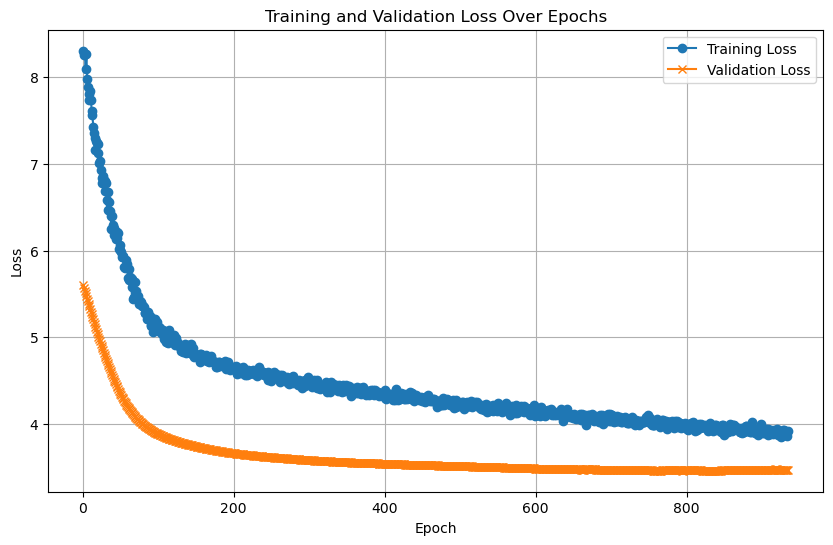

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/20], Loss: 5.8978
Test Batch [20/20], Loss: 4.8027

Test Loss: 5.3954


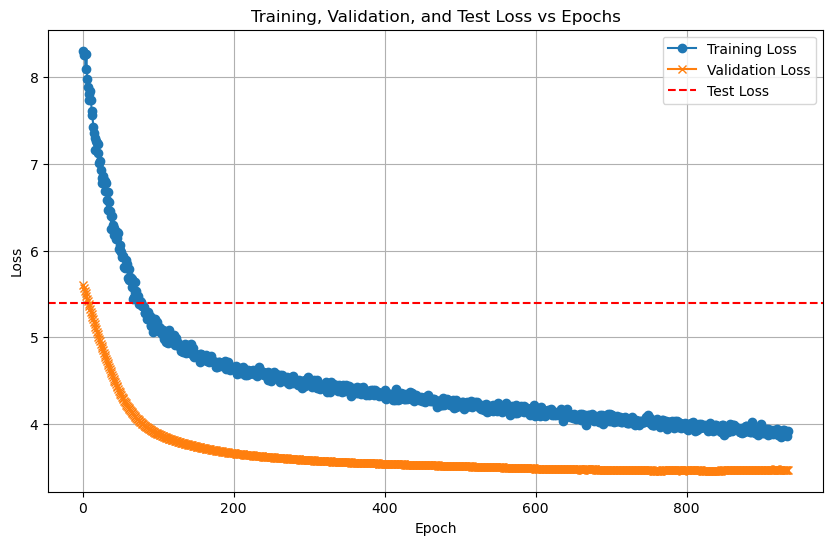

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/20 for test dataset.
  Processed batch 20/20 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 40.00%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.27      0.60      0.38         5
           1       0.00      0.00      0.00         5
           2       0.27      0.60      0.38         5
           3       0.00      0.00      0.00         5
           4       0.57      0.80      0.67         5
           5       0.00      0.00      0.00         5
           6       0.00      0.00      0.00         5
           7       0.29      0.40      0.33         5
           8       0.30      0.60      0.40         5
           9       0.00      0.00      0.00         5
          10       1.00      0.80      0.89         5
          11       0.40      0.40      0.40         5
          12       0.62      1.00      0.77         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.5315  |  Val Loss: 2.5289
Validation loss improved from inf to 2.5289.
[Epoch 2/1000] Train Loss: 2.5224  |  Val Loss: 2.5242
Validation loss improved from 2.5289 to 2.5242.
[Epoch 3/1000] Train Loss: 2.5161  |  Val Loss: 2.5180
Validation loss improved from 2.5242 to 2.5180.
[Epoch 4/1000] Train Loss: 2.5093  |  Val Loss: 2.5121
Validation loss improved from 2.5180 to 2.5121.
[Epoch 5/1000] Train Loss: 2.5027  |  Val Loss: 2.5069
Validation loss improved from 2.5121 to 2.5069.
[Epoch 6/1000] Train Loss: 2.4960  |  Val Loss: 2.5028
Validation loss improved from 2.5069 to 2.5028.
[Epoch 7/1000] Train Loss: 2.4903  |  Val Loss: 2.4994
Validation loss improved from 2.5028 to 2.4994.
[Epoch 8/1000] Train Loss: 2.4847  |  Val Loss: 2.4962
Validation loss improved from 2.4994 to 2.4962.
[Epoch 9/1000] Train Loss: 2.4801  |  Val Loss: 2.4931
Validation loss improved from 2.4962 to 2.4931.
[Epoch 10/1000] Train Loss: 2.4752  |  Val Loss: 2.4902
Validation loss impr

[Epoch 18/1000] Train Loss: 2.4507  |  Val Loss: 2.4814
Validation loss improved from 2.4820 to 2.4814.
[Epoch 19/1000] Train Loss: 2.4488  |  Val Loss: 2.4806
Validation loss improved from 2.4814 to 2.4806.
[Epoch 20/1000] Train Loss: 2.4466  |  Val Loss: 2.4796
Validation loss improved from 2.4806 to 2.4796.
[Epoch 21/1000] Train Loss: 2.4446  |  Val Loss: 2.4785
Validation loss improved from 2.4796 to 2.4785.
[Epoch 22/1000] Train Loss: 2.4426  |  Val Loss: 2.4780
Validation loss improved from 2.4785 to 2.4780.
[Epoch 23/1000] Train Loss: 2.4405  |  Val Loss: 2.4774
Validation loss improved from 2.4780 to 2.4774.
[Epoch 24/1000] Train Loss: 2.4385  |  Val Loss: 2.4766
Validation loss improved from 2.4774 to 2.4766.
[Epoch 25/1000] Train Loss: 2.4367  |  Val Loss: 2.4753
Validation loss improved from 2.4766 to 2.4753.
[Epoch 26/1000] Train Loss: 2.4349  |  Val Loss: 2.4736
Validation loss improved from 2.4753 to 2.4736.


[Epoch 27/1000] Train Loss: 2.4329  |  Val Loss: 2.4720
Validation loss improved from 2.4736 to 2.4720.
[Epoch 28/1000] Train Loss: 2.4313  |  Val Loss: 2.4705
Validation loss improved from 2.4720 to 2.4705.
[Epoch 29/1000] Train Loss: 2.4295  |  Val Loss: 2.4688
Validation loss improved from 2.4705 to 2.4688.
[Epoch 30/1000] Train Loss: 2.4277  |  Val Loss: 2.4666
Validation loss improved from 2.4688 to 2.4666.
[Epoch 31/1000] Train Loss: 2.4259  |  Val Loss: 2.4649
Validation loss improved from 2.4666 to 2.4649.
[Epoch 32/1000] Train Loss: 2.4242  |  Val Loss: 2.4634
Validation loss improved from 2.4649 to 2.4634.
[Epoch 33/1000] Train Loss: 2.4227  |  Val Loss: 2.4620
Validation loss improved from 2.4634 to 2.4620.
[Epoch 34/1000] Train Loss: 2.4213  |  Val Loss: 2.4606
Validation loss improved from 2.4620 to 2.4606.
[Epoch 35/1000] Train Loss: 2.4200  |  Val Loss: 2.4601
Validation loss improved from 2.4606 to 2.4601.
[Epoch 36/1000] Train Loss: 2.4181  |  Val Loss: 2.4620
!! Valid

[Epoch 49/1000] Train Loss: 2.3972  |  Val Loss: 2.4561
Validation loss improved from 2.4573 to 2.4561.
[Epoch 50/1000] Train Loss: 2.3957  |  Val Loss: 2.4552
Validation loss improved from 2.4561 to 2.4552.
[Epoch 51/1000] Train Loss: 2.3945  |  Val Loss: 2.4544
Validation loss improved from 2.4552 to 2.4544.
[Epoch 52/1000] Train Loss: 2.3932  |  Val Loss: 2.4535
Validation loss improved from 2.4544 to 2.4535.
[Epoch 53/1000] Train Loss: 2.3919  |  Val Loss: 2.4526
Validation loss improved from 2.4535 to 2.4526.
[Epoch 54/1000] Train Loss: 2.3904  |  Val Loss: 2.4508
Validation loss improved from 2.4526 to 2.4508.
[Epoch 55/1000] Train Loss: 2.3888  |  Val Loss: 2.4475
Validation loss improved from 2.4508 to 2.4475.
[Epoch 56/1000] Train Loss: 2.3874  |  Val Loss: 2.4445
Validation loss improved from 2.4475 to 2.4445.


[Epoch 57/1000] Train Loss: 2.3859  |  Val Loss: 2.4430
Validation loss improved from 2.4445 to 2.4430.
[Epoch 58/1000] Train Loss: 2.3840  |  Val Loss: 2.4433
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 59/1000] Train Loss: 2.3821  |  Val Loss: 2.4436
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 60/1000] Train Loss: 2.3802  |  Val Loss: 2.4438
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 61/1000] Train Loss: 2.3782  |  Val Loss: 2.4440
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 62/1000] Train Loss: 2.3769  |  Val Loss: 2.4446
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 63/1000] Train Loss: 2.3752  |  Val Loss: 2.4452
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 64/1000] Train Loss: 2.3738  |  Val Loss: 2.4461
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 65/1000] Train Loss: 2.3725  |  Val Loss: 2.4462
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 66/1000] 

[Epoch 76/1000] Train Loss: 2.3522  |  Val Loss: 2.4290
Validation loss improved from 2.4314 to 2.4290.
[Epoch 77/1000] Train Loss: 2.3499  |  Val Loss: 2.4267
Validation loss improved from 2.4290 to 2.4267.
[Epoch 78/1000] Train Loss: 2.3478  |  Val Loss: 2.4243
Validation loss improved from 2.4267 to 2.4243.
[Epoch 79/1000] Train Loss: 2.3458  |  Val Loss: 2.4229
Validation loss improved from 2.4243 to 2.4229.
[Epoch 80/1000] Train Loss: 2.3438  |  Val Loss: 2.4223
Validation loss improved from 2.4229 to 2.4223.
[Epoch 81/1000] Train Loss: 2.3418  |  Val Loss: 2.4219
Validation loss improved from 2.4223 to 2.4219.
[Epoch 82/1000] Train Loss: 2.3397  |  Val Loss: 2.4215
Validation loss improved from 2.4219 to 2.4215.
[Epoch 83/1000] Train Loss: 2.3376  |  Val Loss: 2.4206
Validation loss improved from 2.4215 to 2.4206.
[Epoch 84/1000] Train Loss: 2.3355  |  Val Loss: 2.4197
Validation loss improved from 2.4206 to 2.4197.
[Epoch 85/1000] Train Loss: 2.3336  |  Val Loss: 2.4185
Validati

[Epoch 92/1000] Train Loss: 2.3226  |  Val Loss: 2.4191
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 93/1000] Train Loss: 2.3194  |  Val Loss: 2.4130
Validation loss improved from 2.4170 to 2.4130.
[Epoch 94/1000] Train Loss: 2.3169  |  Val Loss: 2.4087
Validation loss improved from 2.4130 to 2.4087.
[Epoch 95/1000] Train Loss: 2.3147  |  Val Loss: 2.4055
Validation loss improved from 2.4087 to 2.4055.
[Epoch 96/1000] Train Loss: 2.3128  |  Val Loss: 2.4024
Validation loss improved from 2.4055 to 2.4024.
[Epoch 97/1000] Train Loss: 2.3105  |  Val Loss: 2.3978
Validation loss improved from 2.4024 to 2.3978.
[Epoch 98/1000] Train Loss: 2.3098  |  Val Loss: 2.3943
Validation loss improved from 2.3978 to 2.3943.
[Epoch 99/1000] Train Loss: 2.3083  |  Val Loss: 2.3923
Validation loss improved from 2.3943 to 2.3923.
[Epoch 100/1000] Train Loss: 2.3066  |  Val Loss: 2.3909
Validation loss improved from 2.3923 to 2.3909.
[Epoch 101/1000] Train Loss: 2.3050  |  Val Loss: 2.3889


[Epoch 109/1000] Train Loss: 2.2846  |  Val Loss: 2.3888
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 110/1000] Train Loss: 2.2824  |  Val Loss: 2.3882
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 111/1000] Train Loss: 2.2798  |  Val Loss: 2.3864
Validation loss improved from 2.3867 to 2.3864.
[Epoch 112/1000] Train Loss: 2.2776  |  Val Loss: 2.3828
Validation loss improved from 2.3864 to 2.3828.
[Epoch 113/1000] Train Loss: 2.2754  |  Val Loss: 2.3796
Validation loss improved from 2.3828 to 2.3796.
[Epoch 114/1000] Train Loss: 2.2730  |  Val Loss: 2.3775
Validation loss improved from 2.3796 to 2.3775.
[Epoch 115/1000] Train Loss: 2.2708  |  Val Loss: 2.3767
Validation loss improved from 2.3775 to 2.3767.
[Epoch 116/1000] Train Loss: 2.2679  |  Val Loss: 2.3758
Validation loss improved from 2.3767 to 2.3758.
[Epoch 117/1000] Train Loss: 2.2651  |  Val Loss: 2.3771
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 118/1000] Train Loss: 2.2621  

[Epoch 122/1000] Train Loss: 2.2519  |  Val Loss: 2.3754
Validation loss improved from 2.3758 to 2.3754.
[Epoch 123/1000] Train Loss: 2.2492  |  Val Loss: 2.3735
Validation loss improved from 2.3754 to 2.3735.
[Epoch 124/1000] Train Loss: 2.2466  |  Val Loss: 2.3717
Validation loss improved from 2.3735 to 2.3717.
[Epoch 125/1000] Train Loss: 2.2441  |  Val Loss: 2.3702
Validation loss improved from 2.3717 to 2.3702.
[Epoch 126/1000] Train Loss: 2.2414  |  Val Loss: 2.3690
Validation loss improved from 2.3702 to 2.3690.
[Epoch 127/1000] Train Loss: 2.2388  |  Val Loss: 2.3653
Validation loss improved from 2.3690 to 2.3653.
[Epoch 128/1000] Train Loss: 2.2369  |  Val Loss: 2.3594
Validation loss improved from 2.3653 to 2.3594.
[Epoch 129/1000] Train Loss: 2.2357  |  Val Loss: 2.3574
Validation loss improved from 2.3594 to 2.3574.
[Epoch 130/1000] Train Loss: 2.2333  |  Val Loss: 2.3580
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 131/1000] Train Loss: 2.2303  |  Val Loss:

[Epoch 138/1000] Train Loss: 2.2112  |  Val Loss: 2.3696
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 139/1000] Train Loss: 2.2078  |  Val Loss: 2.3675
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 140/1000] Train Loss: 2.2049  |  Val Loss: 2.3653
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 141/1000] Train Loss: 2.2022  |  Val Loss: 2.3634
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 142/1000] Train Loss: 2.1994  |  Val Loss: 2.3615
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 143/1000] Train Loss: 2.1968  |  Val Loss: 2.3595
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 144/1000] Train Loss: 2.1942  |  Val Loss: 2.3584
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 145/1000] Train Loss: 2.1916  |  Val Loss: 2.3586
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 146/1000] Train Loss: 2.1889  |  Val Loss: 2.3582
!! Validation loss did NOT improve !! Patience: 

[Epoch 151/1000] Train Loss: 2.1736  |  Val Loss: 2.3494
Validation loss improved from 2.3512 to 2.3494.
[Epoch 152/1000] Train Loss: 2.1706  |  Val Loss: 2.3474
Validation loss improved from 2.3494 to 2.3474.
[Epoch 153/1000] Train Loss: 2.1678  |  Val Loss: 2.3449
Validation loss improved from 2.3474 to 2.3449.
[Epoch 154/1000] Train Loss: 2.1649  |  Val Loss: 2.3439
Validation loss improved from 2.3449 to 2.3439.
[Epoch 155/1000] Train Loss: 2.1623  |  Val Loss: 2.3466
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 156/1000] Train Loss: 2.1597  |  Val Loss: 2.3482
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 157/1000] Train Loss: 2.1574  |  Val Loss: 2.3492
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 158/1000] Train Loss: 2.1548  |  Val Loss: 2.3489
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 159/1000] Train Loss: 2.1518  |  Val Loss: 2.3476
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 160/1000] Train Lo

[Epoch 166/1000] Train Loss: 2.1292  |  Val Loss: 2.3338
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 167/1000] Train Loss: 2.1265  |  Val Loss: 2.3363
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 168/1000] Train Loss: 2.1241  |  Val Loss: 2.3410
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 169/1000] Train Loss: 2.1220  |  Val Loss: 2.3426
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 170/1000] Train Loss: 2.1193  |  Val Loss: 2.3415
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 171/1000] Train Loss: 2.1164  |  Val Loss: 2.3386
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 172/1000] Train Loss: 2.1129  |  Val Loss: 2.3345
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 173/1000] Train Loss: 2.1094  |  Val Loss: 2.3300
Validation loss improved from 2.3309 to 2.3300.
[Epoch 174/1000] Train Loss: 2.1055  |  Val Loss: 2.3253
Validation loss improved from 2.3300 to 2.3253.
[Epoch 175/10

[Epoch 179/1000] Train Loss: 2.0875  |  Val Loss: 2.3043
Validation loss improved from 2.3067 to 2.3043.
[Epoch 180/1000] Train Loss: 2.0844  |  Val Loss: 2.3032
Validation loss improved from 2.3043 to 2.3032.
[Epoch 181/1000] Train Loss: 2.0809  |  Val Loss: 2.3023
Validation loss improved from 2.3032 to 2.3023.
[Epoch 182/1000] Train Loss: 2.0780  |  Val Loss: 2.2976
Validation loss improved from 2.3023 to 2.2976.
[Epoch 183/1000] Train Loss: 2.0752  |  Val Loss: 2.2894
Validation loss improved from 2.2976 to 2.2894.
[Epoch 184/1000] Train Loss: 2.0716  |  Val Loss: 2.2888
Validation loss improved from 2.2894 to 2.2888.
[Epoch 185/1000] Train Loss: 2.0682  |  Val Loss: 2.2889
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 186/1000] Train Loss: 2.0649  |  Val Loss: 2.2902
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 187/1000] Train Loss: 2.0618  |  Val Loss: 2.2908
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 188/1000] Train Loss: 2.0590  

[Epoch 196/1000] Train Loss: 2.0335  |  Val Loss: 2.2848
Validation loss improved from 2.2854 to 2.2848.
[Epoch 197/1000] Train Loss: 2.0297  |  Val Loss: 2.2735
Validation loss improved from 2.2848 to 2.2735.
[Epoch 198/1000] Train Loss: 2.0265  |  Val Loss: 2.2653
Validation loss improved from 2.2735 to 2.2653.
[Epoch 199/1000] Train Loss: 2.0239  |  Val Loss: 2.2576
Validation loss improved from 2.2653 to 2.2576.
[Epoch 200/1000] Train Loss: 2.0220  |  Val Loss: 2.2489
Validation loss improved from 2.2576 to 2.2489.
[Epoch 201/1000] Train Loss: 2.0209  |  Val Loss: 2.2435
Validation loss improved from 2.2489 to 2.2435.
[Epoch 202/1000] Train Loss: 2.0209  |  Val Loss: 2.2411
Validation loss improved from 2.2435 to 2.2411.
[Epoch 203/1000] Train Loss: 2.0196  |  Val Loss: 2.2397
Validation loss improved from 2.2411 to 2.2397.


[Epoch 204/1000] Train Loss: 2.0163  |  Val Loss: 2.2392
Validation loss improved from 2.2397 to 2.2392.
[Epoch 205/1000] Train Loss: 2.0120  |  Val Loss: 2.2388
Validation loss improved from 2.2392 to 2.2388.
[Epoch 206/1000] Train Loss: 2.0068  |  Val Loss: 2.2374
Validation loss improved from 2.2388 to 2.2374.
[Epoch 207/1000] Train Loss: 2.0016  |  Val Loss: 2.2370
Validation loss improved from 2.2374 to 2.2370.
[Epoch 208/1000] Train Loss: 1.9969  |  Val Loss: 2.2374
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 209/1000] Train Loss: 1.9917  |  Val Loss: 2.2383
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 210/1000] Train Loss: 1.9877  |  Val Loss: 2.2397
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 211/1000] Train Loss: 1.9837  |  Val Loss: 2.2405
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 212/1000] Train Loss: 1.9801  |  Val Loss: 2.2404
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 213/1000] Train Lo

[Epoch 227/1000] Train Loss: 1.9310  |  Val Loss: 2.2108
Validation loss improved from 2.2114 to 2.2108.
[Epoch 228/1000] Train Loss: 1.9276  |  Val Loss: 2.2116
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 229/1000] Train Loss: 1.9237  |  Val Loss: 2.2119
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 230/1000] Train Loss: 1.9204  |  Val Loss: 2.2119
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 231/1000] Train Loss: 1.9170  |  Val Loss: 2.2125
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 232/1000] Train Loss: 1.9134  |  Val Loss: 2.2145
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 233/1000] Train Loss: 1.9093  |  Val Loss: 2.2162
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 234/1000] Train Loss: 1.9056  |  Val Loss: 2.2166
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 235/1000] Train Loss: 1.9016  |  Val Loss: 2.2155
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 237/1000] Train Loss: 1.8943  |  Val Loss: 2.2111
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 238/1000] Train Loss: 1.8911  |  Val Loss: 2.2120
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 239/1000] Train Loss: 1.8885  |  Val Loss: 2.2188
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 240/1000] Train Loss: 1.8850  |  Val Loss: 2.2230
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 241/1000] Train Loss: 1.8824  |  Val Loss: 2.2244
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 242/1000] Train Loss: 1.8797  |  Val Loss: 2.2227
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 243/1000] Train Loss: 1.8763  |  Val Loss: 2.2190
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 244/1000] Train Loss: 1.8727  |  Val Loss: 2.2145
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 245/1000] Train Loss: 1.8697  |  Val Loss: 2.2092
Validation loss improved from 2.2108 to 2.2092.

[Epoch 260/1000] Train Loss: 1.8191  |  Val Loss: 2.1670
Validation loss improved from 2.1700 to 2.1670.
[Epoch 261/1000] Train Loss: 1.8162  |  Val Loss: 2.1640
Validation loss improved from 2.1670 to 2.1640.
[Epoch 262/1000] Train Loss: 1.8132  |  Val Loss: 2.1622
Validation loss improved from 2.1640 to 2.1622.
[Epoch 263/1000] Train Loss: 1.8101  |  Val Loss: 2.1640
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 264/1000] Train Loss: 1.8066  |  Val Loss: 2.1713
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 265/1000] Train Loss: 1.8032  |  Val Loss: 2.1761
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 266/1000] Train Loss: 1.8002  |  Val Loss: 2.1791
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 267/1000] Train Loss: 1.7975  |  Val Loss: 2.1805
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 268/1000] Train Loss: 1.7945  |  Val Loss: 2.1816
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 269/1000] Tr

[Epoch 272/1000] Train Loss: 1.7812  |  Val Loss: 2.1675
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 273/1000] Train Loss: 1.7777  |  Val Loss: 2.1620
Validation loss improved from 2.1622 to 2.1620.
[Epoch 274/1000] Train Loss: 1.7743  |  Val Loss: 2.1581
Validation loss improved from 2.1620 to 2.1581.
[Epoch 275/1000] Train Loss: 1.7709  |  Val Loss: 2.1500
Validation loss improved from 2.1581 to 2.1500.
[Epoch 276/1000] Train Loss: 1.7678  |  Val Loss: 2.1376
Validation loss improved from 2.1500 to 2.1376.
[Epoch 277/1000] Train Loss: 1.7670  |  Val Loss: 2.1288
Validation loss improved from 2.1376 to 2.1288.
[Epoch 278/1000] Train Loss: 1.7647  |  Val Loss: 2.1236
Validation loss improved from 2.1288 to 2.1236.
[Epoch 279/1000] Train Loss: 1.7620  |  Val Loss: 2.1202
Validation loss improved from 2.1236 to 2.1202.
[Epoch 280/1000] Train Loss: 1.7582  |  Val Loss: 2.1208
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 281/1000] Train Loss: 1.7538  |  Va

[Epoch 291/1000] Train Loss: 1.7226  |  Val Loss: 2.1394
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 292/1000] Train Loss: 1.7191  |  Val Loss: 2.1373
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 293/1000] Train Loss: 1.7155  |  Val Loss: 2.1378
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 294/1000] Train Loss: 1.7125  |  Val Loss: 2.1410
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 295/1000] Train Loss: 1.7092  |  Val Loss: 2.1413
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 296/1000] Train Loss: 1.7061  |  Val Loss: 2.1395
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 297/1000] Train Loss: 1.7031  |  Val Loss: 2.1372
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 298/1000] Train Loss: 1.7000  |  Val Loss: 2.1353
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 299/1000] Train Loss: 1.6966  |  Val Loss: 2.1331
!! Validation loss did NOT improve !! Patience:

[Epoch 300/1000] Train Loss: 1.6932  |  Val Loss: 2.1269
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 301/1000] Train Loss: 1.6897  |  Val Loss: 2.1141
Validation loss improved from 2.1202 to 2.1141.
[Epoch 302/1000] Train Loss: 1.6861  |  Val Loss: 2.1077
Validation loss improved from 2.1141 to 2.1077.
[Epoch 303/1000] Train Loss: 1.6829  |  Val Loss: 2.1079
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 304/1000] Train Loss: 1.6798  |  Val Loss: 2.1086
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 305/1000] Train Loss: 1.6767  |  Val Loss: 2.1097
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 306/1000] Train Loss: 1.6736  |  Val Loss: 2.1120
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 307/1000] Train Loss: 1.6706  |  Val Loss: 2.1151
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 308/1000] Train Loss: 1.6684  |  Val Loss: 2.1149
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 309/1

[Epoch 319/1000] Train Loss: 1.6340  |  Val Loss: 2.0977
Validation loss improved from 2.0979 to 2.0977.
[Epoch 320/1000] Train Loss: 1.6309  |  Val Loss: 2.0960
Validation loss improved from 2.0977 to 2.0960.
[Epoch 321/1000] Train Loss: 1.6280  |  Val Loss: 2.0956
Validation loss improved from 2.0960 to 2.0956.
[Epoch 322/1000] Train Loss: 1.6251  |  Val Loss: 2.0958
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 323/1000] Train Loss: 1.6221  |  Val Loss: 2.0976
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 324/1000] Train Loss: 1.6196  |  Val Loss: 2.1003
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 325/1000] Train Loss: 1.6171  |  Val Loss: 2.1022
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 326/1000] Train Loss: 1.6143  |  Val Loss: 2.1018
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 327/1000] Train Loss: 1.6114  |  Val Loss: 2.1005
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 328/1000] Tr

[Epoch 334/1000] Train Loss: 1.5942  |  Val Loss: 2.0936
Validation loss improved from 2.0956 to 2.0936.
[Epoch 335/1000] Train Loss: 1.5912  |  Val Loss: 2.0916
Validation loss improved from 2.0936 to 2.0916.
[Epoch 336/1000] Train Loss: 1.5878  |  Val Loss: 2.0889
Validation loss improved from 2.0916 to 2.0889.
[Epoch 337/1000] Train Loss: 1.5850  |  Val Loss: 2.0864
Validation loss improved from 2.0889 to 2.0864.
[Epoch 338/1000] Train Loss: 1.5819  |  Val Loss: 2.0848
Validation loss improved from 2.0864 to 2.0848.
[Epoch 339/1000] Train Loss: 1.5787  |  Val Loss: 2.0849
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 340/1000] Train Loss: 1.5758  |  Val Loss: 2.0839
Validation loss improved from 2.0848 to 2.0839.
[Epoch 341/1000] Train Loss: 1.5731  |  Val Loss: 2.0807
Validation loss improved from 2.0839 to 2.0807.
[Epoch 342/1000] Train Loss: 1.5704  |  Val Loss: 2.0781
Validation loss improved from 2.0807 to 2.0781.
[Epoch 343/1000] Train Loss: 1.5677  |  Val Loss:

[Epoch 348/1000] Train Loss: 1.5523  |  Val Loss: 2.1040
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 349/1000] Train Loss: 1.5502  |  Val Loss: 2.1154
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 350/1000] Train Loss: 1.5464  |  Val Loss: 2.1229
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 351/1000] Train Loss: 1.5442  |  Val Loss: 2.1221
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 352/1000] Train Loss: 1.5413  |  Val Loss: 2.1180
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 353/1000] Train Loss: 1.5384  |  Val Loss: 2.1168
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 354/1000] Train Loss: 1.5356  |  Val Loss: 2.1170
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 355/1000] Train Loss: 1.5343  |  Val Loss: 2.1168
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 356/1000] Train Loss: 1.5322  |  Val Loss: 2.1157
!! Validation loss did NOT improve !! Patience: 14/

[Epoch 361/1000] Train Loss: 1.5162  |  Val Loss: 2.0803
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 362/1000] Train Loss: 1.5143  |  Val Loss: 2.0782
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 363/1000] Train Loss: 1.5124  |  Val Loss: 2.0778
Validation loss improved from 2.0781 to 2.0778.
[Epoch 364/1000] Train Loss: 1.5099  |  Val Loss: 2.0785
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 365/1000] Train Loss: 1.5074  |  Val Loss: 2.0788
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 366/1000] Train Loss: 1.5048  |  Val Loss: 2.0760
Validation loss improved from 2.0778 to 2.0760.
[Epoch 367/1000] Train Loss: 1.5030  |  Val Loss: 2.0715
Validation loss improved from 2.0760 to 2.0715.
[Epoch 368/1000] Train Loss: 1.5019  |  Val Loss: 2.0685
Validation loss improved from 2.0715 to 2.0685.
[Epoch 369/1000] Train Loss: 1.5012  |  Val Loss: 2.0698
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 370/1000] Train 

[Epoch 382/1000] Train Loss: 1.4672  |  Val Loss: 2.1423
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 383/1000] Train Loss: 1.4652  |  Val Loss: 2.1421
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 384/1000] Train Loss: 1.4625  |  Val Loss: 2.1415
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 385/1000] Train Loss: 1.4608  |  Val Loss: 2.1413
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 386/1000] Train Loss: 1.4591  |  Val Loss: 2.1395
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 387/1000] Train Loss: 1.4583  |  Val Loss: 2.1365
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 388/1000] Train Loss: 1.4566  |  Val Loss: 2.1332
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 389/1000] Train Loss: 1.4550  |  Val Loss: 2.1207
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 390/1000] Train Loss: 1.4495  |  Val Loss: 2.1024
!! Validation loss did NOT improve !! Patience:

[Epoch 393/1000] Train Loss: 1.4413  |  Val Loss: 2.0807
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 394/1000] Train Loss: 1.4392  |  Val Loss: 2.0786
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 395/1000] Train Loss: 1.4374  |  Val Loss: 2.0786
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 396/1000] Train Loss: 1.4353  |  Val Loss: 2.0806
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 397/1000] Train Loss: 1.4332  |  Val Loss: 2.0842
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 398/1000] Train Loss: 1.4308  |  Val Loss: 2.0905
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 399/1000] Train Loss: 1.4280  |  Val Loss: 2.0945
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 400/1000] Train Loss: 1.4253  |  Val Loss: 2.0958
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 401/1000] Train Loss: 1.4227  |  Val Loss: 2.0966
!! Validation loss did NOT improve !! Patience:

[Epoch 413/1000] Train Loss: 1.3967  |  Val Loss: 2.1171
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 414/1000] Train Loss: 1.3949  |  Val Loss: 2.1207
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 415/1000] Train Loss: 1.3932  |  Val Loss: 2.1255
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 416/1000] Train Loss: 1.3911  |  Val Loss: 2.1333
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 417/1000] Train Loss: 1.3893  |  Val Loss: 2.1373
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 418/1000] Train Loss: 1.3875  |  Val Loss: 2.1385
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 419/1000] Train Loss: 1.3853  |  Val Loss: 2.1377
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 420/1000] Train Loss: 1.3831  |  Val Loss: 2.1361
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 421/1000] Train Loss: 1.3810  |  Val Loss: 2.1343
!! Validation loss did NOT improve !! Patience:

[Epoch 424/1000] Train Loss: 1.3747  |  Val Loss: 2.1403
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 425/1000] Train Loss: 1.3728  |  Val Loss: 2.1461
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 426/1000] Train Loss: 1.3710  |  Val Loss: 2.1507
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 427/1000] Train Loss: 1.3689  |  Val Loss: 2.1517
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 428/1000] Train Loss: 1.3669  |  Val Loss: 2.1504
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 429/1000] Train Loss: 1.3648  |  Val Loss: 2.1472
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 430/1000] Train Loss: 1.3627  |  Val Loss: 2.1446
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 431/1000] Train Loss: 1.3606  |  Val Loss: 2.1428
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 432/1000] Train Loss: 1.3583  |  Val Loss: 2.1415
!! Validation loss did NOT improve !! Patience:

[Epoch 445/1000] Train Loss: 1.3395  |  Val Loss: 2.0875
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 446/1000] Train Loss: 1.3380  |  Val Loss: 2.0889
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 447/1000] Train Loss: 1.3361  |  Val Loss: 2.0913
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 448/1000] Train Loss: 1.3336  |  Val Loss: 2.0945
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 449/1000] Train Loss: 1.3313  |  Val Loss: 2.0984
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 450/1000] Train Loss: 1.3289  |  Val Loss: 2.1006
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 451/1000] Train Loss: 1.3266  |  Val Loss: 2.1013
!! Validation loss did NOT improve !! Patience: 83/100


[Epoch 452/1000] Train Loss: 1.3246  |  Val Loss: 2.1022
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 453/1000] Train Loss: 1.3227  |  Val Loss: 2.1037
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 454/1000] Train Loss: 1.3210  |  Val Loss: 2.1065
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 455/1000] Train Loss: 1.3189  |  Val Loss: 2.1089
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 456/1000] Train Loss: 1.3171  |  Val Loss: 2.1139
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 457/1000] Train Loss: 1.3155  |  Val Loss: 2.1235
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 458/1000] Train Loss: 1.3150  |  Val Loss: 2.1376
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 459/1000] Train Loss: 1.3133  |  Val Loss: 2.1532
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 460/1000] Train Loss: 1.3118  |  Val Loss: 2.1734
!! Validation loss did NOT improve !! Patience:

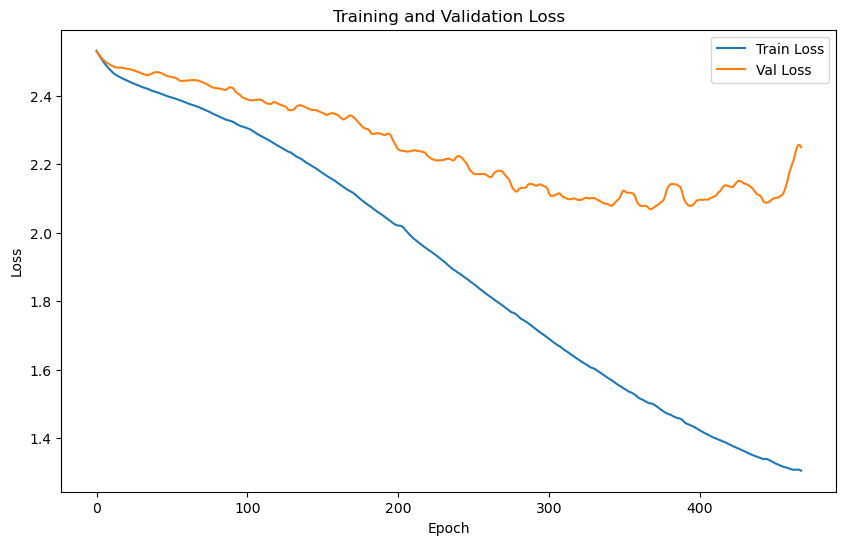

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 2.1547 | Test Accuracy: 49.10%


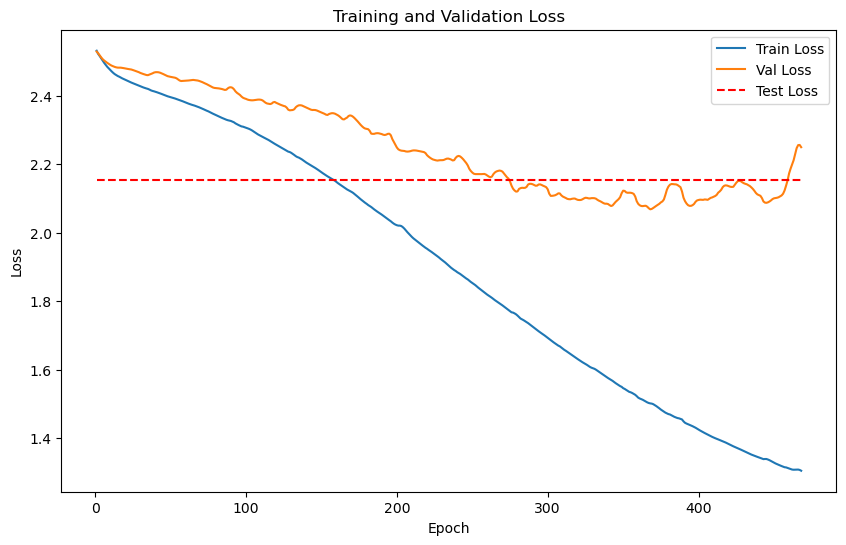

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 130 samples with 64 features each
LOG: Labels shape: (130,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 65 samples with 64 features each
LOG: Labels shape: (65,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 5016 samples with 64 features each
LOG: Labels shape: (5016,)


Train embeddings shape: (130, 64), 
Train labels shape: (130,)


Val embeddings shape: (65, 64), 
Val labels shape: (65,)


Test embeddings shape: (5016, 64), 
Test labels shape: (5016,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 10, 1: 10, 2: 10, 3: 10, 4: 10, 5: 10, 6: 10, 7: 10, 8: 10, 9: 10, 10: 10, 11: 10, 12: 10}
Training batch size: 130


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.5406
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.6099
    Batch [2/2], Val Loss: 0.5000
Epoch [1/2000], Avg Train Loss: 0.5406, Avg Val Loss: 0.5550

Validation loss improved from inf to 0.5550. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.5422
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.6089
    Batch [2/2], Val Loss: 0.5000
Epoch [2/2000], Avg Train Loss: 0.5422, Avg Val Loss: 0.5545

Validation loss improved from 0.5550 to 0.5545. Saving model...
LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 0.5434
LOG: Epoch [3/2000] - Validation


    Batch [1/2], Val Loss: 0.6086
    Batch [2/2], Val Loss: 0.5000
Epoch [3/2000], Avg Train Loss: 0.5434, Avg Val Loss: 0.5543

Validation loss improved from 0.5545 to 0.5543. Saving model...
LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 0.5434
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.6080
    Batch [2/2], Val Loss: 0.5000
Epoch [4/2000], Avg Train Loss: 0.5434, Avg Val Loss: 0.5540

Validation loss improved from 0.5543 to 0.5540. Saving model...
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.5398
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.6066
    Batch [2/2], Val Loss: 0.5000
Epoch [5/2000], Avg Train Loss: 0.5398, Avg Val Loss: 0.5533

Validation loss improved from 0.5540 to 0.5533. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/1], Train Loss: 0.5376
LOG: Epoch [6/2000] - Validation


    Batch [1/2], Val Loss: 0.6053
    Batch [2/2], Val Loss: 0.5000
Epoch [6/2000], Avg Train Loss: 0.5376, Avg Val Loss: 0.5527

Validation loss improved from 0.5533 to 0.5527. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/1], Train Loss: 0.5342
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.6044
    Batch [2/2], Val Loss: 0.5000
Epoch [7/2000], Avg Train Loss: 0.5342, Avg Val Loss: 0.5522

Validation loss improved from 0.5527 to 0.5522. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.5391
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.6035
    Batch [2/2], Val Loss: 0.5000
Epoch [8/2000], Avg Train Loss: 0.5391, Avg Val Loss: 0.5517

Validation loss improved from 0.5522 to 0.5517. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/1], Train Loss: 0.5375
LOG: Epoch [9/2000] - Validation


    Batch [1/2], Val Loss: 0.6024
    Batch [2/2], Val Loss: 0.5000
Epoch [9/2000], Avg Train Loss: 0.5375, Avg Val Loss: 0.5512

Validation loss improved from 0.5517 to 0.5512. Saving model...
LOG: Epoch [10/2000] - Training
    Batch [1/1], Train Loss: 0.5328
LOG: Epoch [10/2000] - Validation


    Batch [1/2], Val Loss: 0.6011
    Batch [2/2], Val Loss: 0.5000
Epoch [10/2000], Avg Train Loss: 0.5328, Avg Val Loss: 0.5505

Validation loss improved from 0.5512 to 0.5505. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/1], Train Loss: 0.5265
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.5995
    Batch [2/2], Val Loss: 0.5000
Epoch [11/2000], Avg Train Loss: 0.5265, Avg Val Loss: 0.5498

Validation loss improved from 0.5505 to 0.5498. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.5285
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.5977
    Batch [2/2], Val Loss: 0.5000
Epoch [12/2000], Avg Train Loss: 0.5285, Avg Val Loss: 0.5488

Validation loss improved from 0.5498 to 0.5488. Saving model...
LOG: Epoch [13/2000] - Training
    Batch [1/1], Train Loss: 0.5304
LOG: Epoch [13/2000] - Validation


    Batch [1/2], Val Loss: 0.5968
    Batch [2/2], Val Loss: 0.5000
Epoch [13/2000], Avg Train Loss: 0.5304, Avg Val Loss: 0.5484

Validation loss improved from 0.5488 to 0.5484. Saving model...
LOG: Epoch [14/2000] - Training
    Batch [1/1], Train Loss: 0.5265
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.5955
    Batch [2/2], Val Loss: 0.5000
Epoch [14/2000], Avg Train Loss: 0.5265, Avg Val Loss: 0.5477

Validation loss improved from 0.5484 to 0.5477. Saving model...
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.5243
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.5938
    Batch [2/2], Val Loss: 0.5000
Epoch [15/2000], Avg Train Loss: 0.5243, Avg Val Loss: 0.5469

Validation loss improved from 0.5477 to 0.5469. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/1], Train Loss: 0.5227
LOG: Epoch [16/2000] - Validation


    Batch [1/2], Val Loss: 0.5920
    Batch [2/2], Val Loss: 0.5000
Epoch [16/2000], Avg Train Loss: 0.5227, Avg Val Loss: 0.5460

Validation loss improved from 0.5469 to 0.5460. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/1], Train Loss: 0.5225
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.5903
    Batch [2/2], Val Loss: 0.5000
Epoch [17/2000], Avg Train Loss: 0.5225, Avg Val Loss: 0.5451

Validation loss improved from 0.5460 to 0.5451. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.5208
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.5883
    Batch [2/2], Val Loss: 0.5000
Epoch [18/2000], Avg Train Loss: 0.5208, Avg Val Loss: 0.5442

Validation loss improved from 0.5451 to 0.5442. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.5252
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.5859
    Batch [2/2], Val Loss: 0.5000
Epoch [19/2000], Avg Train Loss: 0.5252, Avg Val Loss: 0.5430

Validation loss improved from 0.5442 to 0.5430. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/1], Train Loss: 0.5257
LOG: Epoch [20/2000] - Validation


    Batch [1/2], Val Loss: 0.5838
    Batch [2/2], Val Loss: 0.5000
Epoch [20/2000], Avg Train Loss: 0.5257, Avg Val Loss: 0.5419

Validation loss improved from 0.5430 to 0.5419. Saving model...
LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 0.5213
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.5822
    Batch [2/2], Val Loss: 0.5000
Epoch [21/2000], Avg Train Loss: 0.5213, Avg Val Loss: 0.5411

Validation loss improved from 0.5419 to 0.5411. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.5261
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.5805
    Batch [2/2], Val Loss: 0.5000
Epoch [22/2000], Avg Train Loss: 0.5261, Avg Val Loss: 0.5402

Validation loss improved from 0.5411 to 0.5402. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.5213
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.5787
    Batch [2/2], Val Loss: 0.5000
Epoch [23/2000], Avg Train Loss: 0.5213, Avg Val Loss: 0.5393

Validation loss improved from 0.5402 to 0.5393. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.5216
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.5776
    Batch [2/2], Val Loss: 0.5000
Epoch [24/2000], Avg Train Loss: 0.5216, Avg Val Loss: 0.5388

Validation loss improved from 0.5393 to 0.5388. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.5184
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.5761
    Batch [2/2], Val Loss: 0.5000
Epoch [25/2000], Avg Train Loss: 0.5184, Avg Val Loss: 0.5380

Validation loss improved from 0.5388 to 0.5380. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.5208
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.5748
    Batch [2/2], Val Loss: 0.5000
Epoch [26/2000], Avg Train Loss: 0.5208, Avg Val Loss: 0.5374

Validation loss improved from 0.5380 to 0.5374. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/1], Train Loss: 0.5212
LOG: Epoch [27/2000] - Validation


    Batch [1/2], Val Loss: 0.5732
    Batch [2/2], Val Loss: 0.5000
Epoch [27/2000], Avg Train Loss: 0.5212, Avg Val Loss: 0.5366

Validation loss improved from 0.5374 to 0.5366. Saving model...
LOG: Epoch [28/2000] - Training
    Batch [1/1], Train Loss: 0.5165
LOG: Epoch [28/2000] - Validation


    Batch [1/2], Val Loss: 0.5716
    Batch [2/2], Val Loss: 0.5000
Epoch [28/2000], Avg Train Loss: 0.5165, Avg Val Loss: 0.5358

Validation loss improved from 0.5366 to 0.5358. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.5202
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.5701
    Batch [2/2], Val Loss: 0.5000
Epoch [29/2000], Avg Train Loss: 0.5202, Avg Val Loss: 0.5350

Validation loss improved from 0.5358 to 0.5350. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.5159
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.5685
    Batch [2/2], Val Loss: 0.5000
Epoch [30/2000], Avg Train Loss: 0.5159, Avg Val Loss: 0.5343

Validation loss improved from 0.5350 to 0.5343. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.5172
LOG: Epoch [31/2000] - Validation
    Batch [1/2], Val Loss: 0.5669
    Batch [2/2], Val Loss: 0.5000
Epoch [31/2000], Avg Train Loss: 0.5172, Avg Val Loss: 0.5335

Validation loss improved from 0.5343 to 0.5335. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.5162
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.5657
    Batch [2/2], Val Loss: 0.5000
Epoch [32/2000], Avg Train Loss: 0.5162, Avg Val Loss: 0.5329

Validation loss improved from 0.5335 to 0.5329. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.5139
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.5645
    Batch [2/2], Val Loss: 0.5000
Epoch [33/2000], Avg Train Loss: 0.5139, Avg Val Loss: 0.5323

Validation loss improved from 0.5329 to 0.5323. Saving model...
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.5140
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.5636
    Batch [2/2], Val Loss: 0.5000
Epoch [34/2000], Avg Train Loss: 0.5140, Avg Val Loss: 0.5318

Validation loss improved from 0.5323 to 0.5318. Saving model...
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.5165
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.5627
    Batch [2/2], Val Loss: 0.5000
Epoch [35/2000], Avg Train Loss: 0.5165, Avg Val Loss: 0.5313

Validation loss improved from 0.5318 to 0.5313. Saving model...
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.5153
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.5616
    Batch [2/2], Val Loss: 0.5000
Epoch [36/2000], Avg Train Loss: 0.5153, Avg Val Loss: 0.5308

Validation loss improved from 0.5313 to 0.5308. Saving model...
LOG: Epoch [37/2000] - Training


    Batch [1/1], Train Loss: 0.5131
LOG: Epoch [37/2000] - Validation
    Batch [1/2], Val Loss: 0.5604
    Batch [2/2], Val Loss: 0.5000
Epoch [37/2000], Avg Train Loss: 0.5131, Avg Val Loss: 0.5302

Validation loss improved from 0.5308 to 0.5302. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.5152
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.5593
    Batch [2/2], Val Loss: 0.5000
Epoch [38/2000], Avg Train Loss: 0.5152, Avg Val Loss: 0.5297

Validation loss improved from 0.5302 to 0.5297. Saving model...
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.5101
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.5582
    Batch [2/2], Val Loss: 0.5000
Epoch [39/2000], Avg Train Loss: 0.5101, Avg Val Loss: 0.5291

Validation loss improved from 0.5297 to 0.5291. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.5120
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.5571
    Batch [2/2], Val Loss: 0.5000
Epoch [40/2000], Avg Train Loss: 0.5120, Avg Val Loss: 0.5286

Validation loss improved from 0.5291 to 0.5286. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.5125
LOG: Epoch [41/2000] - Validation


    Batch [1/2], Val Loss: 0.5559
    Batch [2/2], Val Loss: 0.5000
Epoch [41/2000], Avg Train Loss: 0.5125, Avg Val Loss: 0.5279

Validation loss improved from 0.5286 to 0.5279. Saving model...
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.5115
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.5546
    Batch [2/2], Val Loss: 0.5000
Epoch [42/2000], Avg Train Loss: 0.5115, Avg Val Loss: 0.5273

Validation loss improved from 0.5279 to 0.5273. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.5113
LOG: Epoch [43/2000] - Validation
    Batch [1/2], Val Loss: 0.5534
    Batch [2/2], Val Loss: 0.5000
Epoch [43/2000], Avg Train Loss: 0.5113, Avg Val Loss: 0.5267

Validation loss improved from 0.5273 to 0.5267. Saving model...
LOG: Epoch [44/2000] - Training


    Batch [1/1], Train Loss: 0.5125
LOG: Epoch [44/2000] - Validation
    Batch [1/2], Val Loss: 0.5521
    Batch [2/2], Val Loss: 0.5000
Epoch [44/2000], Avg Train Loss: 0.5125, Avg Val Loss: 0.5261

Validation loss improved from 0.5267 to 0.5261. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.5085
LOG: Epoch [45/2000] - Validation


    Batch [1/2], Val Loss: 0.5510
    Batch [2/2], Val Loss: 0.5000
Epoch [45/2000], Avg Train Loss: 0.5085, Avg Val Loss: 0.5255

Validation loss improved from 0.5261 to 0.5255. Saving model...
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.5106
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.5500
    Batch [2/2], Val Loss: 0.5000
Epoch [46/2000], Avg Train Loss: 0.5106, Avg Val Loss: 0.5250

Validation loss improved from 0.5255 to 0.5250. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.5120
LOG: Epoch [47/2000] - Validation
    Batch [1/2], Val Loss: 0.5489
    Batch [2/2], Val Loss: 0.5000
Epoch [47/2000], Avg Train Loss: 0.5120, Avg Val Loss: 0.5244

Validation loss improved from 0.5250 to 0.5244. Saving model...
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.5093
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.5478
    Batch [2/2], Val Loss: 0.5000
Epoch [48/2000], Avg Train Loss: 0.5093, Avg Val Loss: 0.5239

Validation loss improved from 0.5244 to 0.5239. Saving model...
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.5110
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.5468
    Batch [2/2], Val Loss: 0.5000
Epoch [49/2000], Avg Train Loss: 0.5110, Avg Val Loss: 0.5234

Validation loss improved from 0.5239 to 0.5234. Saving model...
LOG: Epoch [50/2000] - Training
    Batch [1/1], Train Loss: 0.5076
LOG: Epoch [50/2000] - Validation


    Batch [1/2], Val Loss: 0.5458
    Batch [2/2], Val Loss: 0.5000
Epoch [50/2000], Avg Train Loss: 0.5076, Avg Val Loss: 0.5229

Validation loss improved from 0.5234 to 0.5229. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/1], Train Loss: 0.5049
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.5449
    Batch [2/2], Val Loss: 0.5000
Epoch [51/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5224

Validation loss improved from 0.5229 to 0.5224. Saving model...
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.5061
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.5438
    Batch [2/2], Val Loss: 0.5000
Epoch [52/2000], Avg Train Loss: 0.5061, Avg Val Loss: 0.5219

Validation loss improved from 0.5224 to 0.5219. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/1], Train Loss: 0.5083
LOG: Epoch [53/2000] - Validation


    Batch [1/2], Val Loss: 0.5428
    Batch [2/2], Val Loss: 0.5000
Epoch [53/2000], Avg Train Loss: 0.5083, Avg Val Loss: 0.5214

Validation loss improved from 0.5219 to 0.5214. Saving model...
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.5070
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.5418
    Batch [2/2], Val Loss: 0.5000
Epoch [54/2000], Avg Train Loss: 0.5070, Avg Val Loss: 0.5209

Validation loss improved from 0.5214 to 0.5209. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.5101
LOG: Epoch [55/2000] - Validation
    Batch [1/2], Val Loss: 0.5408
    Batch [2/2], Val Loss: 0.5000
Epoch [55/2000], Avg Train Loss: 0.5101, Avg Val Loss: 0.5204

Validation loss improved from 0.5209 to 0.5204. Saving model...
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.5076
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.5398
    Batch [2/2], Val Loss: 0.5000
Epoch [56/2000], Avg Train Loss: 0.5076, Avg Val Loss: 0.5199

Validation loss improved from 0.5204 to 0.5199. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 0.5057
LOG: Epoch [57/2000] - Validation


    Batch [1/2], Val Loss: 0.5388
    Batch [2/2], Val Loss: 0.5000
Epoch [57/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5194

Validation loss improved from 0.5199 to 0.5194. Saving model...
LOG: Epoch [58/2000] - Training
    Batch [1/1], Train Loss: 0.5049
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.5380
    Batch [2/2], Val Loss: 0.5000
Epoch [58/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5190

Validation loss improved from 0.5194 to 0.5190. Saving model...
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.5049
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.5371
    Batch [2/2], Val Loss: 0.5000
Epoch [59/2000], Avg Train Loss: 0.5049, Avg Val Loss: 0.5185

Validation loss improved from 0.5190 to 0.5185. Saving model...
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.5058
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.5362
    Batch [2/2], Val Loss: 0.5000
Epoch [60/2000], Avg Train Loss: 0.5058, Avg Val Loss: 0.5181

Validation loss improved from 0.5185 to 0.5181. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/1], Train Loss: 0.5038
LOG: Epoch [61/2000] - Validation


    Batch [1/2], Val Loss: 0.5354
    Batch [2/2], Val Loss: 0.5000
Epoch [61/2000], Avg Train Loss: 0.5038, Avg Val Loss: 0.5177

Validation loss improved from 0.5181 to 0.5177. Saving model...
LOG: Epoch [62/2000] - Training
    Batch [1/1], Train Loss: 0.5061
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.5346
    Batch [2/2], Val Loss: 0.5000
Epoch [62/2000], Avg Train Loss: 0.5061, Avg Val Loss: 0.5173

Validation loss improved from 0.5177 to 0.5173. Saving model...
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.5057
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.5338
    Batch [2/2], Val Loss: 0.5000
Epoch [63/2000], Avg Train Loss: 0.5057, Avg Val Loss: 0.5169

Validation loss improved from 0.5173 to 0.5169. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/1], Train Loss: 0.5055
LOG: Epoch [64/2000] - Validation


    Batch [1/2], Val Loss: 0.5331
    Batch [2/2], Val Loss: 0.5000
Epoch [64/2000], Avg Train Loss: 0.5055, Avg Val Loss: 0.5165

Validation loss improved from 0.5169 to 0.5165. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/1], Train Loss: 0.5054
LOG: Epoch [65/2000] - Validation


    Batch [1/2], Val Loss: 0.5323
    Batch [2/2], Val Loss: 0.5000
Epoch [65/2000], Avg Train Loss: 0.5054, Avg Val Loss: 0.5161

Validation loss improved from 0.5165 to 0.5161. Saving model...
LOG: Epoch [66/2000] - Training
    Batch [1/1], Train Loss: 0.5028
LOG: Epoch [66/2000] - Validation


    Batch [1/2], Val Loss: 0.5316
    Batch [2/2], Val Loss: 0.5000
Epoch [66/2000], Avg Train Loss: 0.5028, Avg Val Loss: 0.5158

Validation loss improved from 0.5161 to 0.5158. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/1], Train Loss: 0.5063
LOG: Epoch [67/2000] - Validation


    Batch [1/2], Val Loss: 0.5309
    Batch [2/2], Val Loss: 0.5000
Epoch [67/2000], Avg Train Loss: 0.5063, Avg Val Loss: 0.5155

Validation loss improved from 0.5158 to 0.5155. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/1], Train Loss: 0.5026
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.5303
    Batch [2/2], Val Loss: 0.5000
Epoch [68/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.5152

Validation loss improved from 0.5155 to 0.5152. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.5023
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.5297
    Batch [2/2], Val Loss: 0.5000
Epoch [69/2000], Avg Train Loss: 0.5023, Avg Val Loss: 0.5149

Validation loss improved from 0.5152 to 0.5149. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4993
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.5291
    Batch [2/2], Val Loss: 0.5000
Epoch [70/2000], Avg Train Loss: 0.4993, Avg Val Loss: 0.5146

Validation loss improved from 0.5149 to 0.5146. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.5004
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.5286
    Batch [2/2], Val Loss: 0.5000
Epoch [71/2000], Avg Train Loss: 0.5004, Avg Val Loss: 0.5143

Validation loss improved from 0.5146 to 0.5143. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 0.5033
LOG: Epoch [72/2000] - Validation


    Batch [1/2], Val Loss: 0.5281
    Batch [2/2], Val Loss: 0.5000
Epoch [72/2000], Avg Train Loss: 0.5033, Avg Val Loss: 0.5141

Validation loss improved from 0.5143 to 0.5141. Saving model...
LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 0.5003
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.5277
    Batch [2/2], Val Loss: 0.5000
Epoch [73/2000], Avg Train Loss: 0.5003, Avg Val Loss: 0.5138

Validation loss improved from 0.5141 to 0.5138. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.5272
    Batch [2/2], Val Loss: 0.5000
Epoch [74/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5136

Validation loss improved from 0.5138 to 0.5136. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/1], Train Loss: 0.5046
LOG: Epoch [75/2000] - Validation


    Batch [1/2], Val Loss: 0.5267
    Batch [2/2], Val Loss: 0.5000
Epoch [75/2000], Avg Train Loss: 0.5046, Avg Val Loss: 0.5134

Validation loss improved from 0.5136 to 0.5134. Saving model...
LOG: Epoch [76/2000] - Training
    Batch [1/1], Train Loss: 0.5026
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.5262
    Batch [2/2], Val Loss: 0.5000
Epoch [76/2000], Avg Train Loss: 0.5026, Avg Val Loss: 0.5131

Validation loss improved from 0.5134 to 0.5131. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.5046
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.5256
    Batch [2/2], Val Loss: 0.5000
Epoch [77/2000], Avg Train Loss: 0.5046, Avg Val Loss: 0.5128

Validation loss improved from 0.5131 to 0.5128. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/1], Train Loss: 0.4959
LOG: Epoch [78/2000] - Validation


    Batch [1/2], Val Loss: 0.5250
    Batch [2/2], Val Loss: 0.5000
Epoch [78/2000], Avg Train Loss: 0.4959, Avg Val Loss: 0.5125

Validation loss improved from 0.5128 to 0.5125. Saving model...
LOG: Epoch [79/2000] - Training
    Batch [1/1], Train Loss: 0.5017
LOG: Epoch [79/2000] - Validation


    Batch [1/2], Val Loss: 0.5244
    Batch [2/2], Val Loss: 0.5000
Epoch [79/2000], Avg Train Loss: 0.5017, Avg Val Loss: 0.5122

Validation loss improved from 0.5125 to 0.5122. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/1], Train Loss: 0.5020
LOG: Epoch [80/2000] - Validation


    Batch [1/2], Val Loss: 0.5239
    Batch [2/2], Val Loss: 0.5000
Epoch [80/2000], Avg Train Loss: 0.5020, Avg Val Loss: 0.5119

Validation loss improved from 0.5122 to 0.5119. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/1], Train Loss: 0.4994
LOG: Epoch [81/2000] - Validation


    Batch [1/2], Val Loss: 0.5234
    Batch [2/2], Val Loss: 0.5000
Epoch [81/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.5117

Validation loss improved from 0.5119 to 0.5117. Saving model...
LOG: Epoch [82/2000] - Training
    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [82/2000] - Validation


    Batch [1/2], Val Loss: 0.5230
    Batch [2/2], Val Loss: 0.5000
Epoch [82/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5115

Validation loss improved from 0.5117 to 0.5115. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/1], Train Loss: 0.4978
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.5225
    Batch [2/2], Val Loss: 0.5000
Epoch [83/2000], Avg Train Loss: 0.4978, Avg Val Loss: 0.5113

Validation loss improved from 0.5115 to 0.5113. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4996
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.5220
    Batch [2/2], Val Loss: 0.5000
Epoch [84/2000], Avg Train Loss: 0.4996, Avg Val Loss: 0.5110

Validation loss improved from 0.5113 to 0.5110. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4977
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.5216
    Batch [2/2], Val Loss: 0.5000
Epoch [85/2000], Avg Train Loss: 0.4977, Avg Val Loss: 0.5108

Validation loss improved from 0.5110 to 0.5108. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4994
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.5212
    Batch [2/2], Val Loss: 0.5000
Epoch [86/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.5106

Validation loss improved from 0.5108 to 0.5106. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 0.4997
LOG: Epoch [87/2000] - Validation


    Batch [1/2], Val Loss: 0.5206
    Batch [2/2], Val Loss: 0.5000
Epoch [87/2000], Avg Train Loss: 0.4997, Avg Val Loss: 0.5103

Validation loss improved from 0.5106 to 0.5103. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 0.5007
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.5201
    Batch [2/2], Val Loss: 0.5000
Epoch [88/2000], Avg Train Loss: 0.5007, Avg Val Loss: 0.5100

Validation loss improved from 0.5103 to 0.5100. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.5021
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.5195
    Batch [2/2], Val Loss: 0.5000
Epoch [89/2000], Avg Train Loss: 0.5021, Avg Val Loss: 0.5098

Validation loss improved from 0.5100 to 0.5098. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/1], Train Loss: 0.4981
LOG: Epoch [90/2000] - Validation


    Batch [1/2], Val Loss: 0.5190
    Batch [2/2], Val Loss: 0.5000
Epoch [90/2000], Avg Train Loss: 0.4981, Avg Val Loss: 0.5095

Validation loss improved from 0.5098 to 0.5095. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/1], Train Loss: 0.4917
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.5184
    Batch [2/2], Val Loss: 0.5000
Epoch [91/2000], Avg Train Loss: 0.4917, Avg Val Loss: 0.5092

Validation loss improved from 0.5095 to 0.5092. Saving model...
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4973
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.5177
    Batch [2/2], Val Loss: 0.5000
Epoch [92/2000], Avg Train Loss: 0.4973, Avg Val Loss: 0.5088

Validation loss improved from 0.5092 to 0.5088. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4994
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.5170
    Batch [2/2], Val Loss: 0.5000
Epoch [93/2000], Avg Train Loss: 0.4994, Avg Val Loss: 0.5085

Validation loss improved from 0.5088 to 0.5085. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/1], Train Loss: 0.4948
LOG: Epoch [94/2000] - Validation


    Batch [1/2], Val Loss: 0.5162
    Batch [2/2], Val Loss: 0.5000
Epoch [94/2000], Avg Train Loss: 0.4948, Avg Val Loss: 0.5081

Validation loss improved from 0.5085 to 0.5081. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/1], Train Loss: 0.5009
LOG: Epoch [95/2000] - Validation


    Batch [1/2], Val Loss: 0.5155
    Batch [2/2], Val Loss: 0.5000
Epoch [95/2000], Avg Train Loss: 0.5009, Avg Val Loss: 0.5077

Validation loss improved from 0.5081 to 0.5077. Saving model...
LOG: Epoch [96/2000] - Training
    Batch [1/1], Train Loss: 0.4987
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.5147
    Batch [2/2], Val Loss: 0.5000
Epoch [96/2000], Avg Train Loss: 0.4987, Avg Val Loss: 0.5074

Validation loss improved from 0.5077 to 0.5074. Saving model...
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4967
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.5141
    Batch [2/2], Val Loss: 0.5000
Epoch [97/2000], Avg Train Loss: 0.4967, Avg Val Loss: 0.5070

Validation loss improved from 0.5074 to 0.5070. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [98/2000] - Validation


    Batch [1/2], Val Loss: 0.5135
    Batch [2/2], Val Loss: 0.5000
Epoch [98/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5068

Validation loss improved from 0.5070 to 0.5068. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [99/2000] - Validation


    Batch [1/2], Val Loss: 0.5130
    Batch [2/2], Val Loss: 0.5000
Epoch [99/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5065

Validation loss improved from 0.5068 to 0.5065. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.4947
LOG: Epoch [100/2000] - Validation
    Batch [1/2], Val Loss: 0.5125


    Batch [2/2], Val Loss: 0.5000
Epoch [100/2000], Avg Train Loss: 0.4947, Avg Val Loss: 0.5063

Validation loss improved from 0.5065 to 0.5063. Saving model...
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.5120
    Batch [2/2], Val Loss: 0.5000
Epoch [101/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5060

Validation loss improved from 0.5063 to 0.5060. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 0.4949
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.5116
    Batch [2/2], Val Loss: 0.5000
Epoch [102/2000], Avg Train Loss: 0.4949, Avg Val Loss: 0.5058

Validation loss improved from 0.5060 to 0.5058. Saving model...
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4935
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.5111
    Batch [2/2], Val Loss: 0.5000
Epoch [103/2000], Avg Train Loss: 0.4935, Avg Val Loss: 0.5056

Validation loss improved from 0.5058 to 0.5056. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 0.4932
LOG: Epoch [104/2000] - Validation


    Batch [1/2], Val Loss: 0.5107
    Batch [2/2], Val Loss: 0.5000
Epoch [104/2000], Avg Train Loss: 0.4932, Avg Val Loss: 0.5053

Validation loss improved from 0.5056 to 0.5053. Saving model...
LOG: Epoch [105/2000] - Training
    Batch [1/1], Train Loss: 0.4850
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.5103
    Batch [2/2], Val Loss: 0.5000
Epoch [105/2000], Avg Train Loss: 0.4850, Avg Val Loss: 0.5051

Validation loss improved from 0.5053 to 0.5051. Saving model...
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4907
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.5098
    Batch [2/2], Val Loss: 0.5000
Epoch [106/2000], Avg Train Loss: 0.4907, Avg Val Loss: 0.5049

Validation loss improved from 0.5051 to 0.5049. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/1], Train Loss: 0.4944
LOG: Epoch [107/2000] - Validation


    Batch [1/2], Val Loss: 0.5095
    Batch [2/2], Val Loss: 0.5000
Epoch [107/2000], Avg Train Loss: 0.4944, Avg Val Loss: 0.5047

Validation loss improved from 0.5049 to 0.5047. Saving model...
LOG: Epoch [108/2000] - Training
    Batch [1/1], Train Loss: 0.4899
LOG: Epoch [108/2000] - Validation


    Batch [1/2], Val Loss: 0.5092
    Batch [2/2], Val Loss: 0.5000
Epoch [108/2000], Avg Train Loss: 0.4899, Avg Val Loss: 0.5046

Validation loss improved from 0.5047 to 0.5046. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/1], Train Loss: 0.4904
LOG: Epoch [109/2000] - Validation


    Batch [1/2], Val Loss: 0.5090
    Batch [2/2], Val Loss: 0.5000
Epoch [109/2000], Avg Train Loss: 0.4904, Avg Val Loss: 0.5045

Validation loss improved from 0.5046 to 0.5045. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/1], Train Loss: 0.4956
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.5089
    Batch [2/2], Val Loss: 0.5000
Epoch [110/2000], Avg Train Loss: 0.4956, Avg Val Loss: 0.5044

Validation loss improved from 0.5045 to 0.5044. Saving model...
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4941
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [111/2000], Avg Train Loss: 0.4941, Avg Val Loss: 0.5044

Validation loss improved from 0.5044 to 0.5044. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4882
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.5087
    Batch [2/2], Val Loss: 0.5000
Epoch [112/2000], Avg Train Loss: 0.4882, Avg Val Loss: 0.5043

Validation loss improved from 0.5044 to 0.5043. Saving model...
LOG: Epoch [113/2000] - Training


    Batch [1/1], Train Loss: 0.4877
LOG: Epoch [113/2000] - Validation
    Batch [1/2], Val Loss: 0.5085
    Batch [2/2], Val Loss: 0.5000
Epoch [113/2000], Avg Train Loss: 0.4877, Avg Val Loss: 0.5042

Validation loss improved from 0.5043 to 0.5042. Saving model...
LOG: Epoch [114/2000] - Training


    Batch [1/1], Train Loss: 0.4888
LOG: Epoch [114/2000] - Validation
    Batch [1/2], Val Loss: 0.5082
    Batch [2/2], Val Loss: 0.5000
Epoch [114/2000], Avg Train Loss: 0.4888, Avg Val Loss: 0.5041

Validation loss improved from 0.5042 to 0.5041. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.4895
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.5078
    Batch [2/2], Val Loss: 0.5000
Epoch [115/2000], Avg Train Loss: 0.4895, Avg Val Loss: 0.5039

Validation loss improved from 0.5041 to 0.5039. Saving model...
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4881
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.5075
    Batch [2/2], Val Loss: 0.5000
Epoch [116/2000], Avg Train Loss: 0.4881, Avg Val Loss: 0.5038

Validation loss improved from 0.5039 to 0.5038. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4905
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.5072
    Batch [2/2], Val Loss: 0.5000
Epoch [117/2000], Avg Train Loss: 0.4905, Avg Val Loss: 0.5036

Validation loss improved from 0.5038 to 0.5036. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4916
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.5070
    Batch [2/2], Val Loss: 0.5000
Epoch [118/2000], Avg Train Loss: 0.4916, Avg Val Loss: 0.5035

Validation loss improved from 0.5036 to 0.5035. Saving model...
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4885
LOG: Epoch [119/2000] - Validation
    Batch [1/2], Val Loss: 0.5068
    Batch [2/2], Val Loss: 0.5000
Epoch [119/2000], Avg Train Loss: 0.4885, Avg Val Loss: 0.5034

Validation loss improved from 0.5035 to 0.5034. Saving model...
LOG: Epoch [120/2000] - Training


    Batch [1/1], Train Loss: 0.4912
LOG: Epoch [120/2000] - Validation
    Batch [1/2], Val Loss: 0.5067
    Batch [2/2], Val Loss: 0.5000
Epoch [120/2000], Avg Train Loss: 0.4912, Avg Val Loss: 0.5033

Validation loss improved from 0.5034 to 0.5033. Saving model...
LOG: Epoch [121/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [121/2000] - Validation
    Batch [1/2], Val Loss: 0.5065
    Batch [2/2], Val Loss: 0.5000
Epoch [121/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.5032

Validation loss improved from 0.5033 to 0.5032. Saving model...
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.5063
    Batch [2/2], Val Loss: 0.5000
Epoch [122/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.5031

Validation loss improved from 0.5032 to 0.5031. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/1], Train Loss: 0.4901
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.5061


    Batch [2/2], Val Loss: 0.5000
Epoch [123/2000], Avg Train Loss: 0.4901, Avg Val Loss: 0.5031

Validation loss improved from 0.5031 to 0.5031. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/1], Train Loss: 0.4831
LOG: Epoch [124/2000] - Validation


    Batch [1/2], Val Loss: 0.5059
    Batch [2/2], Val Loss: 0.5000
Epoch [124/2000], Avg Train Loss: 0.4831, Avg Val Loss: 0.5030

Validation loss improved from 0.5031 to 0.5030. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/1], Train Loss: 0.4863
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.5056
    Batch [2/2], Val Loss: 0.5000
Epoch [125/2000], Avg Train Loss: 0.4863, Avg Val Loss: 0.5028

Validation loss improved from 0.5030 to 0.5028. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4891
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.5052
    Batch [2/2], Val Loss: 0.5000
Epoch [126/2000], Avg Train Loss: 0.4891, Avg Val Loss: 0.5026

Validation loss improved from 0.5028 to 0.5026. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [127/2000] - Validation


    Batch [1/2], Val Loss: 0.5048
    Batch [2/2], Val Loss: 0.5000
Epoch [127/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.5024

Validation loss improved from 0.5026 to 0.5024. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/1], Train Loss: 0.4818
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.5043
    Batch [2/2], Val Loss: 0.5000
Epoch [128/2000], Avg Train Loss: 0.4818, Avg Val Loss: 0.5022

Validation loss improved from 0.5024 to 0.5022. Saving model...
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4871
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.5040
    Batch [2/2], Val Loss: 0.5000
Epoch [129/2000], Avg Train Loss: 0.4871, Avg Val Loss: 0.5020

Validation loss improved from 0.5022 to 0.5020. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4800
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.5036
    Batch [2/2], Val Loss: 0.5000
Epoch [130/2000], Avg Train Loss: 0.4800, Avg Val Loss: 0.5018

Validation loss improved from 0.5020 to 0.5018. Saving model...
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.5032
    Batch [2/2], Val Loss: 0.5000
Epoch [131/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.5016

Validation loss improved from 0.5018 to 0.5016. Saving model...
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4853
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.5027
    Batch [2/2], Val Loss: 0.5000
Epoch [132/2000], Avg Train Loss: 0.4853, Avg Val Loss: 0.5014

Validation loss improved from 0.5016 to 0.5014. Saving model...
LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [133/2000] - Validation


    Batch [1/2], Val Loss: 0.5022
    Batch [2/2], Val Loss: 0.5000
Epoch [133/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.5011

Validation loss improved from 0.5014 to 0.5011. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.5018
    Batch [2/2], Val Loss: 0.5000
Epoch [134/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.5009

Validation loss improved from 0.5011 to 0.5009. Saving model...
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4798
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.5012
    Batch [2/2], Val Loss: 0.5000
Epoch [135/2000], Avg Train Loss: 0.4798, Avg Val Loss: 0.5006

Validation loss improved from 0.5009 to 0.5006. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4861
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.5007
    Batch [2/2], Val Loss: 0.5000
Epoch [136/2000], Avg Train Loss: 0.4861, Avg Val Loss: 0.5004

Validation loss improved from 0.5006 to 0.5004. Saving model...
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4803
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.5001
    Batch [2/2], Val Loss: 0.5000
Epoch [137/2000], Avg Train Loss: 0.4803, Avg Val Loss: 0.5001

Validation loss improved from 0.5004 to 0.5001. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/1], Train Loss: 0.4824
LOG: Epoch [138/2000] - Validation


    Batch [1/2], Val Loss: 0.4995
    Batch [2/2], Val Loss: 0.5000
Epoch [138/2000], Avg Train Loss: 0.4824, Avg Val Loss: 0.4997

Validation loss improved from 0.5001 to 0.4997. Saving model...
LOG: Epoch [139/2000] - Training
    Batch [1/1], Train Loss: 0.4784
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4990
    Batch [2/2], Val Loss: 0.5000
Epoch [139/2000], Avg Train Loss: 0.4784, Avg Val Loss: 0.4995

Validation loss improved from 0.4997 to 0.4995. Saving model...
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4854
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4985
    Batch [2/2], Val Loss: 0.5000
Epoch [140/2000], Avg Train Loss: 0.4854, Avg Val Loss: 0.4993

Validation loss improved from 0.4995 to 0.4993. Saving model...
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4982
    Batch [2/2], Val Loss: 0.5000
Epoch [141/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4991

Validation loss improved from 0.4993 to 0.4991. Saving model...
LOG: Epoch [142/2000] - Training
    Batch [1/1], Train Loss: 0.4794
LOG: Epoch [142/2000] - Validation


    Batch [1/2], Val Loss: 0.4978
    Batch [2/2], Val Loss: 0.5000
Epoch [142/2000], Avg Train Loss: 0.4794, Avg Val Loss: 0.4989

Validation loss improved from 0.4991 to 0.4989. Saving model...
LOG: Epoch [143/2000] - Training
    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [143/2000] - Validation


    Batch [1/2], Val Loss: 0.4976
    Batch [2/2], Val Loss: 0.5000
Epoch [143/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.4988

Validation loss improved from 0.4989 to 0.4988. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.4849
LOG: Epoch [144/2000] - Validation
    Batch [1/2], Val Loss: 0.4973
    Batch [2/2], Val Loss: 0.5000
Epoch [144/2000], Avg Train Loss: 0.4849, Avg Val Loss: 0.4987

Validation loss improved from 0.4988 to 0.4987. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [145/2000] - Validation
    Batch [1/2], Val Loss: 0.4971
    Batch [2/2], Val Loss: 0.5000
Epoch [145/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.4986

Validation loss improved from 0.4987 to 0.4986. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4806
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.4969
    Batch [2/2], Val Loss: 0.5000
Epoch [146/2000], Avg Train Loss: 0.4806, Avg Val Loss: 0.4985

Validation loss improved from 0.4986 to 0.4985. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.4830
LOG: Epoch [147/2000] - Validation
    Batch [1/2], Val Loss: 0.4968
    Batch [2/2], Val Loss: 0.5000
Epoch [147/2000], Avg Train Loss: 0.4830, Avg Val Loss: 0.4984

Validation loss improved from 0.4985 to 0.4984. Saving model...
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4793
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4967
    Batch [2/2], Val Loss: 0.5000
Epoch [148/2000], Avg Train Loss: 0.4793, Avg Val Loss: 0.4984

Validation loss improved from 0.4984 to 0.4984. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4771
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4966
    Batch [2/2], Val Loss: 0.5000
Epoch [149/2000], Avg Train Loss: 0.4771, Avg Val Loss: 0.4983

Validation loss improved from 0.4984 to 0.4983. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [150/2000] - Validation


    Batch [1/2], Val Loss: 0.4964
    Batch [2/2], Val Loss: 0.5000
Epoch [150/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.4982

Validation loss improved from 0.4983 to 0.4982. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4962
    Batch [2/2], Val Loss: 0.5000
Epoch [151/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.4981

Validation loss improved from 0.4982 to 0.4981. Saving model...
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4775
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4960
    Batch [2/2], Val Loss: 0.5000
Epoch [152/2000], Avg Train Loss: 0.4775, Avg Val Loss: 0.4980

Validation loss improved from 0.4981 to 0.4980. Saving model...
LOG: Epoch [153/2000] - Training
    Batch [1/1], Train Loss: 0.4773
LOG: Epoch [153/2000] - Validation


    Batch [1/2], Val Loss: 0.4958
    Batch [2/2], Val Loss: 0.5000
Epoch [153/2000], Avg Train Loss: 0.4773, Avg Val Loss: 0.4979

Validation loss improved from 0.4980 to 0.4979. Saving model...
LOG: Epoch [154/2000] - Training
    Batch [1/1], Train Loss: 0.4797
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4957
    Batch [2/2], Val Loss: 0.5000
Epoch [154/2000], Avg Train Loss: 0.4797, Avg Val Loss: 0.4978

Validation loss improved from 0.4979 to 0.4978. Saving model...
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4811
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4956
    Batch [2/2], Val Loss: 0.5000
Epoch [155/2000], Avg Train Loss: 0.4811, Avg Val Loss: 0.4978

Validation loss improved from 0.4978 to 0.4978. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [156/2000] - Validation


    Batch [1/2], Val Loss: 0.4954
    Batch [2/2], Val Loss: 0.5000
Epoch [156/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4977

Validation loss improved from 0.4978 to 0.4977. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4782
LOG: Epoch [157/2000] - Validation
    Batch [1/2], Val Loss: 0.4950
    Batch [2/2], Val Loss: 0.5000
Epoch [157/2000], Avg Train Loss: 0.4782, Avg Val Loss: 0.4975

Validation loss improved from 0.4977 to 0.4975. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/1], Train Loss: 0.4725
LOG: Epoch [158/2000] - Validation
    Batch [1/2], Val Loss: 0.4947
    Batch [2/2], Val Loss: 0.5000
Epoch [158/2000], Avg Train Loss: 0.4725, Avg Val Loss: 0.4973

Validation loss improved from 0.4975 to 0.4973. Saving model...
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4821
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4944
    Batch [2/2], Val Loss: 0.5000
Epoch [159/2000], Avg Train Loss: 0.4821, Avg Val Loss: 0.4972

Validation loss improved from 0.4973 to 0.4972. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/1], Train Loss: 0.4729
LOG: Epoch [160/2000] - Validation


    Batch [1/2], Val Loss: 0.4941
    Batch [2/2], Val Loss: 0.5000
Epoch [160/2000], Avg Train Loss: 0.4729, Avg Val Loss: 0.4970

Validation loss improved from 0.4972 to 0.4970. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/1], Train Loss: 0.4780
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [161/2000], Avg Train Loss: 0.4780, Avg Val Loss: 0.4969

Validation loss improved from 0.4970 to 0.4969. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.5000
Epoch [162/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4967

Validation loss improved from 0.4969 to 0.4967. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/1], Train Loss: 0.4750
LOG: Epoch [163/2000] - Validation


    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.5000
Epoch [163/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.4965

Validation loss improved from 0.4967 to 0.4965. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/1], Train Loss: 0.4737
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [164/2000], Avg Train Loss: 0.4737, Avg Val Loss: 0.4964

Validation loss improved from 0.4965 to 0.4964. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4774
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [165/2000], Avg Train Loss: 0.4774, Avg Val Loss: 0.4963

Validation loss improved from 0.4964 to 0.4963. Saving model...
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4720
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [166/2000], Avg Train Loss: 0.4720, Avg Val Loss: 0.4962

Validation loss improved from 0.4963 to 0.4962. Saving model...
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4750
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4924
    Batch [2/2], Val Loss: 0.5000
Epoch [167/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.4962

Validation loss improved from 0.4962 to 0.4962. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 0.4708
LOG: Epoch [168/2000] - Validation


    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.5000
Epoch [168/2000], Avg Train Loss: 0.4708, Avg Val Loss: 0.4961

Validation loss improved from 0.4962 to 0.4961. Saving model...
LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 0.4738
LOG: Epoch [169/2000] - Validation


    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.5000
Epoch [169/2000], Avg Train Loss: 0.4738, Avg Val Loss: 0.4961

Validation loss improved from 0.4961 to 0.4961. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 0.4769
LOG: Epoch [170/2000] - Validation


    Batch [1/2], Val Loss: 0.4922
    Batch [2/2], Val Loss: 0.5000
Epoch [170/2000], Avg Train Loss: 0.4769, Avg Val Loss: 0.4961

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.5000
Epoch [171/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.4962

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4814
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4925
    Batch [2/2], Val Loss: 0.5000
Epoch [172/2000], Avg Train Loss: 0.4814, Avg Val Loss: 0.4963

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [173/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [173/2000] - Validation


    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [173/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4963

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [174/2000] - Training
    Batch [1/1], Train Loss: 0.4750
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4928
    Batch [2/2], Val Loss: 0.5000
Epoch [174/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.4964

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.5000
Epoch [175/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.4965

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4717
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4933
    Batch [2/2], Val Loss: 0.5000
Epoch [176/2000], Avg Train Loss: 0.4717, Avg Val Loss: 0.4967

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [177/2000] - Training
    Batch [1/1], Train Loss: 0.4691
LOG: Epoch [177/2000] - Validation


    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [177/2000], Avg Train Loss: 0.4691, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [178/2000] - Training
    Batch [1/1], Train Loss: 0.4732
LOG: Epoch [178/2000] - Validation


    Batch [1/2], Val Loss: 0.4936
    Batch [2/2], Val Loss: 0.5000
Epoch [178/2000], Avg Train Loss: 0.4732, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [179/2000] - Training
    Batch [1/1], Train Loss: 0.4744
LOG: Epoch [179/2000] - Validation


    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [179/2000], Avg Train Loss: 0.4744, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [180/2000] - Training
    Batch [1/1], Train Loss: 0.4713
LOG: Epoch [180/2000] - Validation


    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.5000
Epoch [180/2000], Avg Train Loss: 0.4713, Avg Val Loss: 0.4969

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4716
LOG: Epoch [181/2000] - Validation
    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.5000
Epoch [181/2000], Avg Train Loss: 0.4716, Avg Val Loss: 0.4970

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [182/2000] - Training


    Batch [1/1], Train Loss: 0.4711
LOG: Epoch [182/2000] - Validation
    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.5000
Epoch [182/2000], Avg Train Loss: 0.4711, Avg Val Loss: 0.4970

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.4940
    Batch [2/2], Val Loss: 0.5000
Epoch [183/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4970

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.4701
LOG: Epoch [184/2000] - Validation
    Batch [1/2], Val Loss: 0.4939
    Batch [2/2], Val Loss: 0.5000
Epoch [184/2000], Avg Train Loss: 0.4701, Avg Val Loss: 0.4970

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [185/2000] - Training


    Batch [1/1], Train Loss: 0.4678
LOG: Epoch [185/2000] - Validation
    Batch [1/2], Val Loss: 0.4938
    Batch [2/2], Val Loss: 0.5000
Epoch [185/2000], Avg Train Loss: 0.4678, Avg Val Loss: 0.4969

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [186/2000] - Training


    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [186/2000] - Validation
    Batch [1/2], Val Loss: 0.4937
    Batch [2/2], Val Loss: 0.5000
Epoch [186/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.4686
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.4935
    Batch [2/2], Val Loss: 0.5000
Epoch [187/2000], Avg Train Loss: 0.4686, Avg Val Loss: 0.4968

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [188/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [188/2000] - Validation
    Batch [1/2], Val Loss: 0.4934
    Batch [2/2], Val Loss: 0.5000
Epoch [188/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4967

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [189/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [189/2000] - Validation
    Batch [1/2], Val Loss: 0.4932
    Batch [2/2], Val Loss: 0.5000
Epoch [189/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.4966

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [190/2000] - Training


    Batch [1/1], Train Loss: 0.4699
LOG: Epoch [190/2000] - Validation
    Batch [1/2], Val Loss: 0.4931
    Batch [2/2], Val Loss: 0.5000
Epoch [190/2000], Avg Train Loss: 0.4699, Avg Val Loss: 0.4965

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [191/2000] - Training


    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [191/2000] - Validation
    Batch [1/2], Val Loss: 0.4930
    Batch [2/2], Val Loss: 0.5000
Epoch [191/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4965

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [192/2000] - Training
    Batch [1/1], Train Loss: 0.4694
LOG: Epoch [192/2000] - Validation


    Batch [1/2], Val Loss: 0.4927
    Batch [2/2], Val Loss: 0.5000
Epoch [192/2000], Avg Train Loss: 0.4694, Avg Val Loss: 0.4963

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [193/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [193/2000] - Validation
    Batch [1/2], Val Loss: 0.4923
    Batch [2/2], Val Loss: 0.5000
Epoch [193/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.4962

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [194/2000] - Training


    Batch [1/1], Train Loss: 0.4680
LOG: Epoch [194/2000] - Validation
    Batch [1/2], Val Loss: 0.4921
    Batch [2/2], Val Loss: 0.5000
Epoch [194/2000], Avg Train Loss: 0.4680, Avg Val Loss: 0.4960

Validation loss improved from 0.4961 to 0.4960. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 0.4674
LOG: Epoch [195/2000] - Validation


    Batch [1/2], Val Loss: 0.4919
    Batch [2/2], Val Loss: 0.5000
Epoch [195/2000], Avg Train Loss: 0.4674, Avg Val Loss: 0.4959

Validation loss improved from 0.4960 to 0.4959. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 0.4704
LOG: Epoch [196/2000] - Validation
    Batch [1/2], Val Loss: 0.4917
    Batch [2/2], Val Loss: 0.5000
Epoch [196/2000], Avg Train Loss: 0.4704, Avg Val Loss: 0.4958

Validation loss improved from 0.4959 to 0.4958. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/1], Train Loss: 0.4677
LOG: Epoch [197/2000] - Validation
    Batch [1/2], Val Loss: 0.4915
    Batch [2/2], Val Loss: 0.5000
Epoch [197/2000], Avg Train Loss: 0.4677, Avg Val Loss: 0.4957

Validation loss improved from 0.4958 to 0.4957. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/1], Train Loss: 0.4683
LOG: Epoch [198/2000] - Validation


    Batch [1/2], Val Loss: 0.4912
    Batch [2/2], Val Loss: 0.5000
Epoch [198/2000], Avg Train Loss: 0.4683, Avg Val Loss: 0.4956

Validation loss improved from 0.4957 to 0.4956. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/1], Train Loss: 0.4709
LOG: Epoch [199/2000] - Validation
    Batch [1/2], Val Loss: 0.4911
    Batch [2/2], Val Loss: 0.5000
Epoch [199/2000], Avg Train Loss: 0.4709, Avg Val Loss: 0.4955

Validation loss improved from 0.4956 to 0.4955. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/1], Train Loss: 0.4705
LOG: Epoch [200/2000] - Validation
    Batch [1/2], Val Loss: 0.4909
    Batch [2/2], Val Loss: 0.5000
Epoch [200/2000], Avg Train Loss: 0.4705, Avg Val Loss: 0.4955

Validation loss improved from 0.4955 to 0.4955. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/1], Train Loss: 0.4659
LOG: Epoch [201/2000] - Validation


    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [201/2000], Avg Train Loss: 0.4659, Avg Val Loss: 0.4954

Validation loss improved from 0.4955 to 0.4954. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/1], Train Loss: 0.4730
LOG: Epoch [202/2000] - Validation


    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [202/2000], Avg Train Loss: 0.4730, Avg Val Loss: 0.4953

Validation loss improved from 0.4954 to 0.4953. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/1], Train Loss: 0.4690
LOG: Epoch [203/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [203/2000], Avg Train Loss: 0.4690, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/1], Train Loss: 0.4681
LOG: Epoch [204/2000] - Validation
    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [204/2000], Avg Train Loss: 0.4681, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/1], Train Loss: 0.4632
LOG: Epoch [205/2000] - Validation


    Batch [1/2], Val Loss: 0.4906
    Batch [2/2], Val Loss: 0.5000
Epoch [205/2000], Avg Train Loss: 0.4632, Avg Val Loss: 0.4953

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [206/2000] - Training
    Batch [1/1], Train Loss: 0.4665
LOG: Epoch [206/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [206/2000], Avg Train Loss: 0.4665, Avg Val Loss: 0.4954

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [207/2000] - Training


    Batch [1/1], Train Loss: 0.4697
LOG: Epoch [207/2000] - Validation
    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [207/2000], Avg Train Loss: 0.4697, Avg Val Loss: 0.4954

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [208/2000] - Training
    Batch [1/1], Train Loss: 0.4645
LOG: Epoch [208/2000] - Validation


    Batch [1/2], Val Loss: 0.4908
    Batch [2/2], Val Loss: 0.5000
Epoch [208/2000], Avg Train Loss: 0.4645, Avg Val Loss: 0.4954

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [209/2000] - Training
    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [209/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [209/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4954

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [210/2000] - Training


    Batch [1/1], Train Loss: 0.4579
LOG: Epoch [210/2000] - Validation
    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [210/2000], Avg Train Loss: 0.4579, Avg Val Loss: 0.4954

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [211/2000] - Training
    Batch [1/1], Train Loss: 0.4627
LOG: Epoch [211/2000] - Validation


    Batch [1/2], Val Loss: 0.4907
    Batch [2/2], Val Loss: 0.5000
Epoch [211/2000], Avg Train Loss: 0.4627, Avg Val Loss: 0.4953

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [212/2000] - Training
    Batch [1/1], Train Loss: 0.4624
LOG: Epoch [212/2000] - Validation
    Batch [1/2], Val Loss: 0.4905
    Batch [2/2], Val Loss: 0.5000
Epoch [212/2000], Avg Train Loss: 0.4624, Avg Val Loss: 0.4953

Validation loss improved from 0.4953 to 0.4953. Saving model...
LOG: Epoch [213/2000] - Training


    Batch [1/1], Train Loss: 0.4658
LOG: Epoch [213/2000] - Validation
    Batch [1/2], Val Loss: 0.4904
    Batch [2/2], Val Loss: 0.5000
Epoch [213/2000], Avg Train Loss: 0.4658, Avg Val Loss: 0.4952

Validation loss improved from 0.4953 to 0.4952. Saving model...
LOG: Epoch [214/2000] - Training


    Batch [1/1], Train Loss: 0.4636
LOG: Epoch [214/2000] - Validation
    Batch [1/2], Val Loss: 0.4903
    Batch [2/2], Val Loss: 0.5000
Epoch [214/2000], Avg Train Loss: 0.4636, Avg Val Loss: 0.4952

Validation loss improved from 0.4952 to 0.4952. Saving model...
LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 0.4653
LOG: Epoch [215/2000] - Validation


    Batch [1/2], Val Loss: 0.4901
    Batch [2/2], Val Loss: 0.5000
Epoch [215/2000], Avg Train Loss: 0.4653, Avg Val Loss: 0.4950

Validation loss improved from 0.4952 to 0.4950. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [216/2000] - Validation


    Batch [1/2], Val Loss: 0.4899
    Batch [2/2], Val Loss: 0.5000
Epoch [216/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4949

Validation loss improved from 0.4950 to 0.4949. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/1], Train Loss: 0.4609
LOG: Epoch [217/2000] - Validation
    Batch [1/2], Val Loss: 0.4895
    Batch [2/2], Val Loss: 0.5000
Epoch [217/2000], Avg Train Loss: 0.4609, Avg Val Loss: 0.4948

Validation loss improved from 0.4949 to 0.4948. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/1], Train Loss: 0.4625
LOG: Epoch [218/2000] - Validation
    Batch [1/2], Val Loss: 0.4892
    Batch [2/2], Val Loss: 0.5000
Epoch [218/2000], Avg Train Loss: 0.4625, Avg Val Loss: 0.4946

Validation loss improved from 0.4948 to 0.4946. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [219/2000] - Validation


    Batch [1/2], Val Loss: 0.4890
    Batch [2/2], Val Loss: 0.5000
Epoch [219/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4945

Validation loss improved from 0.4946 to 0.4945. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [220/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.5000
Epoch [220/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4944

Validation loss improved from 0.4945 to 0.4944. Saving model...
LOG: Epoch [221/2000] - Training


    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [221/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.5000
Epoch [221/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4942

Validation loss improved from 0.4944 to 0.4942. Saving model...
LOG: Epoch [222/2000] - Training
    Batch [1/1], Train Loss: 0.4647
LOG: Epoch [222/2000] - Validation


    Batch [1/2], Val Loss: 0.4881
    Batch [2/2], Val Loss: 0.5000
Epoch [222/2000], Avg Train Loss: 0.4647, Avg Val Loss: 0.4941

Validation loss improved from 0.4942 to 0.4941. Saving model...
LOG: Epoch [223/2000] - Training
    Batch [1/1], Train Loss: 0.4598
LOG: Epoch [223/2000] - Validation


    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.5000
Epoch [223/2000], Avg Train Loss: 0.4598, Avg Val Loss: 0.4939

Validation loss improved from 0.4941 to 0.4939. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/1], Train Loss: 0.4649
LOG: Epoch [224/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.5000
Epoch [224/2000], Avg Train Loss: 0.4649, Avg Val Loss: 0.4938

Validation loss improved from 0.4939 to 0.4938. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/1], Train Loss: 0.4613
LOG: Epoch [225/2000] - Validation
    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.5000
Epoch [225/2000], Avg Train Loss: 0.4613, Avg Val Loss: 0.4937

Validation loss improved from 0.4938 to 0.4937. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/1], Train Loss: 0.4586
LOG: Epoch [226/2000] - Validation


    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.5000
Epoch [226/2000], Avg Train Loss: 0.4586, Avg Val Loss: 0.4937

Validation loss improved from 0.4937 to 0.4937. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/1], Train Loss: 0.4638
LOG: Epoch [227/2000] - Validation
    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.5000
Epoch [227/2000], Avg Train Loss: 0.4638, Avg Val Loss: 0.4937

Validation loss improved from 0.4937 to 0.4937. Saving model...
LOG: Epoch [228/2000] - Training


    Batch [1/1], Train Loss: 0.4603
LOG: Epoch [228/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.5000
Epoch [228/2000], Avg Train Loss: 0.4603, Avg Val Loss: 0.4937

Validation loss improved from 0.4937 to 0.4937. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/1], Train Loss: 0.4620
LOG: Epoch [229/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.5000
Epoch [229/2000], Avg Train Loss: 0.4620, Avg Val Loss: 0.4937

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [230/2000] - Validation


    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.5000
Epoch [230/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4936

Validation loss improved from 0.4937 to 0.4936. Saving model...
LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 0.4587
LOG: Epoch [231/2000] - Validation


    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.5000
Epoch [231/2000], Avg Train Loss: 0.4587, Avg Val Loss: 0.4937

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [232/2000] - Training
    Batch [1/1], Train Loss: 0.4568
LOG: Epoch [232/2000] - Validation


    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.5000
Epoch [232/2000], Avg Train Loss: 0.4568, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [233/2000] - Training


    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [233/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.5000
Epoch [233/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [234/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [234/2000] - Validation


    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [234/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [235/2000] - Training
    Batch [1/1], Train Loss: 0.4602
LOG: Epoch [235/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [235/2000], Avg Train Loss: 0.4602, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [236/2000] - Training


    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [236/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.5000
Epoch [236/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [237/2000] - Training


    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [237/2000] - Validation
    Batch [1/2], Val Loss: 0.4876
    Batch [2/2], Val Loss: 0.5000
Epoch [237/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [238/2000] - Training
    Batch [1/1], Train Loss: 0.4561
LOG: Epoch [238/2000] - Validation


    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [238/2000], Avg Train Loss: 0.4561, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 0.4588
LOG: Epoch [239/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [239/2000], Avg Train Loss: 0.4588, Avg Val Loss: 0.4939

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [240/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [240/2000] - Validation
    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [240/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.4939

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [241/2000] - Validation


    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [241/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.4939

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 0.4553
LOG: Epoch [242/2000] - Validation
    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.5000
Epoch [242/2000], Avg Train Loss: 0.4553, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [243/2000] - Training


    Batch [1/1], Train Loss: 0.4619
LOG: Epoch [243/2000] - Validation
    Batch [1/2], Val Loss: 0.4873
    Batch [2/2], Val Loss: 0.5000
Epoch [243/2000], Avg Train Loss: 0.4619, Avg Val Loss: 0.4936

Validation loss improved from 0.4936 to 0.4936. Saving model...
LOG: Epoch [244/2000] - Training


    Batch [1/1], Train Loss: 0.4589
LOG: Epoch [244/2000] - Validation
    Batch [1/2], Val Loss: 0.4870
    Batch [2/2], Val Loss: 0.5000
Epoch [244/2000], Avg Train Loss: 0.4589, Avg Val Loss: 0.4935

Validation loss improved from 0.4936 to 0.4935. Saving model...
LOG: Epoch [245/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [245/2000] - Validation


    Batch [1/2], Val Loss: 0.4869
    Batch [2/2], Val Loss: 0.5000
Epoch [245/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4934

Validation loss improved from 0.4935 to 0.4934. Saving model...
LOG: Epoch [246/2000] - Training
    Batch [1/1], Train Loss: 0.4574
LOG: Epoch [246/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.5000
Epoch [246/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4933

Validation loss improved from 0.4934 to 0.4933. Saving model...
LOG: Epoch [247/2000] - Training


    Batch [1/1], Train Loss: 0.4573
LOG: Epoch [247/2000] - Validation
    Batch [1/2], Val Loss: 0.4865
    Batch [2/2], Val Loss: 0.5000
Epoch [247/2000], Avg Train Loss: 0.4573, Avg Val Loss: 0.4933

Validation loss improved from 0.4933 to 0.4933. Saving model...
LOG: Epoch [248/2000] - Training


    Batch [1/1], Train Loss: 0.4577
LOG: Epoch [248/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [248/2000], Avg Train Loss: 0.4577, Avg Val Loss: 0.4932

Validation loss improved from 0.4933 to 0.4932. Saving model...
LOG: Epoch [249/2000] - Training


    Batch [1/1], Train Loss: 0.4612
LOG: Epoch [249/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [249/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.4932

Validation loss improved from 0.4932 to 0.4932. Saving model...
LOG: Epoch [250/2000] - Training
    Batch [1/1], Train Loss: 0.4578
LOG: Epoch [250/2000] - Validation


    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [250/2000], Avg Train Loss: 0.4578, Avg Val Loss: 0.4932

Validation loss improved from 0.4932 to 0.4932. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/1], Train Loss: 0.4600
LOG: Epoch [251/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [251/2000], Avg Train Loss: 0.4600, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [252/2000] - Validation
    Batch [1/2], Val Loss: 0.4866
    Batch [2/2], Val Loss: 0.5000
Epoch [252/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.4933

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [253/2000] - Training


    Batch [1/1], Train Loss: 0.4614
LOG: Epoch [253/2000] - Validation
    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.5000
Epoch [253/2000], Avg Train Loss: 0.4614, Avg Val Loss: 0.4934

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 0.4564
LOG: Epoch [254/2000] - Validation


    Batch [1/2], Val Loss: 0.4871
    Batch [2/2], Val Loss: 0.5000
Epoch [254/2000], Avg Train Loss: 0.4564, Avg Val Loss: 0.4936

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 0.4618
LOG: Epoch [255/2000] - Validation


    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.5000
Epoch [255/2000], Avg Train Loss: 0.4618, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [256/2000] - Training
    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [256/2000] - Validation


    Batch [1/2], Val Loss: 0.4878
    Batch [2/2], Val Loss: 0.5000
Epoch [256/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.4939

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [257/2000] - Training
    Batch [1/1], Train Loss: 0.4562
LOG: Epoch [257/2000] - Validation


    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.5000
Epoch [257/2000], Avg Train Loss: 0.4562, Avg Val Loss: 0.4941

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [258/2000] - Training
    Batch [1/1], Train Loss: 0.4581
LOG: Epoch [258/2000] - Validation


    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.5000
Epoch [258/2000], Avg Train Loss: 0.4581, Avg Val Loss: 0.4942

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [259/2000] - Training
    Batch [1/1], Train Loss: 0.4530
LOG: Epoch [259/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.5000
Epoch [259/2000], Avg Train Loss: 0.4530, Avg Val Loss: 0.4944

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [260/2000] - Training


    Batch [1/1], Train Loss: 0.4576
LOG: Epoch [260/2000] - Validation
    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [260/2000], Avg Train Loss: 0.4576, Avg Val Loss: 0.4944

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [261/2000] - Training


    Batch [1/1], Train Loss: 0.4518
LOG: Epoch [261/2000] - Validation
    Batch [1/2], Val Loss: 0.4888
    Batch [2/2], Val Loss: 0.5000
Epoch [261/2000], Avg Train Loss: 0.4518, Avg Val Loss: 0.4944

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [262/2000] - Training


    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [262/2000] - Validation
    Batch [1/2], Val Loss: 0.4887
    Batch [2/2], Val Loss: 0.5000
Epoch [262/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.4943

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [263/2000] - Training


    Batch [1/1], Train Loss: 0.4517
LOG: Epoch [263/2000] - Validation
    Batch [1/2], Val Loss: 0.4885
    Batch [2/2], Val Loss: 0.5000
Epoch [263/2000], Avg Train Loss: 0.4517, Avg Val Loss: 0.4942

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [264/2000] - Training


    Batch [1/1], Train Loss: 0.4507
LOG: Epoch [264/2000] - Validation
    Batch [1/2], Val Loss: 0.4880
    Batch [2/2], Val Loss: 0.5000
Epoch [264/2000], Avg Train Loss: 0.4507, Avg Val Loss: 0.4940

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [265/2000] - Training
    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [265/2000] - Validation


    Batch [1/2], Val Loss: 0.4874
    Batch [2/2], Val Loss: 0.5000
Epoch [265/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4937

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [266/2000] - Training
    Batch [1/1], Train Loss: 0.4539
LOG: Epoch [266/2000] - Validation


    Batch [1/2], Val Loss: 0.4868
    Batch [2/2], Val Loss: 0.5000
Epoch [266/2000], Avg Train Loss: 0.4539, Avg Val Loss: 0.4934

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [267/2000] - Training
    Batch [1/1], Train Loss: 0.4526
LOG: Epoch [267/2000] - Validation
    Batch [1/2], Val Loss: 0.4866


    Batch [2/2], Val Loss: 0.5000
Epoch [267/2000], Avg Train Loss: 0.4526, Avg Val Loss: 0.4933

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [268/2000] - Training
    Batch [1/1], Train Loss: 0.4541
LOG: Epoch [268/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [268/2000], Avg Train Loss: 0.4541, Avg Val Loss: 0.4932

Validation loss improved from 0.4932 to 0.4932. Saving model...
LOG: Epoch [269/2000] - Training


    Batch [1/1], Train Loss: 0.4547
LOG: Epoch [269/2000] - Validation
    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.5000
Epoch [269/2000], Avg Train Loss: 0.4547, Avg Val Loss: 0.4931

Validation loss improved from 0.4932 to 0.4931. Saving model...
LOG: Epoch [270/2000] - Training


    Batch [1/1], Train Loss: 0.4504
LOG: Epoch [270/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.5000
Epoch [270/2000], Avg Train Loss: 0.4504, Avg Val Loss: 0.4930

Validation loss improved from 0.4931 to 0.4930. Saving model...
LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 0.4546
LOG: Epoch [271/2000] - Validation


    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.5000
Epoch [271/2000], Avg Train Loss: 0.4546, Avg Val Loss: 0.4930

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 0.4491
LOG: Epoch [272/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [272/2000], Avg Train Loss: 0.4491, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [273/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [273/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [273/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [274/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [274/2000] - Validation
    Batch [1/2], Val Loss: 0.4867
    Batch [2/2], Val Loss: 0.5000
Epoch [274/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4934

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [275/2000] - Training
    Batch [1/1], Train Loss: 0.4487
LOG: Epoch [275/2000] - Validation


    Batch [1/2], Val Loss: 0.4872
    Batch [2/2], Val Loss: 0.5000
Epoch [275/2000], Avg Train Loss: 0.4487, Avg Val Loss: 0.4936

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [276/2000] - Training
    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [276/2000] - Validation


    Batch [1/2], Val Loss: 0.4877
    Batch [2/2], Val Loss: 0.5000
Epoch [276/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [277/2000] - Training
    Batch [1/1], Train Loss: 0.4501
LOG: Epoch [277/2000] - Validation
    Batch [1/2], Val Loss: 0.4880
    Batch [2/2], Val Loss: 0.5000
Epoch [277/2000], Avg Train Loss: 0.4501, Avg Val Loss: 0.4940

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [278/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [278/2000] - Validation
    Batch [1/2], Val Loss: 0.4883
    Batch [2/2], Val Loss: 0.5000
Epoch [278/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.4941

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [279/2000] - Training
    Batch [1/1], Train Loss: 0.4505
LOG: Epoch [279/2000] - Validation


    Batch [1/2], Val Loss: 0.4883
    Batch [2/2], Val Loss: 0.5000
Epoch [279/2000], Avg Train Loss: 0.4505, Avg Val Loss: 0.4942

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [280/2000] - Training
    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [280/2000] - Validation
    Batch [1/2], Val Loss: 0.4882
    Batch [2/2], Val Loss: 0.5000
Epoch [280/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.4941

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [281/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [281/2000] - Validation
    Batch [1/2], Val Loss: 0.4879
    Batch [2/2], Val Loss: 0.5000
Epoch [281/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.4940

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [282/2000] - Training
    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [282/2000] - Validation


    Batch [1/2], Val Loss: 0.4875
    Batch [2/2], Val Loss: 0.5000
Epoch [282/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4938

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [283/2000] - Training
    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [283/2000] - Validation
    Batch [1/2], Val Loss: 0.4870
    Batch [2/2], Val Loss: 0.5000
Epoch [283/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4935

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [284/2000] - Training


    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [284/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [284/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [285/2000] - Training


    Batch [1/1], Train Loss: 0.4512
LOG: Epoch [285/2000] - Validation
    Batch [1/2], Val Loss: 0.4856
    Batch [2/2], Val Loss: 0.5000
Epoch [285/2000], Avg Train Loss: 0.4512, Avg Val Loss: 0.4928

Validation loss improved from 0.4930 to 0.4928. Saving model...
LOG: Epoch [286/2000] - Training


    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [286/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.5000
Epoch [286/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.4925

Validation loss improved from 0.4928 to 0.4925. Saving model...
LOG: Epoch [287/2000] - Training


    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [287/2000] - Validation
    Batch [1/2], Val Loss: 0.4845
    Batch [2/2], Val Loss: 0.5000
Epoch [287/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4923

Validation loss improved from 0.4925 to 0.4923. Saving model...
LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [288/2000] - Validation


    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [288/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.4921

Validation loss improved from 0.4923 to 0.4921. Saving model...
LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [289/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [289/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4921

Validation loss improved from 0.4921 to 0.4921. Saving model...
LOG: Epoch [290/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [290/2000] - Validation
    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [290/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [291/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [291/2000] - Validation


    Batch [1/2], Val Loss: 0.4842
    Batch [2/2], Val Loss: 0.5000
Epoch [291/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [292/2000] - Training
    Batch [1/1], Train Loss: 0.4461
LOG: Epoch [292/2000] - Validation
    Batch [1/2], Val Loss: 0.4841
    Batch [2/2], Val Loss: 0.5000
Epoch [292/2000], Avg Train Loss: 0.4461, Avg Val Loss: 0.4920

Validation loss improved from 0.4921 to 0.4920. Saving model...
LOG: Epoch [293/2000] - Training


    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [293/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.5000
Epoch [293/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.4920

Validation loss improved from 0.4920 to 0.4920. Saving model...
LOG: Epoch [294/2000] - Training


    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [294/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [294/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4919

Validation loss improved from 0.4920 to 0.4919. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/1], Train Loss: 0.4477
LOG: Epoch [295/2000] - Validation


    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [295/2000], Avg Train Loss: 0.4477, Avg Val Loss: 0.4919

Validation loss improved from 0.4919 to 0.4919. Saving model...
LOG: Epoch [296/2000] - Training
    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [296/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [296/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [297/2000] - Training


    Batch [1/1], Train Loss: 0.4515
LOG: Epoch [297/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [297/2000], Avg Train Loss: 0.4515, Avg Val Loss: 0.4919

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [298/2000] - Training


    Batch [1/1], Train Loss: 0.4499
LOG: Epoch [298/2000] - Validation
    Batch [1/2], Val Loss: 0.4839
    Batch [2/2], Val Loss: 0.5000
Epoch [298/2000], Avg Train Loss: 0.4499, Avg Val Loss: 0.4919

Validation loss improved from 0.4919 to 0.4919. Saving model...
LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 0.4490
LOG: Epoch [299/2000] - Validation


    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.5000
Epoch [299/2000], Avg Train Loss: 0.4490, Avg Val Loss: 0.4918

Validation loss improved from 0.4919 to 0.4918. Saving model...
LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 0.4462
LOG: Epoch [300/2000] - Validation
    Batch [1/2], Val Loss: 0.4834
    Batch [2/2], Val Loss: 0.5000
Epoch [300/2000], Avg Train Loss: 0.4462, Avg Val Loss: 0.4917

Validation loss improved from 0.4918 to 0.4917. Saving model...
LOG: Epoch [301/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [301/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.5000
Epoch [301/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.4916

Validation loss improved from 0.4917 to 0.4916. Saving model...
LOG: Epoch [302/2000] - Training


    Batch [1/1], Train Loss: 0.4440
LOG: Epoch [302/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.5000
Epoch [302/2000], Avg Train Loss: 0.4440, Avg Val Loss: 0.4915

Validation loss improved from 0.4916 to 0.4915. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [303/2000] - Validation
    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.5000
Epoch [303/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.4914

Validation loss improved from 0.4915 to 0.4914. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/1], Train Loss: 0.4400
LOG: Epoch [304/2000] - Validation


    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.5000
Epoch [304/2000], Avg Train Loss: 0.4400, Avg Val Loss: 0.4914

Validation loss improved from 0.4914 to 0.4914. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [305/2000] - Validation


    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.5000
Epoch [305/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4913

Validation loss improved from 0.4914 to 0.4913. Saving model...
LOG: Epoch [306/2000] - Training
    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [306/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.5000
Epoch [306/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.4913

Validation loss improved from 0.4913 to 0.4913. Saving model...
LOG: Epoch [307/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [307/2000] - Validation
    Batch [1/2], Val Loss: 0.4826
    Batch [2/2], Val Loss: 0.5000
Epoch [307/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [308/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [308/2000] - Validation
    Batch [1/2], Val Loss: 0.4827
    Batch [2/2], Val Loss: 0.5000
Epoch [308/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.4913

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [309/2000] - Training


    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [309/2000] - Validation
    Batch [1/2], Val Loss: 0.4828
    Batch [2/2], Val Loss: 0.5000
Epoch [309/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.4914

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [310/2000] - Validation


    Batch [1/2], Val Loss: 0.4829
    Batch [2/2], Val Loss: 0.5000
Epoch [310/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.4915

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [311/2000] - Validation
    Batch [1/2], Val Loss: 0.4830
    Batch [2/2], Val Loss: 0.5000
Epoch [311/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.4915

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [312/2000] - Training


    Batch [1/1], Train Loss: 0.4452
LOG: Epoch [312/2000] - Validation
    Batch [1/2], Val Loss: 0.4832
    Batch [2/2], Val Loss: 0.5000
Epoch [312/2000], Avg Train Loss: 0.4452, Avg Val Loss: 0.4916

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [313/2000] - Training


    Batch [1/1], Train Loss: 0.4411
LOG: Epoch [313/2000] - Validation
    Batch [1/2], Val Loss: 0.4833
    Batch [2/2], Val Loss: 0.5000
Epoch [313/2000], Avg Train Loss: 0.4411, Avg Val Loss: 0.4916

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [314/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [314/2000] - Validation
    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.5000
Epoch [314/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.4918

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [315/2000] - Training
    Batch [1/1], Train Loss: 0.4446
LOG: Epoch [315/2000] - Validation


    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.5000
Epoch [315/2000], Avg Train Loss: 0.4446, Avg Val Loss: 0.4918

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [316/2000] - Training
    Batch [1/1], Train Loss: 0.4448
LOG: Epoch [316/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.5000
Epoch [316/2000], Avg Train Loss: 0.4448, Avg Val Loss: 0.4918

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [317/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [317/2000] - Validation
    Batch [1/2], Val Loss: 0.4837
    Batch [2/2], Val Loss: 0.5000
Epoch [317/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.4919

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [318/2000] - Training


    Batch [1/1], Train Loss: 0.4480
LOG: Epoch [318/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.5000
Epoch [318/2000], Avg Train Loss: 0.4480, Avg Val Loss: 0.4918

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [319/2000] - Training
    Batch [1/1], Train Loss: 0.4392
LOG: Epoch [319/2000] - Validation


    Batch [1/2], Val Loss: 0.4835
    Batch [2/2], Val Loss: 0.5000
Epoch [319/2000], Avg Train Loss: 0.4392, Avg Val Loss: 0.4918

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [320/2000] - Training
    Batch [1/1], Train Loss: 0.4479
LOG: Epoch [320/2000] - Validation
    Batch [1/2], Val Loss: 0.4836
    Batch [2/2], Val Loss: 0.5000
Epoch [320/2000], Avg Train Loss: 0.4479, Avg Val Loss: 0.4918

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [321/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [321/2000] - Validation
    Batch [1/2], Val Loss: 0.4838
    Batch [2/2], Val Loss: 0.5000
Epoch [321/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.4919

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [322/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [322/2000] - Validation
    Batch [1/2], Val Loss: 0.4840
    Batch [2/2], Val Loss: 0.5000
Epoch [322/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.4920

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [323/2000] - Training
    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [323/2000] - Validation


    Batch [1/2], Val Loss: 0.4843
    Batch [2/2], Val Loss: 0.5000
Epoch [323/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4921

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [324/2000] - Training
    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [324/2000] - Validation
    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.5000
Epoch [324/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [325/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [325/2000] - Validation
    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.5000
Epoch [325/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.4923

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [326/2000] - Training


    Batch [1/1], Train Loss: 0.4384
LOG: Epoch [326/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.5000
Epoch [326/2000], Avg Train Loss: 0.4384, Avg Val Loss: 0.4923

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [327/2000] - Training
    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [327/2000] - Validation


    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.5000
Epoch [327/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [328/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [328/2000] - Validation


    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [328/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [329/2000] - Training
    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [329/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.5000
Epoch [329/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [330/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [330/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [330/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 0.4371
LOG: Epoch [331/2000] - Validation


    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.5000
Epoch [331/2000], Avg Train Loss: 0.4371, Avg Val Loss: 0.4923

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [332/2000] - Validation


    Batch [1/2], Val Loss: 0.4844
    Batch [2/2], Val Loss: 0.5000
Epoch [332/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.4922

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [333/2000] - Validation


    Batch [1/2], Val Loss: 0.4846
    Batch [2/2], Val Loss: 0.5000
Epoch [333/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.4923

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [334/2000] - Training
    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [334/2000] - Validation
    Batch [1/2], Val Loss: 0.4847
    Batch [2/2], Val Loss: 0.5000
Epoch [334/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [335/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [335/2000] - Validation
    Batch [1/2], Val Loss: 0.4848
    Batch [2/2], Val Loss: 0.5000
Epoch [335/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.4924

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [336/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [336/2000] - Validation
    Batch [1/2], Val Loss: 0.4849
    Batch [2/2], Val Loss: 0.5000
Epoch [336/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4925

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [337/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [337/2000] - Validation
    Batch [1/2], Val Loss: 0.4850
    Batch [2/2], Val Loss: 0.5000
Epoch [337/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4925

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [338/2000] - Training
    Batch [1/1], Train Loss: 0.4383
LOG: Epoch [338/2000] - Validation


    Batch [1/2], Val Loss: 0.4852
    Batch [2/2], Val Loss: 0.5000
Epoch [338/2000], Avg Train Loss: 0.4383, Avg Val Loss: 0.4926

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [339/2000] - Training
    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [339/2000] - Validation
    Batch [1/2], Val Loss: 0.4853
    Batch [2/2], Val Loss: 0.5000
Epoch [339/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.4927

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [340/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [340/2000] - Validation
    Batch [1/2], Val Loss: 0.4855
    Batch [2/2], Val Loss: 0.5000
Epoch [340/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [341/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [341/2000] - Validation
    Batch [1/2], Val Loss: 0.4857
    Batch [2/2], Val Loss: 0.5000
Epoch [341/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4928

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 0.4326
LOG: Epoch [342/2000] - Validation


    Batch [1/2], Val Loss: 0.4858
    Batch [2/2], Val Loss: 0.5000
Epoch [342/2000], Avg Train Loss: 0.4326, Avg Val Loss: 0.4929

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [343/2000] - Validation
    Batch [1/2], Val Loss: 0.4859
    Batch [2/2], Val Loss: 0.5000
Epoch [343/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4930

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [344/2000] - Training


    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [344/2000] - Validation
    Batch [1/2], Val Loss: 0.4860
    Batch [2/2], Val Loss: 0.5000
Epoch [344/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.4930

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [345/2000] - Training
    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [345/2000] - Validation


    Batch [1/2], Val Loss: 0.4861
    Batch [2/2], Val Loss: 0.5000
Epoch [345/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.4930

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [346/2000] - Training
    Batch [1/1], Train Loss: 0.4386
LOG: Epoch [346/2000] - Validation


    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [346/2000], Avg Train Loss: 0.4386, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [347/2000] - Training
    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [347/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [347/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [348/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [348/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [348/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [349/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [349/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [349/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [350/2000] - Training
    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [350/2000] - Validation


    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [350/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [351/2000] - Training
    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [351/2000] - Validation
    Batch [1/2], Val Loss: 0.4862


    Batch [2/2], Val Loss: 0.5000
Epoch [351/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [352/2000] - Training
    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [352/2000] - Validation


    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [352/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [353/2000] - Training
    Batch [1/1], Train Loss: 0.4340
LOG: Epoch [353/2000] - Validation


    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [353/2000], Avg Train Loss: 0.4340, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [354/2000] - Training
    Batch [1/1], Train Loss: 0.4442
LOG: Epoch [354/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [354/2000], Avg Train Loss: 0.4442, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [355/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [355/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [355/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [356/2000] - Training


    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [356/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [356/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [357/2000] - Training
    Batch [1/1], Train Loss: 0.4459
LOG: Epoch [357/2000] - Validation


    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [357/2000], Avg Train Loss: 0.4459, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [358/2000] - Validation
    Batch [1/2], Val Loss: 0.4862
    Batch [2/2], Val Loss: 0.5000
Epoch [358/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [359/2000] - Training


    Batch [1/1], Train Loss: 0.4420
LOG: Epoch [359/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [359/2000], Avg Train Loss: 0.4420, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [360/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [360/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [360/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [361/2000] - Validation


    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [361/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [362/2000] - Training
    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [362/2000] - Validation


    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [362/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [363/2000] - Training
    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [363/2000] - Validation


    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [363/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.4931

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [364/2000] - Training
    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [364/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [364/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [365/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [365/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [365/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [366/2000] - Training


    Batch [1/1], Train Loss: 0.4334
LOG: Epoch [366/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [366/2000], Avg Train Loss: 0.4334, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [367/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [367/2000] - Validation
    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [367/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [368/2000] - Training
    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [368/2000] - Validation


    Batch [1/2], Val Loss: 0.4863
    Batch [2/2], Val Loss: 0.5000
Epoch [368/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [369/2000] - Training
    Batch [1/1], Train Loss: 0.4356
LOG: Epoch [369/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [369/2000], Avg Train Loss: 0.4356, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [370/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [370/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [370/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [371/2000] - Training
    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [371/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [371/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [372/2000] - Training
    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [372/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [372/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [373/2000] - Training
    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [373/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [373/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [374/2000] - Training
    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [374/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [374/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [375/2000] - Training
    Batch [1/1], Train Loss: 0.4406
LOG: Epoch [375/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [375/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [376/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [376/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [376/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [377/2000] - Training
    Batch [1/1], Train Loss: 0.4378
LOG: Epoch [377/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [377/2000], Avg Train Loss: 0.4378, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [378/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [378/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 0.4405
LOG: Epoch [379/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [379/2000], Avg Train Loss: 0.4405, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [380/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [380/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [380/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [381/2000] - Training


    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [381/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [381/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [382/2000] - Training


    Batch [1/1], Train Loss: 0.4372
LOG: Epoch [382/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [382/2000], Avg Train Loss: 0.4372, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [383/2000] - Training
    Batch [1/1], Train Loss: 0.4429
LOG: Epoch [383/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [383/2000], Avg Train Loss: 0.4429, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [384/2000] - Training
    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [384/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [384/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [385/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [385/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [385/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [386/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [386/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [386/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [387/2000] - Training


    Batch [1/1], Train Loss: 0.4351
LOG: Epoch [387/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [387/2000], Avg Train Loss: 0.4351, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [388/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [388/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [389/2000] - Training
    Batch [1/1], Train Loss: 0.4357
LOG: Epoch [389/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [389/2000], Avg Train Loss: 0.4357, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [390/2000] - Training
    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [390/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [390/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [391/2000] - Training
    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [391/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [391/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [392/2000] - Training
    Batch [1/1], Train Loss: 0.4391
LOG: Epoch [392/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [392/2000], Avg Train Loss: 0.4391, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [393/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [393/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [393/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [394/2000] - Training
    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [394/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [394/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [395/2000] - Training


    Batch [1/1], Train Loss: 0.4381
LOG: Epoch [395/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [395/2000], Avg Train Loss: 0.4381, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [396/2000] - Training


    Batch [1/1], Train Loss: 0.4349
LOG: Epoch [396/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [396/2000], Avg Train Loss: 0.4349, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [397/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [397/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [397/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [398/2000] - Training
    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [398/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [398/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [399/2000] - Training
    Batch [1/1], Train Loss: 0.4368
LOG: Epoch [399/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [399/2000], Avg Train Loss: 0.4368, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [400/2000] - Training
    Batch [1/1], Train Loss: 0.4364
LOG: Epoch [400/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [400/2000], Avg Train Loss: 0.4364, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [401/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [401/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [401/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [402/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [402/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [402/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [403/2000] - Training
    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [403/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [403/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [404/2000] - Training
    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [404/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [404/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [405/2000] - Training


    Batch [1/1], Train Loss: 0.4418
LOG: Epoch [405/2000] - Validation
    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [405/2000], Avg Train Loss: 0.4418, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 0.4393
LOG: Epoch [406/2000] - Validation


    Batch [1/2], Val Loss: 0.4864
    Batch [2/2], Val Loss: 0.5000
Epoch [406/2000], Avg Train Loss: 0.4393, Avg Val Loss: 0.4932

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 406!!
No improvement for 100 epochs


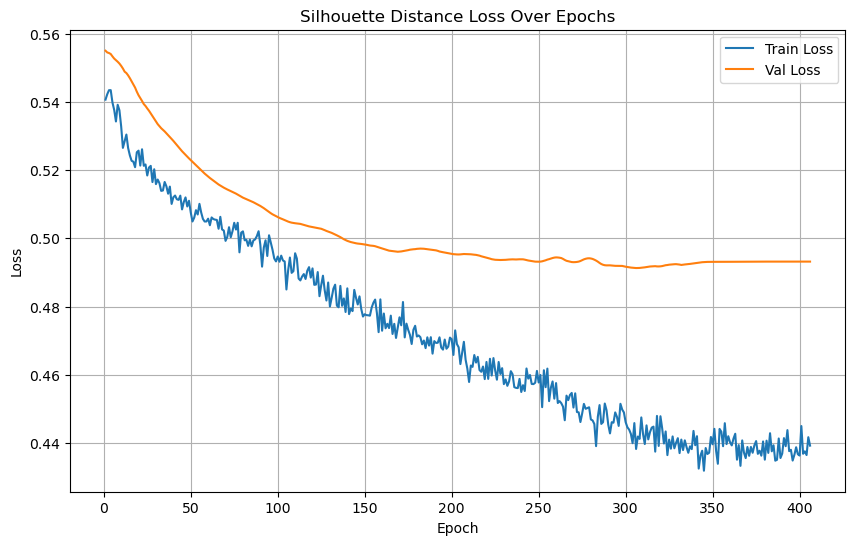

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/79], Loss: 0.3684
Test Batch [20/79], Loss: 0.0916


Test Batch [30/79], Loss: 0.3912
Test Batch [40/79], Loss: 0.3294
Test Batch [50/79], Loss: 0.3021
Test Batch [60/79], Loss: 0.3870
Test Batch [70/79], Loss: 0.3497

Test Loss: 0.3278


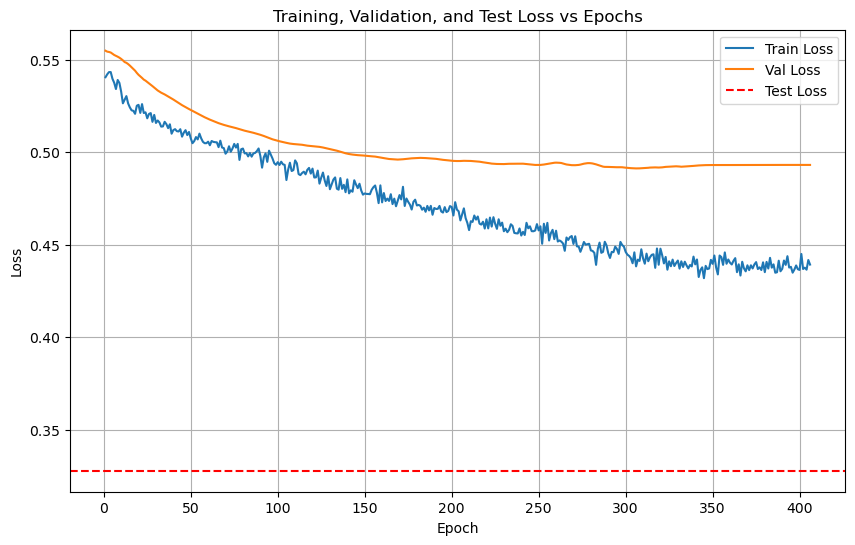

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/79 for test dataset.
  Processed batch 20/79 for test dataset.


  Processed batch 30/79 for test dataset.
  Processed batch 40/79 for test dataset.
  Processed batch 50/79 for test dataset.


  Processed batch 60/79 for test dataset.
  Processed batch 70/79 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 41.54%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.38      0.60      0.46         5
           1       1.00      0.20      0.33         5
           2       0.29      0.40      0.33         5
           3       0.00      0.00      0.00         5
           4       0.50      0.80      0.62         5
           5       0.00      0.00      0.00         5
           6       1.00      0.20      0.33         5
           7       0.33      0.20      0.25         5
           8       0.33      0.60      0.43         5
           9       0.17      0.20      0.18         5
          10       1.00      0.80      0.89         5
          11       0.29      0.40      0.33         5
          12       1.00      1.00      1.00         5

    accuracy         

C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\vella\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (130, 128)
Train labels shape: (130,)
Val reps shape: (65, 128)
Val labels shape: (65,)
Test reps shape: (5016, 128)
Test labels shape: (5016,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6393  |  Val Loss: 2.6291
Validation loss improved from inf to 2.6291.
[Epoch 2/1000] Train Loss: 2.6259  |  Val Loss: 2.6240
Validation loss improved from 2.6291 to 2.6240.
[Epoch 3/1000] Train Loss: 2.6156  |  Val Loss: 2.6199
Validation loss improved from 2.6240 to 2.6199.
[Epoch 4/1000] Train Loss: 2.6068  |  Val Loss: 2.6160
Validation loss improved from 2.6199 to 2.6160.
[Epoch 5/1000] Train Loss: 2.5974  |  Val Loss: 2.6123
Validation loss improved from 2.6160 to 2.6123.
[Epoch 6/1000] Train Loss: 2.5903  |  Val Loss: 2.6086
Validation loss improved from 2.6123 to 2.6086.
[Epoch 7/1000] Train Loss: 2.5819  |  Val Loss: 2.6050
Validation loss improved from 2.6086 to 2.6050.
[Epoch 8/1000] Train Loss: 2.5736  |  Val Loss: 2.6017
Validation loss improved from 2.6050 to 2.6017.
[Epoch 9/1000] Train Loss: 2.5659  |  Val Loss: 2.5990
Validation loss improved from 2.6017 to 2.5990.
[Epoch 10/1000] Train Loss: 2.5589  |  Val Loss: 2.5964
Validation loss impr

[Epoch 19/1000] Train Loss: 2.5126  |  Val Loss: 2.5779
Validation loss improved from 2.5793 to 2.5779.
[Epoch 20/1000] Train Loss: 2.5089  |  Val Loss: 2.5767
Validation loss improved from 2.5779 to 2.5767.
[Epoch 21/1000] Train Loss: 2.5055  |  Val Loss: 2.5752
Validation loss improved from 2.5767 to 2.5752.
[Epoch 22/1000] Train Loss: 2.5015  |  Val Loss: 2.5736
Validation loss improved from 2.5752 to 2.5736.
[Epoch 23/1000] Train Loss: 2.4985  |  Val Loss: 2.5724
Validation loss improved from 2.5736 to 2.5724.
[Epoch 24/1000] Train Loss: 2.4948  |  Val Loss: 2.5712
Validation loss improved from 2.5724 to 2.5712.
[Epoch 25/1000] Train Loss: 2.4914  |  Val Loss: 2.5702
Validation loss improved from 2.5712 to 2.5702.
[Epoch 26/1000] Train Loss: 2.4883  |  Val Loss: 2.5691
Validation loss improved from 2.5702 to 2.5691.


[Epoch 27/1000] Train Loss: 2.4850  |  Val Loss: 2.5680
Validation loss improved from 2.5691 to 2.5680.
[Epoch 28/1000] Train Loss: 2.4816  |  Val Loss: 2.5674
Validation loss improved from 2.5680 to 2.5674.
[Epoch 29/1000] Train Loss: 2.4781  |  Val Loss: 2.5672
Validation loss improved from 2.5674 to 2.5672.
[Epoch 30/1000] Train Loss: 2.4739  |  Val Loss: 2.5668
Validation loss improved from 2.5672 to 2.5668.
[Epoch 31/1000] Train Loss: 2.4699  |  Val Loss: 2.5664
Validation loss improved from 2.5668 to 2.5664.
[Epoch 32/1000] Train Loss: 2.4659  |  Val Loss: 2.5665
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 33/1000] Train Loss: 2.4624  |  Val Loss: 2.5665
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 34/1000] Train Loss: 2.4591  |  Val Loss: 2.5662
Validation loss improved from 2.5664 to 2.5662.
[Epoch 35/1000] Train Loss: 2.4557  |  Val Loss: 2.5655
Validation loss improved from 2.5662 to 2.5655.
[Epoch 36/1000] Train Loss: 2.4526  |  Val Loss: 2.5

[Epoch 51/1000] Train Loss: 2.4118  |  Val Loss: 2.5608
Validation loss improved from 2.5613 to 2.5608.
[Epoch 52/1000] Train Loss: 2.4092  |  Val Loss: 2.5602
Validation loss improved from 2.5608 to 2.5602.
[Epoch 53/1000] Train Loss: 2.4063  |  Val Loss: 2.5593
Validation loss improved from 2.5602 to 2.5593.
[Epoch 54/1000] Train Loss: 2.4037  |  Val Loss: 2.5584
Validation loss improved from 2.5593 to 2.5584.
[Epoch 55/1000] Train Loss: 2.4009  |  Val Loss: 2.5576
Validation loss improved from 2.5584 to 2.5576.
[Epoch 56/1000] Train Loss: 2.3982  |  Val Loss: 2.5567
Validation loss improved from 2.5576 to 2.5567.
[Epoch 57/1000] Train Loss: 2.3960  |  Val Loss: 2.5557
Validation loss improved from 2.5567 to 2.5557.


[Epoch 58/1000] Train Loss: 2.3934  |  Val Loss: 2.5546
Validation loss improved from 2.5557 to 2.5546.
[Epoch 59/1000] Train Loss: 2.3911  |  Val Loss: 2.5536
Validation loss improved from 2.5546 to 2.5536.
[Epoch 60/1000] Train Loss: 2.3886  |  Val Loss: 2.5526
Validation loss improved from 2.5536 to 2.5526.
[Epoch 61/1000] Train Loss: 2.3860  |  Val Loss: 2.5512
Validation loss improved from 2.5526 to 2.5512.
[Epoch 62/1000] Train Loss: 2.3834  |  Val Loss: 2.5502
Validation loss improved from 2.5512 to 2.5502.
[Epoch 63/1000] Train Loss: 2.3807  |  Val Loss: 2.5496
Validation loss improved from 2.5502 to 2.5496.
[Epoch 64/1000] Train Loss: 2.3782  |  Val Loss: 2.5489
Validation loss improved from 2.5496 to 2.5489.
[Epoch 65/1000] Train Loss: 2.3758  |  Val Loss: 2.5481
Validation loss improved from 2.5489 to 2.5481.
[Epoch 66/1000] Train Loss: 2.3736  |  Val Loss: 2.5475
Validation loss improved from 2.5481 to 2.5475.
[Epoch 67/1000] Train Loss: 2.3713  |  Val Loss: 2.5471
Validati

[Epoch 81/1000] Train Loss: 2.3408  |  Val Loss: 2.5383
Validation loss improved from 2.5387 to 2.5383.
[Epoch 82/1000] Train Loss: 2.3387  |  Val Loss: 2.5385
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 83/1000] Train Loss: 2.3365  |  Val Loss: 2.5384
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 84/1000] Train Loss: 2.3343  |  Val Loss: 2.5380
Validation loss improved from 2.5383 to 2.5380.
[Epoch 85/1000] Train Loss: 2.3318  |  Val Loss: 2.5374
Validation loss improved from 2.5380 to 2.5374.
[Epoch 86/1000] Train Loss: 2.3291  |  Val Loss: 2.5366
Validation loss improved from 2.5374 to 2.5366.
[Epoch 87/1000] Train Loss: 2.3267  |  Val Loss: 2.5359
Validation loss improved from 2.5366 to 2.5359.
[Epoch 88/1000] Train Loss: 2.3245  |  Val Loss: 2.5353
Validation loss improved from 2.5359 to 2.5353.
[Epoch 89/1000] Train Loss: 2.3217  |  Val Loss: 2.5350
Validation loss improved from 2.5353 to 2.5350.
[Epoch 90/1000] Train Loss: 2.3188  |  Val Loss: 2.5

[Epoch 91/1000] Train Loss: 2.3160  |  Val Loss: 2.5370
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 92/1000] Train Loss: 2.3129  |  Val Loss: 2.5386
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 93/1000] Train Loss: 2.3103  |  Val Loss: 2.5405
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 94/1000] Train Loss: 2.3072  |  Val Loss: 2.5421
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 95/1000] Train Loss: 2.3046  |  Val Loss: 2.5440
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 96/1000] Train Loss: 2.3020  |  Val Loss: 2.5454
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 97/1000] Train Loss: 2.2995  |  Val Loss: 2.5466
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 98/1000] Train Loss: 2.2973  |  Val Loss: 2.5481
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 99/1000] Train Loss: 2.2947  |  Val Loss: 2.5495
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 10

[Epoch 115/1000] Train Loss: 2.2549  |  Val Loss: 2.5431
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 116/1000] Train Loss: 2.2524  |  Val Loss: 2.5425
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 117/1000] Train Loss: 2.2500  |  Val Loss: 2.5416
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 118/1000] Train Loss: 2.2477  |  Val Loss: 2.5407
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 119/1000] Train Loss: 2.2452  |  Val Loss: 2.5398
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 120/1000] Train Loss: 2.2429  |  Val Loss: 2.5387
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 121/1000] Train Loss: 2.2403  |  Val Loss: 2.5378
!! Validation loss did NOT improve !! Patience: 32/100


[Epoch 122/1000] Train Loss: 2.2378  |  Val Loss: 2.5369
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 123/1000] Train Loss: 2.2356  |  Val Loss: 2.5360
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 124/1000] Train Loss: 2.2333  |  Val Loss: 2.5357
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 125/1000] Train Loss: 2.2310  |  Val Loss: 2.5362
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 126/1000] Train Loss: 2.2286  |  Val Loss: 2.5364
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 127/1000] Train Loss: 2.2265  |  Val Loss: 2.5363
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 128/1000] Train Loss: 2.2242  |  Val Loss: 2.5361
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 129/1000] Train Loss: 2.2221  |  Val Loss: 2.5357
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 130/1000] Train Loss: 2.2200  |  Val Loss: 2.5349
Validation loss improved from 2.5350 to 2.5349.

[Epoch 146/1000] Train Loss: 2.1825  |  Val Loss: 2.5206
Validation loss improved from 2.5214 to 2.5206.
[Epoch 147/1000] Train Loss: 2.1798  |  Val Loss: 2.5190
Validation loss improved from 2.5206 to 2.5190.
[Epoch 148/1000] Train Loss: 2.1762  |  Val Loss: 2.5167
Validation loss improved from 2.5190 to 2.5167.
[Epoch 149/1000] Train Loss: 2.1731  |  Val Loss: 2.5151
Validation loss improved from 2.5167 to 2.5151.
[Epoch 150/1000] Train Loss: 2.1697  |  Val Loss: 2.5145
Validation loss improved from 2.5151 to 2.5145.
[Epoch 151/1000] Train Loss: 2.1665  |  Val Loss: 2.5136
Validation loss improved from 2.5145 to 2.5136.
[Epoch 152/1000] Train Loss: 2.1634  |  Val Loss: 2.5127
Validation loss improved from 2.5136 to 2.5127.


[Epoch 153/1000] Train Loss: 2.1606  |  Val Loss: 2.5117
Validation loss improved from 2.5127 to 2.5117.
[Epoch 154/1000] Train Loss: 2.1583  |  Val Loss: 2.5104
Validation loss improved from 2.5117 to 2.5104.
[Epoch 155/1000] Train Loss: 2.1556  |  Val Loss: 2.5093
Validation loss improved from 2.5104 to 2.5093.
[Epoch 156/1000] Train Loss: 2.1535  |  Val Loss: 2.5085
Validation loss improved from 2.5093 to 2.5085.
[Epoch 157/1000] Train Loss: 2.1512  |  Val Loss: 2.5076
Validation loss improved from 2.5085 to 2.5076.
[Epoch 158/1000] Train Loss: 2.1489  |  Val Loss: 2.5063
Validation loss improved from 2.5076 to 2.5063.
[Epoch 159/1000] Train Loss: 2.1462  |  Val Loss: 2.5053
Validation loss improved from 2.5063 to 2.5053.
[Epoch 160/1000] Train Loss: 2.1437  |  Val Loss: 2.5046
Validation loss improved from 2.5053 to 2.5046.
[Epoch 161/1000] Train Loss: 2.1410  |  Val Loss: 2.5043
Validation loss improved from 2.5046 to 2.5043.
[Epoch 162/1000] Train Loss: 2.1387  |  Val Loss: 2.504

[Epoch 177/1000] Train Loss: 2.1043  |  Val Loss: 2.5009
Validation loss improved from 2.5009 to 2.5009.
[Epoch 178/1000] Train Loss: 2.1022  |  Val Loss: 2.5003
Validation loss improved from 2.5009 to 2.5003.
[Epoch 179/1000] Train Loss: 2.0999  |  Val Loss: 2.4996
Validation loss improved from 2.5003 to 2.4996.
[Epoch 180/1000] Train Loss: 2.0974  |  Val Loss: 2.4989
Validation loss improved from 2.4996 to 2.4989.
[Epoch 181/1000] Train Loss: 2.0951  |  Val Loss: 2.4983
Validation loss improved from 2.4989 to 2.4983.
[Epoch 182/1000] Train Loss: 2.0928  |  Val Loss: 2.4976
Validation loss improved from 2.4983 to 2.4976.


[Epoch 183/1000] Train Loss: 2.0904  |  Val Loss: 2.4967
Validation loss improved from 2.4976 to 2.4967.
[Epoch 184/1000] Train Loss: 2.0880  |  Val Loss: 2.4960
Validation loss improved from 2.4967 to 2.4960.
[Epoch 185/1000] Train Loss: 2.0855  |  Val Loss: 2.4951
Validation loss improved from 2.4960 to 2.4951.
[Epoch 186/1000] Train Loss: 2.0831  |  Val Loss: 2.4944
Validation loss improved from 2.4951 to 2.4944.
[Epoch 187/1000] Train Loss: 2.0808  |  Val Loss: 2.4939
Validation loss improved from 2.4944 to 2.4939.
[Epoch 188/1000] Train Loss: 2.0786  |  Val Loss: 2.4934
Validation loss improved from 2.4939 to 2.4934.
[Epoch 189/1000] Train Loss: 2.0765  |  Val Loss: 2.4928
Validation loss improved from 2.4934 to 2.4928.
[Epoch 190/1000] Train Loss: 2.0741  |  Val Loss: 2.4918
Validation loss improved from 2.4928 to 2.4918.
[Epoch 191/1000] Train Loss: 2.0716  |  Val Loss: 2.4908
Validation loss improved from 2.4918 to 2.4908.
[Epoch 192/1000] Train Loss: 2.0690  |  Val Loss: 2.490

[Epoch 208/1000] Train Loss: 2.0312  |  Val Loss: 2.4917
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 209/1000] Train Loss: 2.0285  |  Val Loss: 2.4915
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 210/1000] Train Loss: 2.0259  |  Val Loss: 2.4915
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 211/1000] Train Loss: 2.0236  |  Val Loss: 2.4914
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 212/1000] Train Loss: 2.0210  |  Val Loss: 2.4905
Validation loss improved from 2.4906 to 2.4905.


[Epoch 213/1000] Train Loss: 2.0183  |  Val Loss: 2.4891
Validation loss improved from 2.4905 to 2.4891.
[Epoch 214/1000] Train Loss: 2.0151  |  Val Loss: 2.4880
Validation loss improved from 2.4891 to 2.4880.
[Epoch 215/1000] Train Loss: 2.0124  |  Val Loss: 2.4872
Validation loss improved from 2.4880 to 2.4872.
[Epoch 216/1000] Train Loss: 2.0098  |  Val Loss: 2.4868
Validation loss improved from 2.4872 to 2.4868.
[Epoch 217/1000] Train Loss: 2.0071  |  Val Loss: 2.4863
Validation loss improved from 2.4868 to 2.4863.
[Epoch 218/1000] Train Loss: 2.0048  |  Val Loss: 2.4858
Validation loss improved from 2.4863 to 2.4858.
[Epoch 219/1000] Train Loss: 2.0023  |  Val Loss: 2.4856
Validation loss improved from 2.4858 to 2.4856.
[Epoch 220/1000] Train Loss: 1.9998  |  Val Loss: 2.4857
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 221/1000] Train Loss: 1.9975  |  Val Loss: 2.4857
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 222/1000] Train Loss: 1.9952  |  Val

[Epoch 242/1000] Train Loss: 1.9484  |  Val Loss: 2.4975
!! Validation loss did NOT improve !! Patience: 23/100


[Epoch 243/1000] Train Loss: 1.9459  |  Val Loss: 2.4976
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 244/1000] Train Loss: 1.9433  |  Val Loss: 2.4978
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 245/1000] Train Loss: 1.9408  |  Val Loss: 2.4980
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 246/1000] Train Loss: 1.9384  |  Val Loss: 2.4981
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 247/1000] Train Loss: 1.9360  |  Val Loss: 2.4985
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 248/1000] Train Loss: 1.9337  |  Val Loss: 2.5000
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 249/1000] Train Loss: 1.9314  |  Val Loss: 2.5010
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 250/1000] Train Loss: 1.9290  |  Val Loss: 2.5023
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 251/1000] Train Loss: 1.9266  |  Val Loss: 2.5039
!! Validation loss did NOT improve !! Patience:

[Epoch 270/1000] Train Loss: 1.8784  |  Val Loss: 2.5232


!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 271/1000] Train Loss: 1.8761  |  Val Loss: 2.5233
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 272/1000] Train Loss: 1.8738  |  Val Loss: 2.5238
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 273/1000] Train Loss: 1.8713  |  Val Loss: 2.5253
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 274/1000] Train Loss: 1.8689  |  Val Loss: 2.5264
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 275/1000] Train Loss: 1.8665  |  Val Loss: 2.5274
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 276/1000] Train Loss: 1.8640  |  Val Loss: 2.5283
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 277/1000] Train Loss: 1.8616  |  Val Loss: 2.5290
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 278/1000] Train Loss: 1.8594  |  Val Loss: 2.5297
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 279/1000] Train Loss: 1.8572  |  Val Loss

[Epoch 302/1000] Train Loss: 1.8032  |  Val Loss: 2.5559
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 303/1000] Train Loss: 1.8008  |  Val Loss: 2.5564
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 304/1000] Train Loss: 1.7985  |  Val Loss: 2.5571
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 305/1000] Train Loss: 1.7961  |  Val Loss: 2.5578
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 306/1000] Train Loss: 1.7937  |  Val Loss: 2.5587
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 307/1000] Train Loss: 1.7913  |  Val Loss: 2.5598
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 308/1000] Train Loss: 1.7888  |  Val Loss: 2.5608
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 309/1000] Train Loss: 1.7864  |  Val Loss: 2.5616
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 310/1000] Train Loss: 1.7840  |  Val Loss: 2.5621
!! Validation loss did NOT improve !! Patience:

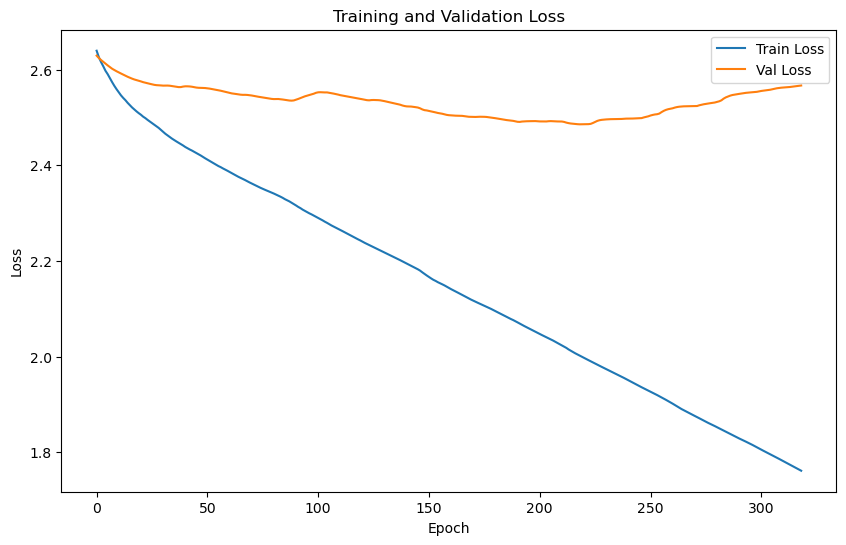

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 2.1097 | Test Accuracy: 41.39%


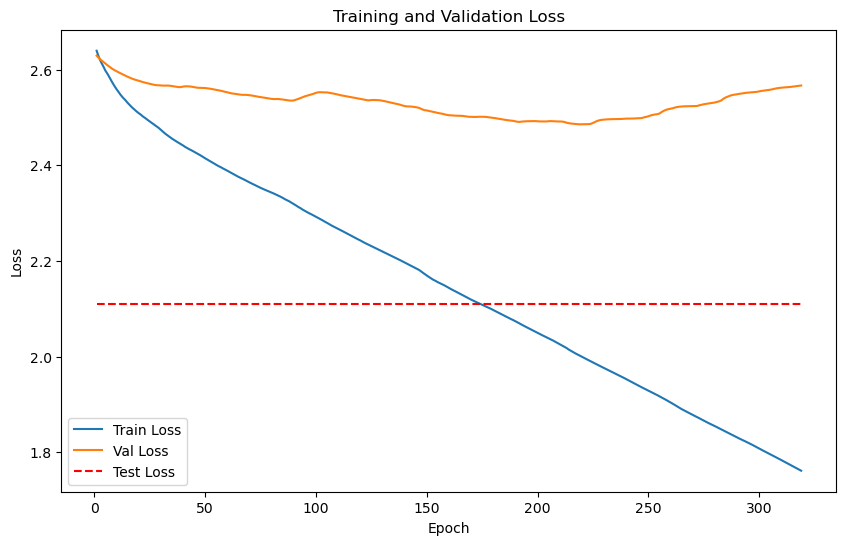

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


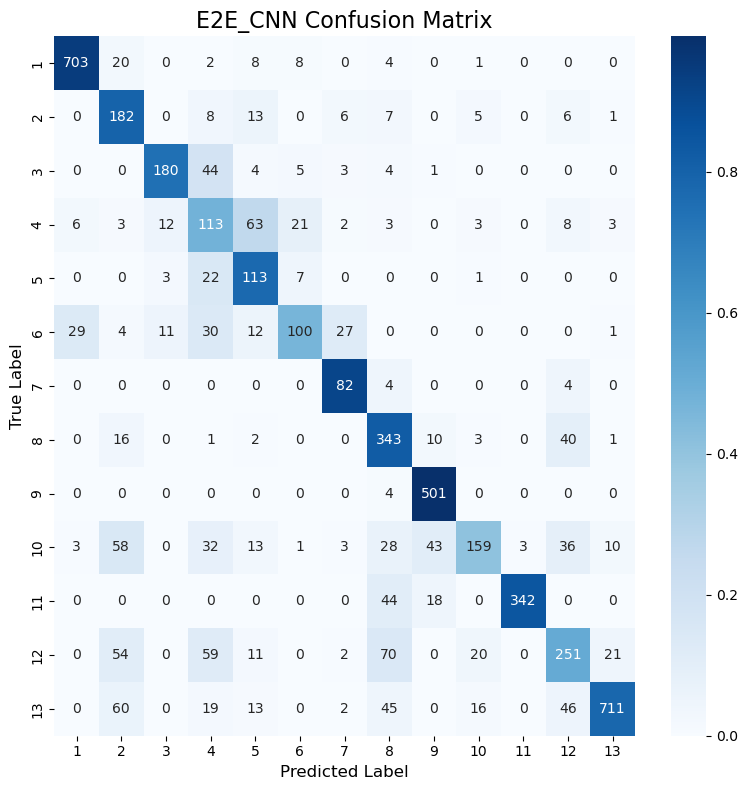

Classification Accuracy: 75.36%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


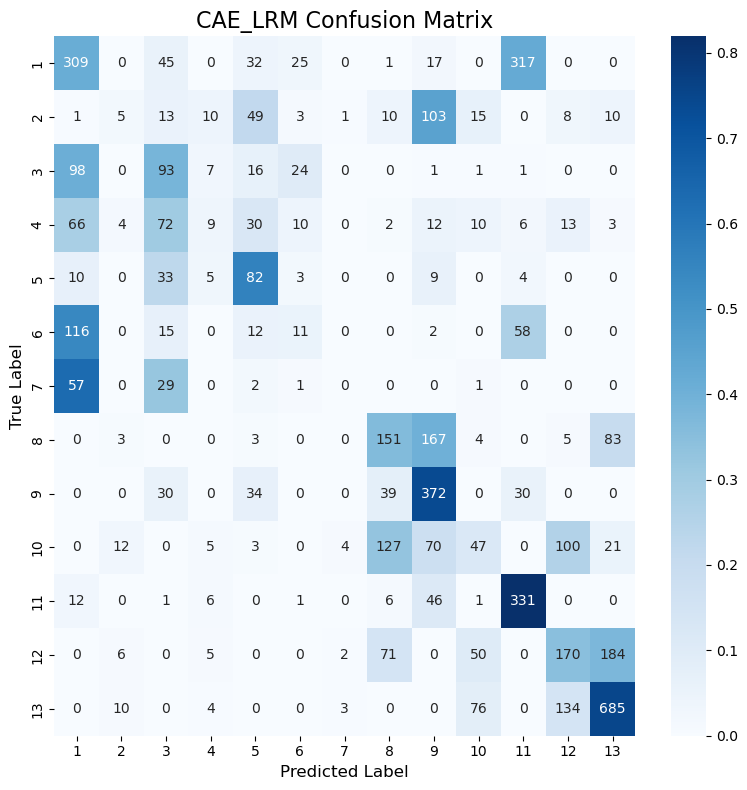

Classification Accuracy: 45.16%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


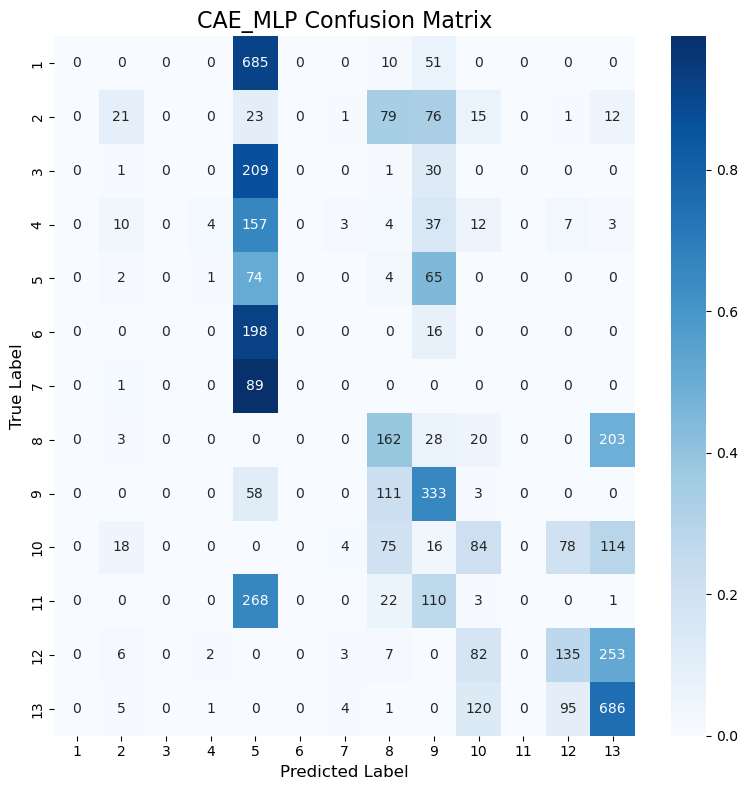

Classification Accuracy: 29.88%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


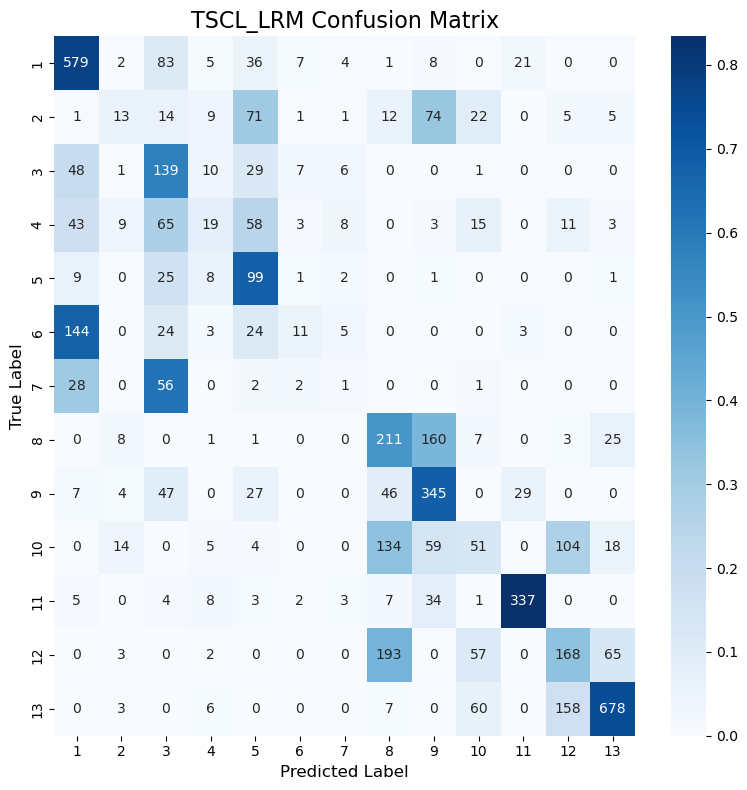

Classification Accuracy: 52.85%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


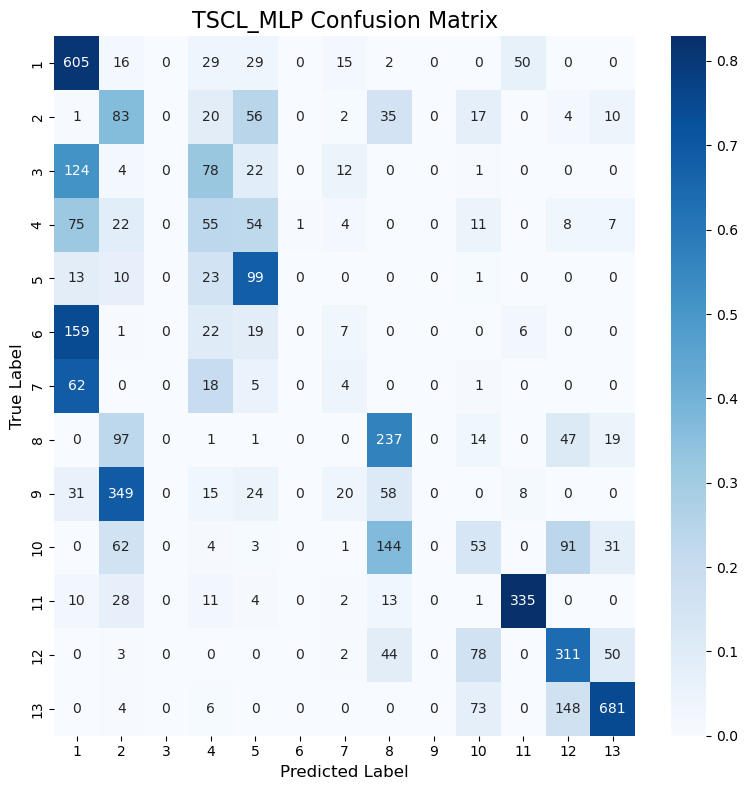

Classification Accuracy: 49.10%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


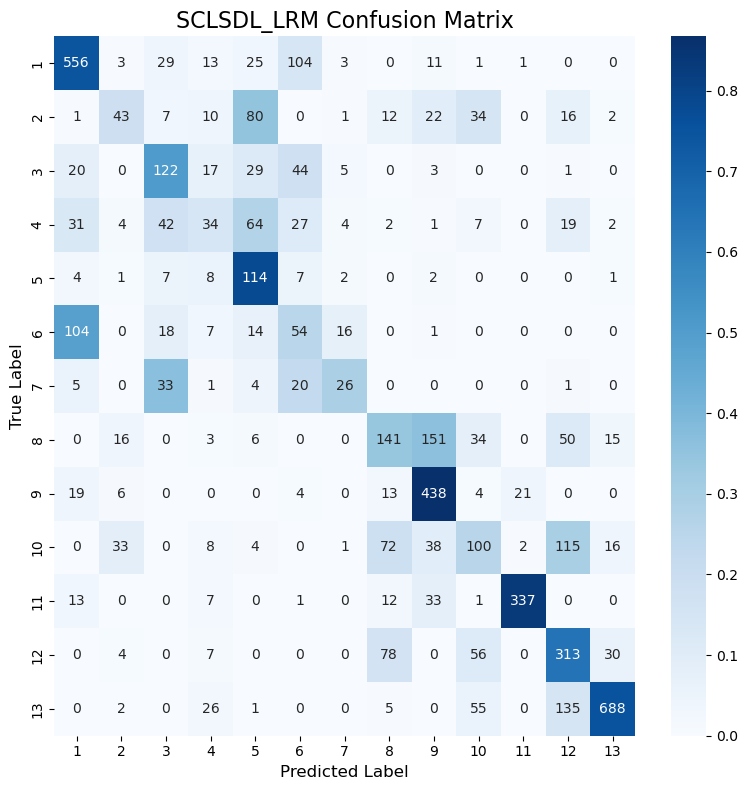

Classification Accuracy: 59.13%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


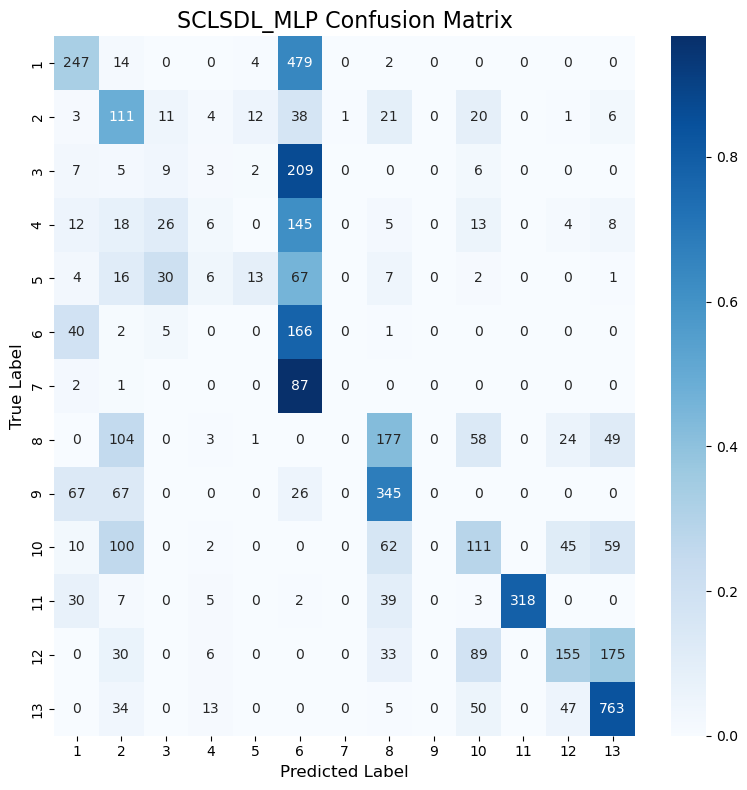

Classification Accuracy: 41.39%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          75.36
1    LRM (CAE)          45.16
2    MLP (CAE)          29.88
3     TSCL LRM          52.85
4     TSCL MLP          49.10
5  SCL_SDL LRM          59.13
6  SCL_SDL MLP          41.39

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          75.36
5  SCL_SDL LRM          59.13
3     TSCL LRM          52.85
4     TSCL MLP          49.10
1    LRM (CAE)          45.16
6  SCL_SDL MLP          41.39
2    MLP (CAE)          29.88
